In [2]:
import os

import networkx as nx

from helpers import bisection_search, load_obj, save_obj, get_size
from networkx import Graph, relabel_nodes
from graphs import draw_graph, gen_ring_graph, graph_from_edges
from decoder_class import CascadeDecoder, FastDecoder
import numpy as np
import matplotlib.pyplot as plt
from time import time
from graph_finding import gen_non_isomorphic_graphs
from cascaded import FastResult
import bz2
from random import randint
from tqdm import tqdm
from multiprocessing import Pool, cpu_count
from os import getcwd
from multiprocess_graphfinding import graph_perf_on_batch
from graph_finding import get_best_perf, get_distance, read_data_from_bz2

In [1]:
def txt_to_edge_data(filename):
    output = []
    with open(filename) as f:
        lines = f.readlines()
    for line in lines:
        x = line.split('\t')
        # for a in x:
        #     print(a)
        n_graphs = int(x[1])
        schmidt = x[5]
        edge_list_ix = 10
        for ix in range(len(x)):
            if x[ix] == 'yes' or x[ix] == 'no':
                edge_list_ix = ix + 1

        edge_list = x[edge_list_ix]
        y = edge_list.split(')')
        edges = [(int(e[1+4*j]), int(e[3+4*j])) for e in y for j in range(len(e)//4)]
        # print(edges)
        output.append((n_graphs, edges))
    return output

In [4]:
path_to_data = getcwd() + '/data/uib_data'
print(path_to_data)

C:\Users\ip19160\PycharmProjects\LTdecode/data/uib_data


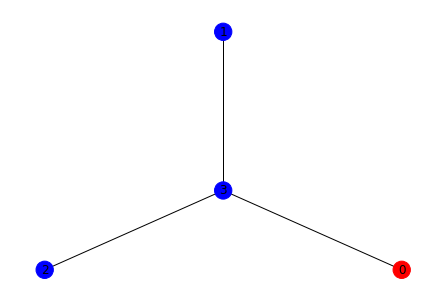

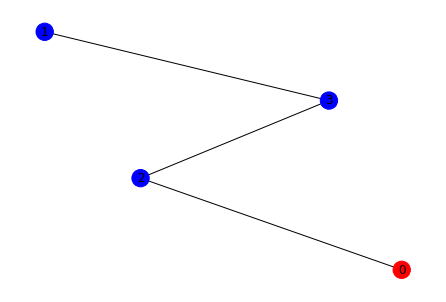

In [5]:
nq = 4
graph_list = txt_to_edge_data(f"data/uib_data/{nq}_qubit_graphs_data_uib.txt")
i = 0
for g in graph_list:
    i += 1
    graph = Graph()
    graph.add_nodes_from(list(range(max([i for j in g[1] for i in j]))))
    graph.add_edges_from(g[1])
    draw_graph(graph)
    if i > 10:
        break

In [5]:
print(len(graph_list))
all_graphs_data = []
for g in graph_list:
    e = g[1]
    all_graphs_data += [(g[0], x) for x in gen_non_isomorphic_graphs(g[1])]
print(len(all_graphs_data))

2
4


In [6]:
sorted_by_class_size = sorted(all_graphs_data, key=lambda x: x[0], reverse=True)
save_obj(obj=sorted_by_class_size, path=path_to_data, name=f"{nq}_qubit_graphs_ordered_num_in_class")
print(sorted_by_class_size[0])

(4, EdgeView([(0, 2), (1, 3), (2, 3)]))


In [50]:
g9 = gen_ring_graph(9)
d9 = CascadeDecoder(g9)
t = time()
d9.build_tree(cascading=True)
print(time() - t)

4.034209966659546


With cascading, the 10 qubit graph takes 5x longer to decode than the 9 qubit graph, at 20 seconds.

Without cascading, it takes 8s. 3142 graphs is then 25000s of computation time. On 10 cores we
have 40 hours of runtime. Additionally, permuting the input qubit adds a factor of 10x, so 400 hours which is
17 days. Using the FastDecoder and no cascading this comes down to 1.5s per 10 qubit graphs.

Checking graph isomorphisms up to the unique input qubit also saves us checking ~10,000 graphs. The expected time is now
1.3 * 22000 ~ 8.5 hours. on 10 cores this is 50 minutes.

In [ ]:
n_threads = cpu_count() - 1
n=10
graph_data = all_graphs_data
n_graphs = len(graph_data)
all_graph_ixs = list(range(n_graphs))
if n_graphs % n_threads:
    per_thread = n_graphs // n_threads + 1
else:
    per_thread = n_graphs / n_threads
input_lists = [list(x) for x in np.array_split(all_graph_ixs, n_threads)]
print(n_graphs, per_thread, n_threads)
graph_lists = [[graph_data[ix] for ix in input_lists[i]] for i in range(n_threads)]  # Take only the first from each equivalence class
#
t0 = time()
with Pool(n_threads) as p:
    out = p.map(graph_perf_on_batch, graph_lists)
t1 = time()
print(t1 - t0)

save_obj(out, f'{n}QubitResultsDicts_PermuteInputFastDecoder', getcwd()+'/LC_equiv_graph_data')



25133 2285 11


In [52]:
data = load_obj('10QubitResultsDicts_PermuteInputFastDecoder', getcwd()+'/LC_equiv_graph_data')
data_flat = [g for d in data for g in d]
print(data_flat[0])
print(len(data_flat))

(EdgeView([(0, 9), (1, 9), (2, 9), (3, 9), (4, 9), (5, 9), (6, 9), (7, 9), (8, 9)]), {(0, 0, 0, 0, 8, 0, 1, 0): 1})
100


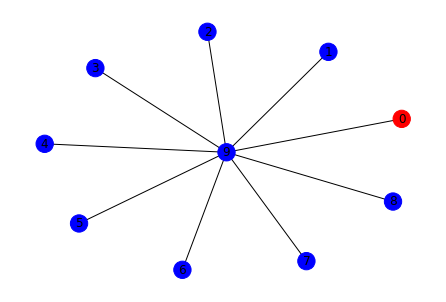

In [53]:
g = Graph()
g.add_edges_from(data_flat[0][0])
draw_graph(g)

In [54]:
star_equivs = gen_non_isomorphic_graphs(graph_list[0])
g = Graph()
g.add_edges_from(star_equivs[0])
draw_graph(g)

NameError: name 'graph_list' is not defined

Inspecting the results of the 10 qubit simulations

In [28]:
from os import getcwd
results = [load_obj(f'10QubitResultsDicts_PermuteInputFastDecoder_batch{i}', path=getcwd() + '/graph_perf_10q') for i in range(23)]

In [29]:
full = []
for r in results:
    flattened = [x for y in r for x in y]
    print(len(flattened))
    full += flattened
print(len(full))

1100
1100
1100
1100
1100
1100
1100
1100
1100
1100
1100
1100
1100
1100
1100
1100
1100
1100
1100
1100
1100
1100
933
25133


In [30]:
best = 0
g_best = None
eta = 0.99
for g in full:
    edges, spcr = g
    r = FastResult(spcr)
    out = r.get_spc_prob(eta)
    if out > best:
        g_best = edges
        best = out
        spcr_best = spcr
print(best)


0.9999858656123908


Inspect the performance of the best sub-threshold 10 qubit graph (9 code qubits). Find it's distance by looking
for the sub-threshold scaling


In [10]:
g = Graph()
g.add_nodes_from(list(range(10)))
g.add_edges_from(g_best)
draw_graph(g)

low_loss_etas = np.linspace(0.9, 0.9999)
r = FastResult(spcr_best)
eta_log = [r.get_spc_prob(t) for t in low_loss_etas]
log_x = [np.log(1-t) for t in low_loss_etas]
log_y = [np.log(1-tl) for tl in eta_log]
grad = (log_y[-1] - log_y[0])/(log_x[-1] - log_x[0])
plt.plot(log_x, log_y)
plt.show()
print(grad)

etas = np.linspace(0, 1, 1000)
eta_log = [r.get_spc_prob(t) for t in etas]

best_sub_thresh = [g_best, etas, eta_log]
save_obj(best_sub_thresh, 'best_graph_n=10_subthreshold', getcwd())

NameError: name 'g_best' is not defined

Now find best threshold

In [32]:
min_threshold = 1
best_thresh_graph = None
best_thresh_spc = None
for graph in full:
    edges, spcr = graph
    r = FastResult(spcr)
    def func(t):
        return r.get_spc_prob(t) - t
    try:
        thresh = bisection_search((0.5, 0.9), func)
    except ValueError:
        # print('NO ROOT')
        thresh = 1
    if thresh <= min_threshold:
        min_threshold = thresh
        best_thresh_graph = graph
        best_thresh_spcr = spcr

In [33]:
r = FastResult(best_thresh_spcr)
etas = np.linspace(0, 1, 1000)
eta_log = [r.get_spc_prob(t) for t in etas]

best_thresh = [best_thresh_graph, etas, eta_log]
save_obj(best_thresh, 'best_graph_n=10_threshold', getcwd())
print(min_threshold)

0.6333984374999999


## Find the distribution of subthreshold and threshold performances

In [44]:
subthresh_perf = []
thresholds = []
for g in full:
    edges, spcr = g
    r = FastResult(spcr)
    subthresh_perf.append(1 - r.get_spc_prob(0.99))
    def func(t):
        return r.get_spc_prob(t) - t
    try:
        thresh = bisection_search((0.5, 0.98), func)
    except ValueError:
        # print('NO ROOT')
        thresh = 1
    if thresh != 1:
        thresholds.append(1- thresh)

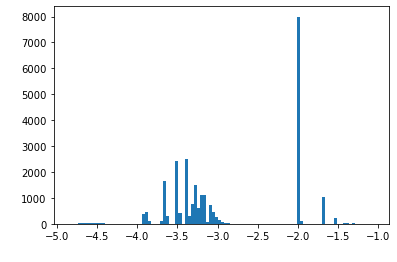

In [50]:
plt.hist(np.log10(subthresh_perf), bins=100)
plt.xlabel('Logical loss at eta=0.99', color='white')
plt.ylabel('Frequency', color='white')
plt.show()

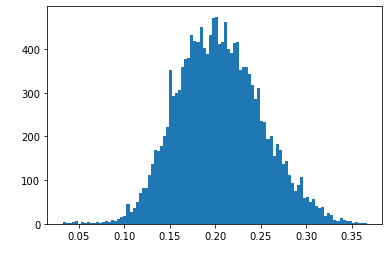

In [51]:
plt.hist(thresholds, bins=100)
plt.xlabel('Threshold', color='white')
plt.ylabel('Frequency', color='white')
plt.show()


## Comparing data from BC run to that from before

In [3]:
bests = get_best_perf(5, 10)

((EdgeView([(0, 1), (0, 2), (1, 3), (2, 4), (3, 4)]), {(1, 0, 0, 0, 1, 0, 1, 0): 1, (0, 1, 0, 0, 2, 0, 1, 0): 1, (1, 0, 0, 0, 1, 1, 1, 0): 1, (0, 0, 2, 0, 0, 0, 1, 1): 1}, 3), 0.9994079699999999, (EdgeView([(0, 1), (0, 2), (1, 3), (2, 4), (3, 4)]), {(1, 0, 0, 0, 1, 0, 1, 0): 1, (0, 1, 0, 0, 2, 0, 1, 0): 1, (1, 0, 0, 0, 1, 1, 1, 0): 1, (0, 0, 2, 0, 0, 0, 1, 1): 1}, 3), 0.7674072265625)
((EdgeView([(0, 3), (0, 4), (1, 5), (2, 4), (3, 5)]), {(2, 0, 0, 0, 0, 0, 1, 0): 1, (1, 1, 1, 0, 0, 0, 1, 0): 2, (0, 2, 2, 0, 0, 0, 1, 0): 1, (0, 0, 0, 0, 3, 0, 1, 1): 1}, 25), 0.9994079700000001, (EdgeView([(0, 3), (0, 4), (1, 5), (2, 4), (3, 5)]), {(2, 0, 0, 0, 0, 0, 1, 0): 1, (1, 1, 1, 0, 0, 0, 1, 0): 2, (0, 2, 2, 0, 0, 0, 1, 0): 1, (0, 0, 0, 0, 3, 0, 1, 1): 1}, 25), 0.7674072265625)
((EdgeView([(0, 5), (0, 1), (1, 6), (2, 3), (2, 6), (3, 5), (4, 6), (4, 5)]), {(1, 0, 1, 0, 0, 0, 1, 0): 1, (1, 0, 1, 1, 0, 0, 1, 0): 1, (2, 0, 1, 2, 0, 0, 1, 0): 1, (0, 1, 2, 0, 0, 0, 1, 0): 1, (0, 1, 1, 1, 2, 0, 1, 0): 2

In [4]:
print([v[1] for k, v in bests.items()])

[0.9994079699999999, 0.9994079700000001, 0.999695178504, 0.9999775646219701, 0.9999803599563594, 0.9999858656123908]


# 11 qubit graphs
### #1 Read graphs from zip file

In [38]:
graphs_11q = []
with bz2.open('data/uib_data/entanglement11.bz2') as f:
    lines = f.readlines()
for line in lines:
    line = line.decode('UTF-8')
    x = line.split('\t')
    # for a in x:
    #     print(a)
    n_graphs = int(x[1])
    schmidt = x[5]
    edge_list_ix = 10
    for ix in range(len(x)):
        if x[ix] == 'yes' or x[ix] == 'no':
            edge_list_ix = ix + 1

    edge_list = x[edge_list_ix]
    e2 = edge_list.replace(')(', ',').removeprefix('(').removesuffix(')').split(',')
    e3 = [_.split('-') for _ in e2]
    e4 = [(int(x[0]), int(x[1])) for x in e3]
    graphs_11q.append((n_graphs, e4))
print(f'There are {len(graphs_11q)} classes of 11 qubit graph state')

There are 40457 classes of 11 qubit graph state


### Get all inequivalent graphs by permuting the input


In [39]:
all_graphs_11q = []
for g in tqdm(graphs_11q):
    e = g[1]
    all_graphs_11q += [(g[0], x) for x in gen_non_isomorphic_graphs(e)]
all_graphs_11q = sorted(all_graphs_11q, key=lambda x:x[0], reverse=True)

100%|██████████| 40457/40457 [05:54<00:00, 114.15it/s]


In [41]:
save_obj(all_graphs_11q, '11_qubit_graphs_ordered_num_in_class', getcwd()+'/data/uib_data')

In [42]:
print(f'There are {len(all_graphs_11q)} different graphs for stabilizer pathfinding')
print(f'{11 * len(graphs_11q) - len(all_graphs_11q)} have been eliminated due to symmetry')
x = load_obj('11_qubit_graphs_ordered_num_in_class', getcwd()+'/data/uib_data')

There are 405741 different graphs for stabilizer pathfinding
39286 have been eliminated due to symmetry


### How long does each simulation take?


In [24]:
t0 = time()

for _ in range(10):
    ix = randint(0, len(all_graphs_11q))
    print(f'{ix=}')
    e = all_graphs_11q[ix][1]
    g = Graph()
    g.add_nodes_from(list(range(11)))
    g.add_edges_from(e)
    decoder = FastDecoder(g)
    decoder.get_dict()
    eta_logical = decoder.success_prob(0.99)
    print('Transmission = ' + str(eta_logical))
t1 = time()
print(f'Time taken for ten graphs: {t1-t0}s')
print(f'Per graph: {(t1-t0)/10}s')

ix=318769
Transmission = 0.9899959919867836
ix=204689
Transmission = 0.9999747483552337
ix=41136
Transmission = 0.9997812143614938
ix=165733
Transmission = 0.9997853400474005
ix=169725
Transmission = 0.9997653221765719
ix=224360
Transmission = 0.9997595785761062
ix=5298
Transmission = 0.9997764687299863
ix=218578
Transmission = 0.9995818186610486
ix=164776
Transmission = 0.9994903720274833
ix=138516
Transmission = 0.9998641684627545
Time taken for ten graphs: 91.36009669303894s
Per graph: 9.136009669303894s


Simulate graphs using multiprocessing in a script and save the data.
Inspect the distribution of subthreshold performances (eta=0.99) and thresholds


## Compare previously obtained data with that run on the HPC server for 10 qubit graphs

## 11 qubit jobs run on blue crystal in 81 batches of 5000 graphs, inspecting graph performance below

In [2]:
best_11 = get_best_perf(11, 11)

Graphs loaded, filesize=28865484
File number #0 complete, current bests: max_subthresh=0.9999835758185486, min_threshold=0.7234619140624999, max_dist=3.003444729259774
Graphs loaded, filesize=28624780
File number #1 complete, current bests: max_subthresh=0.9999836423888124, min_threshold=0.7076416015625, max_dist=3.0042082528203458
Graphs loaded, filesize=26813404
File number #2 complete, current bests: max_subthresh=0.9999876912289499, min_threshold=0.6817138671874999, max_dist=3.0043959316840594
Graphs loaded, filesize=26521608
File number #3 complete, current bests: max_subthresh=0.9999876912289499, min_threshold=0.6812744140624999, max_dist=3.0043959316840594
Graphs loaded, filesize=26226320
File number #4 complete, current bests: max_subthresh=0.9999876912289499, min_threshold=0.6812744140624999, max_dist=3.0043959316840594
Graphs loaded, filesize=25944636
File number #5 complete, current bests: max_subthresh=0.9999876912289499, min_threshold=0.6812744140624999, max_dist=3.0043959

IndexError: tuple index out of range

0.9999905625522467 0.6201904296875


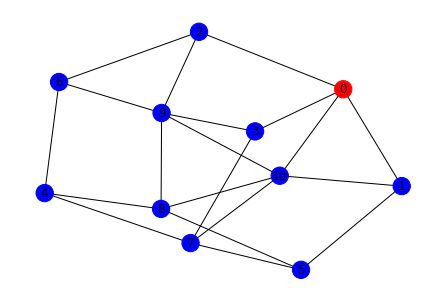

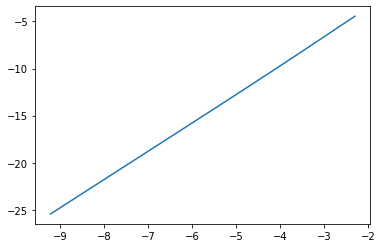

3.0371435044951682

In [16]:
print(best_11[11][1], best_11[11][3])  # Best subthreshold and best threshold
g = Graph()
edges_sub = best_11[11][0][0]
g.add_nodes_from(list(range(max([nod for e in edges_sub for nod in e]))))
g.add_edges_from(edges_sub)
draw_graph(g)

get_distance(best_11[11][0][1])

In [22]:
best_g = best_11[11][2]
x = FastResult(best_g[1])
etas = np.linspace(0, 1, 10000)
eta_logical = [x.get_spc_prob(eta) for eta in etas]
save_obj((best_g[0], etas, eta_logical), name='best_graph_n=11_threshold', path=getcwd()+'/best_graphs')



# 12 Qubit graphs

Preliminaries for 12 qubit graphs - get data and search for inequivalent graphs.
Will need to pick graphs from largest classes - so save class sizes as well as graphs

Read all graphs from zip file



In [8]:

graphs_12q = []
with bz2.open(getcwd()+'/data/uib_data/entanglement12.bz2') as f:
    lines = f.readlines()
for line in tqdm(lines):
    line = line.decode('UTF-8')
    x = line.split('\t')
    # for a in x:
    #     print(a)
    n_graphs = int(x[1])
    schmidt = x[5]
    edge_list_ix = 10
    for ix in range(len(x)):
        if x[ix] == 'yes' or x[ix] == 'no':
            edge_list_ix = ix + 1

    edge_list = x[edge_list_ix]
    e2 = edge_list.replace(')(', ',').removeprefix('(').removesuffix(')').split(',')
    e3 = [_.split('-') for _ in e2]
    e4 = [(int(x[0]), int(x[1])) for x in e3]
    graphs_12q.append((n_graphs, e4))
print(f'There are {len(graphs_12q)} classes of 12 qubit graph state')

100%|██████████| 1274068/1274068 [00:23<00:00, 55242.96it/s]

There are 1274068 classes of 12 qubit graph state


In [6]:
t0 = time()

for _ in tqdm(range(10)):
    ix = randint(0, len(graphs_12q))
    print(f'{ix=}')
    e = graphs_12q[ix]
    g = Graph()
    g.add_nodes_from(list(range(11)))
    g.add_edges_from(e)
    decoder = FastDecoder(g)
    decoder.get_dict()
    eta_logical = decoder.success_prob(0.99)
    print('Transmission = ' + str(eta_logical))
t1 = time()
print(f'Time taken for ten graphs: {t1-t0}s')
print(f'Per graph: {(t1-t0)/10}s')

  0%|          | 0/10 [00:00<?, ?it/s]

ix=632249


 10%|█         | 1/10 [00:28<04:15, 28.34s/it]

Transmission = 0.9997821838036037
ix=990049


 20%|██        | 2/10 [00:58<03:56, 29.58s/it]

Transmission = 0.9998857929418121
ix=295248


 30%|███       | 3/10 [01:24<03:15, 27.93s/it]

Transmission = 0.9898978481901496
ix=215212


 40%|████      | 4/10 [01:55<02:54, 29.10s/it]

Transmission = 0.9899978650596387
ix=158464


 50%|█████     | 5/10 [02:20<02:17, 27.47s/it]

Transmission = 0.989884638746247
ix=1047806


 60%|██████    | 6/10 [02:54<01:59, 29.94s/it]

Transmission = 0.9997809791730861
ix=931791


 70%|███████   | 7/10 [03:23<01:28, 29.51s/it]

Transmission = 0.9998848048583954
ix=282406


 80%|████████  | 8/10 [03:46<00:55, 27.55s/it]

Transmission = 0.9898998081835628
ix=477953


 90%|█████████ | 9/10 [04:13<00:27, 27.37s/it]

Transmission = 0.9897922988439338
ix=536891


100%|██████████| 10/10 [04:48<00:00, 28.81s/it]

Transmission = 0.9997775972841434
Time taken for ten graphs: 288.1749312877655s
Per graph: 28.81749312877655s


at 30s per graph we are looking at 1.5e7 * 30 = 4.5e9 seconds of CPU time.
This is 142 years of CPU time


This is a prohibitively long time, so instead consider the classes that contain the most graphs -
this is often a good proxy for the graphs with the best loss tolerance. Plot a histogram
of the number of graphs in each equivalence class

[243064, 242960, 242960, 242940, 242940, 242940, 242932, 242920, 242912, 242900, 242892, 242892, 242892, 242872, 242864, 242864, 242856, 242844, 242844, 242844]


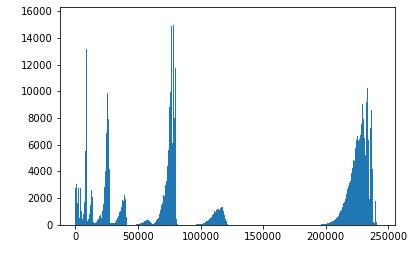

In [9]:
graphs_12q_ordered = sorted(graphs_12q, key=lambda x: x[0], reverse=True)
print([x[0] for x in graphs_12q_ordered[:20]])
plt.hist([x[0] for x in graphs_12q_ordered], bins=1000)
plt.xlabel('Number of graphs in equivalence class', color='white')
plt.ylabel('Frequency', color='white')
plt.show()

In [26]:
save_obj(graphs_12q_ordered, '12qubitgraphs_ordered_num_in_class', getcwd()+'/uib_data')

(243064,
 [(0, 6),
  (1, 3),
  (2, 11),
  (4, 8),
  (5, 9),
  (7, 10),
  (0, 4),
  (1, 6),
  (2, 10),
  (3, 11),
  (5, 8),
  (7, 9),
  (0, 10),
  (1, 8),
  (2, 5),
  (4, 9),
  (7, 11),
  (0, 2),
  (1, 5),
  (3, 4),
  (6, 10),
  (7, 8),
  (9, 11),
  (3, 9),
  (6, 8),
  (10, 11)])

In [11]:
# generate non-isomorphic graphs and save in batches
graphs_12q_current_list = []
batchno = 0
for g in tqdm(graphs_12q_ordered):
    e = g[1]
    graphs_12q_current_list += [(g[0], x) for x in gen_non_isomorphic_graphs(e)]
    if len(graphs_12q_current_list) > 1000:
        save_obj(graphs_12q_current_list, f'graphs_data_batch{batchno}', getcwd()+'/graphs_batched_12q')
        graphs_12q_current_list = []
        batchno+=1

  5%|▌         | 64251/1274068 [14:32<4:33:54, 73.61it/s] 


KeyboardInterrupt: 

## Load 12 qubit graphs and inspect the variable size to see how much data we expect to use when decoding


10503096

56
56
28


(243064,
 [(0, 6),
  (1, 3),
  (2, 11),
  (4, 8),
  (5, 9),
  (7, 10),
  (0, 4),
  (1, 6),
  (2, 10),
  (3, 11),
  (5, 8),
  (7, 9),
  (0, 10),
  (1, 8),
  (2, 5),
  (4, 9),
  (7, 11),
  (0, 2),
  (1, 5),
  (3, 4),
  (6, 10),
  (7, 8),
  (9, 11),
  (3, 9),
  (6, 8),
  (10, 11)])

10192544

1728868

In [16]:
per_graph = 16803860/10000
total = per_graph * len(x)

In [19]:
totalgb = total / 10**9
totalgb

2.140926030248

In [12]:
with bz2.open('data/uib_data/entanglement12.bz2') as f:
    lines = f.readlines()
get_size(lines[:1000])

264923

In [13]:
with bz2.open('data/uib_data/entanglement11.bz2') as f:
    lines = f.readlines()
get_size(lines[:1000])


212214

In [15]:
print(lines[:2
      ])

[b'3719\t2\t11\t(10,10,1)\t-\t1\t(0,0,0,0,462)\t(0,0,0,330)\t(0,0,165)\t(0,55)\t(1023,1024,0,0,0,0,0,0,0,0,0,0,0)\tyes\t(0-10)(1-10)(2-10)(3-10)(4-10)(5-10)(6-10)(7-10)(8-10)(9-10)\t-\n', b'3720\t6\t11\t(10,9,1)\t-\t2\t(0,0,0,252,210)\t(0,0,168,162)\t(0,72,93)\t(18,37)\t(1278,512,255,0,0,0,0,0,0,0,0,0,0)\tyes\t(0-10,8-9)(1-10)(2-10)(3-10)(4-10)(5-10)(6-10)(7-10)(9-10)\t-\n']


[(2, [(0, 10), (1, 10), (2, 10), (3, 10), (4, 10), (5, 10), (6, 10), (7, 10), (8, 10), (9, 10)]), (6, [(0, 10), (8, 9), (1, 10), (2, 10), (3, 10), (4, 10), (5, 10), (6, 10), (7, 10), (9, 10)])]


81672

17369

## It turns out the output files are very large - 60 graphs have output files of 2.1GB
### To reduce the size of the files we consider compressing the results dictionaries from the decoder. Test this performance here




In [3]:
ratios = []
sizes_full = []
sizes_compressed = []
graphs = read_data_from_bz2(5435, 5445, filename='entanglement12.bz2', path_to_file=getcwd() + '/data/uib_data')
for graph in tqdm(graphs):
    g = Graph()
    g.add_nodes_from(list(range(max([i for j in graph[1] for i in j]))))
    g.add_edges_from(graph[1])
    decoder = FastDecoder(g)
    full_dict = decoder.get_dict()
    dict_compressed = decoder.get_dict(condensed=True)

    full_size = get_size(full_dict)
    condensed_size = get_size(dict_compressed)
    ratios.append(full_size/condensed_size)
    sizes_full.append(full_size)
    sizes_compressed.append(condensed_size)
    print(sizes_full, sizes_compressed)
print(ratios)
print(sum(ratios)/len(ratios))

 10%|█         | 1/10 [00:24<03:41, 24.66s/it]

[2648] [1644]


 20%|██        | 2/10 [01:51<08:09, 61.25s/it]

[2648, 2988] [1644, 1672]


 30%|███       | 3/10 [02:25<05:41, 48.76s/it]

[2648, 2988, 2988] [1644, 1672, 1672]


 40%|████      | 4/10 [03:18<05:03, 50.64s/it]

[2648, 2988, 2988, 2544] [1644, 1672, 1672, 1644]


 50%|█████     | 5/10 [04:08<04:10, 50.17s/it]

[2648, 2988, 2988, 2544, 3836] [1644, 1672, 1672, 1644, 1756]


 60%|██████    | 6/10 [04:38<02:53, 43.42s/it]

[2648, 2988, 2988, 2544, 3836, 3676] [1644, 1672, 1672, 1644, 1756, 1616]


 70%|███████   | 7/10 [05:39<02:27, 49.11s/it]

[2648, 2988, 2988, 2544, 3836, 3676, 3600] [1644, 1672, 1672, 1644, 1756, 1616, 1756]


 80%|████████  | 8/10 [06:00<01:20, 40.07s/it]

[2648, 2988, 2988, 2544, 3836, 3676, 3600, 2128] [1644, 1672, 1672, 1644, 1756, 1616, 1756, 1056]


 90%|█████████ | 9/10 [06:45<00:41, 41.81s/it]

[2648, 2988, 2988, 2544, 3836, 3676, 3600, 2128, 3940] [1644, 1672, 1672, 1644, 1756, 1616, 1756, 1056, 1812]


100%|██████████| 10/10 [07:08<00:00, 42.87s/it]

[2648, 2988, 2988, 2544, 3836, 3676, 3600, 2128, 3940, 2628] [1644, 1672, 1672, 1644, 1756, 1616, 1756, 1056, 1812, 1504]
[1.610705596107056, 1.7870813397129186, 1.7870813397129186, 1.5474452554744527, 2.1845102505694762, 2.2747524752475248, 2.050113895216401, 2.015151515151515, 2.1743929359823397, 1.747340425531915]
1.917857502870652


Check they give the same performance

In [4]:
print(sizes_full)
print(sizes_compressed)
print(sum(sizes_full))
print(sum(sizes_compressed))

[1196, 1300, 1328, 1300, 2440, 1536, 1328, 1328, 1536, 1252]
[676, 916, 916, 860, 1420, 944, 972, 1028, 1028, 888]
14544
9648


In [5]:
print(full_dict)
print(dict_compressed)

{(1, 0, 1, 0, 2, 0, 1, 0): 1, (0, 1, 2, 0, 2, 0, 1, 0): 1, (2, 1, 1, 1, 3, 0, 1, 0): 1, (1, 2, 2, 1, 3, 0, 1, 0): 1, (1, 0, 0, 0, 4, 1, 1, 0): 1, (0, 1, 1, 0, 4, 1, 1, 0): 1, (0, 1, 0, 1, 6, 1, 1, 0): 1}
{(5, 0): 1, (5, 1): 1, (7, 2): 1, (7, 3): 2, (6, 1): 1, (6, 2): 1}


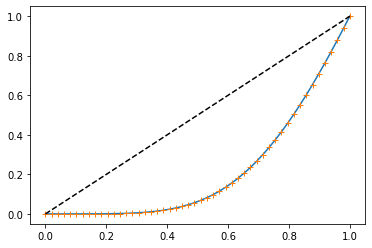

In [7]:
etas = np.linspace(0, 1)
x = FastResult(dict_compressed)
y = FastResult(full_dict)
plt.plot(etas, [x.get_spc_prob(t) for t in etas])
plt.plot(etas, [y.get_spc_prob(t) for t in etas], '+')
plt.plot(etas, etas, 'k--')
plt.show()

In [2]:

best_12 = get_best_perf(12, 12)

Graphs loaded, filesize=631892
File number #0 complete, current bests: max_subthresh=0.9996867717605658, min_threshold=0.6645751953125, max_dist=2.0009952554116355
Graphs loaded, filesize=2658600
File number #1 complete, current bests: max_subthresh=0.9996950817700412, min_threshold=0.6645751953125, max_dist=2.0009952554116355
Graphs loaded, filesize=3190972
File number #2 complete, current bests: max_subthresh=0.9997882985841602, min_threshold=0.6645751953125, max_dist=2.001603323356775
Graphs loaded, filesize=4221456
File number #3 complete, current bests: max_subthresh=0.9998803534622867, min_threshold=0.6430419921875, max_dist=2.007366650526945
Graphs loaded, filesize=4212032
File number #4 complete, current bests: max_subthresh=0.9999708405373815, min_threshold=0.6430419921875, max_dist=3.0011726801360195
Graphs loaded, filesize=4254680
File number #5 complete, current bests: max_subthresh=0.9999708405373815, min_threshold=0.6430419921875, max_dist=3.0011726801360195
Graphs loaded

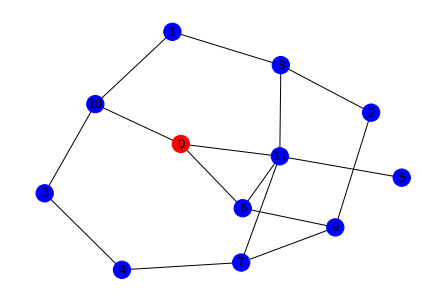

In [3]:
e = best_12[12][0][0]
g = Graph()
g.add_edges_from(e)
draw_graph(g)

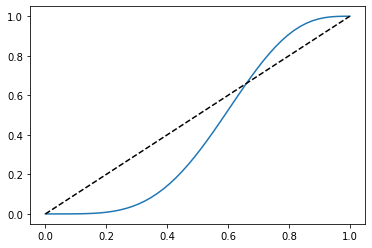

In [4]:
x = FastResult(best_12[12][0][1])
etas = np.linspace(0, 1)
plt.plot(etas, [x.get_spc_prob(t) for t in etas])
plt.plot(etas, etas, 'k--')
plt.show()

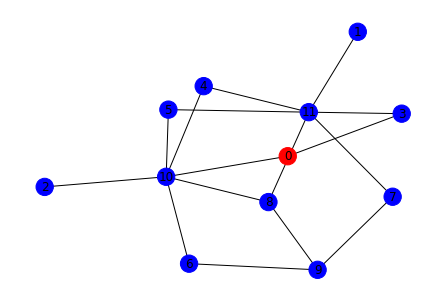

In [5]:
e = best_12[12][2][0]
g = Graph()
g.add_edges_from(e)
draw_graph(g)


In [4]:
best_12 = get_best_perf(12, 12, printing=False)

100%|██████████| 4997/4997 [53:41<00:00,  1.55it/s] 

((EdgeView([(0, 11), (0, 8), (0, 1), (1, 11), (1, 9), (2, 6), (2, 11), (2, 8), (3, 5), (3, 4), (3, 11), (4, 7), (4, 10), (5, 10), (5, 6), (6, 9), (7, 8), (7, 9), (7, 11), (8, 10), (9, 10)]), {(4, 0): 1, (5, 1): 4, (6, 2): 10, (7, 3): 10, (6, 3): 18, (7, 4): 41, (6, 4): 9, (5, 2): 4, (5, 3): 3, (8, 3): 8}), 0.9999944572692404, (EdgeView([(0, 8), (0, 9), (0, 2), (1, 3), (1, 8), (1, 9), (2, 10), (2, 11), (3, 11), (3, 10), (4, 9), (4, 10), (4, 8), (5, 11), (5, 9), (5, 8), (6, 10), (6, 11), (6, 8), (7, 11), (7, 10), (7, 9)]), {(4, 0): 1, (6, 1): 1, (6, 2): 4, (6, 3): 9, (7, 4): 32, (6, 5): 41, (5, 5): 32, (5, 3): 7, (6, 4): 12, (4, 3): 5, (5, 1): 1, (5, 2): 4, (4, 1): 1, (4, 2): 1, (5, 4): 1, (7, 1): 1, (7, 2): 7, (7, 3): 15}), 0.6105224609375001, (EdgeView([(0, 11), (0, 10), (0, 3), (1, 4), (1, 11), (1, 9), (2, 5), (2, 6), (3, 6), (3, 11), (4, 6), (4, 8), (5, 8), (5, 9), (5, 10), (6, 7), (7, 10), (7, 9), (7, 11), (8, 9), (8, 10)]), {(4, 0): 1, (5, 1): 4, (6, 2): 9, (7, 3): 23, (7, 4): 30, 

In [5]:
print(best_12[12][1], best_12[12][3], best_12[12][5])

0.9999944572692404 0.6105224609375001 3.009461446419631


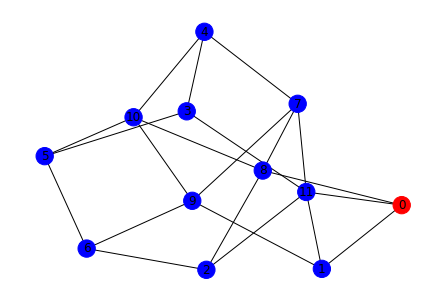

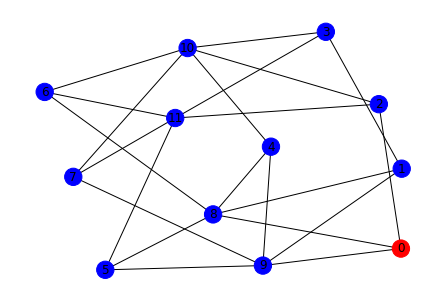

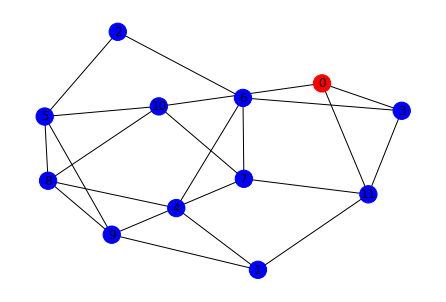

In [6]:
g_subthresh = best_12[12][0][0]
g_thresh = best_12[12][2][0]
g_dist = best_12[12][4][0]
for e in (g_subthresh, g_thresh, g_dist):
    g = Graph()
    g.add_nodes_from(list(range(12)))
    g.add_edges_from(e)
    draw_graph(g)

In [8]:
print(len(x))
print(x[0])

2893
(EdgeView([(0, 7), (1, 11), (2, 10), (3, 6), (3, 11), (3, 5), (4, 11), (4, 8), (4, 6), (5, 9), (5, 11), (6, 9), (7, 10), (7, 8), (8, 10), (8, 9), (9, 10)]), {(3, 0): 1, (3, 1): 1, (5, 2): 2, (7, 3): 5, (7, 4): 6, (6, 4): 3, (6, 3): 3, (4, 1): 1, (6, 2): 2, (6, 5): 1, (5, 3): 2})


In [9]:
best5_9 = get_best_perf(5, 9, eta=0.99)

3000

In [7]:
best12_latest = get_best_perf(12, 12, prefix_num=50, printing=False)

100%|██████████| 103/103 [01:03<00:00,  1.61it/s]

((EdgeView([(0, 8), (0, 11), (0, 1), (0, 2), (1, 3), (1, 8), (1, 11), (2, 9), (2, 10), (2, 3), (3, 9), (3, 10), (4, 7), (4, 8), (4, 10), (4, 9), (5, 11), (5, 6), (5, 9), (5, 8), (6, 10), (6, 11), (6, 8), (7, 9), (7, 10), (7, 11)]), {(5, 0): 1, (6, 1): 3, (7, 2): 12, (8, 3): 21, (7, 3): 31, (6, 2): 6, (6, 3): 7, (5, 1): 1, (5, 2): 1, (5, 3): 1, (7, 1): 1, (8, 2): 1, (7, 4): 18}), 0.999991729128888, (EdgeView([(0, 1), (0, 10), (1, 11), (2, 10), (2, 11), (3, 8), (3, 9), (4, 11), (4, 8), (5, 10), (5, 9), (6, 9), (6, 8), (6, 11), (7, 10), (7, 9), (7, 11)]), {(3, 0): 1, (3, 1): 2, (4, 2): 2, (5, 3): 3, (6, 4): 3, (6, 5): 12, (5, 6): 27, (5, 5): 12, (5, 4): 9, (4, 5): 2, (4, 3): 4, (4, 4): 3, (5, 2): 1, (6, 3): 1, (7, 4): 1, (7, 1): 1, (8, 2): 3, (8, 3): 8, (7, 2): 1}), 0.6228808593749999, (EdgeView([(0, 8), (0, 11), (0, 1), (0, 2), (1, 3), (1, 8), (1, 11), (2, 9), (2, 10), (2, 3), (3, 9), (3, 10), (4, 7), (4, 8), (4, 10), (4, 9), (5, 11), (5, 6), (5, 9), (5, 8), (6, 10), (6, 11), (6, 8), (7,

In [12]:
def success_prob(expr, eta):
    return sum([expr[k] * eta ** sum(k[0::3]) * (1 - eta) ** sum(k[2::3]) for k in expr.keys()])


  0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ip19160\PycharmProjects\LTdecode\graph_finding.py:380: RuntimeWarning: divide by zero encountered in log10
  dist = (np.log10(l1e3) - np.log10(l1e5)) / 2
100%|██████████| 1/1 [00:00<00:00, 199.98it/s]


((EdgeView([(0, 1), (0, 2), (1, 3), (2, 4), (3, 4)]), {(0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0): 1, (0, 0, 0, 1, 0, 1, 2, 0, 0, 0, 0, 0): 1, (0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0): 1}, {(1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0): 1, (1, 0, 1, 0, 0, 0, 2, 0, 0, 0, 0, 0): 1, (1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0): 1}, {(1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0): 1, (2, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0): 1, (1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0): 1}), 0.99960399, (EdgeView([(0, 1), (0, 2), (1, 3), (2, 4), (3, 4)]), {(0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0): 1, (0, 0, 0, 1, 0, 1, 2, 0, 0, 0, 0, 0): 1, (0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0): 1}, {(1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0): 1, (1, 0, 1, 0, 0, 0, 2, 0, 0, 0, 0, 0): 1, (1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0): 1}, {(1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0): 1, (2, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0): 1, (1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0): 1}), 0.6177832031249999, (EdgeView([(0, 1), (0, 2), (1, 3), (2, 4), (3, 4)]), {(0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0): 1, (0, 0, 0, 1, 0

100%|██████████| 1/1 [00:00<00:00,  4.51it/s]


((EdgeView([(0, 1), (0, 4), (1, 5), (2, 4), (2, 5), (3, 5)]), {(0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0): 1, (1, 0, 0, 2, 0, 1, 0, 0, 0, 0, 0, 0): 1, (2, 0, 0, 1, 0, 2, 0, 0, 0, 0, 0, 0): 1, (0, 0, 0, 1, 0, 1, 2, 0, 0, 0, 0, 0): 1}, {(1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0): 1, (0, 0, 1, 2, 0, 0, 1, 0, 0, 0, 0, 0): 1, (1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0): 1, (1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0): 1}, {(1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0): 1, (1, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0): 1, (2, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0): 1, (1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0): 1, (2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0): 1}), 0.9996030099, (EdgeView([(0, 1), (0, 4), (1, 5), (2, 4), (2, 5), (3, 5)]), {(0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0): 1, (1, 0, 0, 2, 0, 1, 0, 0, 0, 0, 0, 0): 1, (2, 0, 0, 1, 0, 2, 0, 0, 0, 0, 0, 0): 1, (0, 0, 0, 1, 0, 1, 2, 0, 0, 0, 0, 0): 1}, {(1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0): 1, (0, 0, 1, 2, 0, 0, 1, 0, 0, 0, 0, 0): 1, (1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0): 1, (1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0,

100%|██████████| 1/1 [00:00<00:00, 26.10it/s]


((EdgeView([(0, 5), (0, 1), (1, 6), (2, 3), (2, 6), (3, 5), (4, 6), (4, 5)]), {(0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0): 1, (1, 0, 0, 2, 0, 1, 0, 0, 0, 0, 0, 0): 1, (2, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0): 1, (1, 0, 1, 2, 0, 1, 0, 0, 0, 0, 0, 0): 1, (0, 0, 0, 1, 0, 1, 2, 0, 0, 0, 0, 0): 1, (2, 0, 0, 1, 0, 2, 0, 0, 0, 0, 0, 0): 1}, {(1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0): 1, (0, 0, 1, 2, 0, 0, 1, 0, 0, 0, 0, 0): 1, (0, 0, 1, 1, 0, 1, 3, 0, 0, 0, 0, 0): 1, (0, 0, 1, 0, 0, 1, 3, 0, 0, 0, 0, 0): 1, (2, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0): 1, (0, 0, 0, 0, 0, 0, 3, 0, 2, 0, 0, 0): 1}, {(1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0): 1, (2, 0, 0, 2, 0, 1, 0, 0, 0, 0, 0, 0): 1, (2, 0, 1, 2, 0, 1, 0, 0, 0, 0, 0, 0): 1, (2, 0, 0, 1, 0, 2, 0, 0, 0, 0, 0, 0): 2, (1, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0): 1, (1, 0, 1, 0, 0, 1, 2, 0, 0, 0, 0, 0): 1}), 0.999796099401, (EdgeView([(0, 5), (0, 1), (1, 6), (2, 3), (2, 6), (3, 5), (4, 6), (4, 5)]), {(0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0): 1, (1, 0, 0, 2, 0, 1, 0, 0, 0, 0, 0, 0): 1, (

100%|██████████| 1/1 [00:00<00:00,  3.68it/s]


((EdgeView([(0, 1), (0, 2), (0, 3), (1, 5), (1, 6), (2, 7), (2, 5), (3, 6), (3, 7), (4, 5), (4, 6), (4, 7)]), {(0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0): 1, (1, 0, 0, 3, 0, 1, 0, 0, 0, 0, 0, 0): 1, (1, 0, 1, 3, 0, 1, 0, 0, 0, 0, 0, 0): 3, (2, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0): 3, (2, 0, 1, 2, 0, 2, 0, 0, 0, 0, 0, 0): 6, (1, 0, 0, 2, 0, 1, 0, 0, 0, 0, 0, 0): 2, (2, 0, 0, 1, 0, 3, 0, 0, 0, 0, 0, 0): 3, (1, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0): 1}, {(0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0): 1, (0, 0, 0, 0, 0, 0, 4, 0, 1, 0, 0, 0): 1, (0, 0, 0, 0, 0, 0, 4, 0, 2, 0, 0, 0): 5, (0, 0, 0, 0, 0, 0, 4, 0, 3, 0, 0, 0): 6, (0, 0, 0, 0, 0, 0, 3, 0, 1, 0, 0, 0): 2, (0, 0, 0, 0, 0, 0, 3, 0, 3, 0, 0, 0): 2, (0, 0, 0, 0, 0, 0, 3, 0, 2, 0, 0, 0): 2}, {(1, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0): 1, (2, 0, 0, 2, 0, 1, 0, 0, 0, 0, 0, 0): 2, (4, 0, 0, 1, 0, 2, 0, 0, 0, 0, 0, 0): 2, (3, 0, 1, 1, 0, 2, 0, 0, 0, 0, 0, 0): 5, (2, 0, 1, 2, 0, 1, 0, 0, 0, 0, 0, 0): 2, (3, 0, 0, 1, 0, 2, 0, 0, 0, 0, 0, 0): 1, (4, 0, 0, 0, 0, 3, 0, 0,

100%|██████████| 1/1 [00:02<00:00,  2.62s/it]

((EdgeView([(0, 5), (0, 8), (0, 6), (1, 8), (2, 7), (2, 5), (2, 8), (3, 6), (3, 7), (3, 8), (4, 7), (4, 5), (4, 6)]), {(0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0): 1, (1, 0, 0, 3, 0, 1, 0, 0, 0, 0, 0, 0): 1, (2, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0): 4, (1, 0, 1, 3, 0, 1, 0, 0, 0, 0, 0, 0): 2, (2, 0, 1, 2, 0, 2, 0, 0, 0, 0, 0, 0): 4, (1, 0, 0, 2, 0, 1, 0, 0, 0, 0, 0, 0): 2, (3, 0, 0, 1, 0, 3, 0, 0, 0, 0, 0, 0): 2, (2, 0, 1, 1, 0, 2, 0, 0, 0, 0, 0, 0): 3, (4, 0, 0, 1, 0, 3, 0, 0, 0, 0, 0, 0): 2, (3, 0, 1, 1, 0, 3, 0, 0, 0, 0, 0, 0): 5, (4, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0): 1, (3, 0, 1, 0, 0, 3, 0, 0, 0, 0, 0, 0): 1, (1, 0, 1, 2, 0, 1, 0, 0, 0, 0, 0, 0): 1, (2, 0, 2, 2, 0, 2, 0, 0, 0, 0, 0, 0): 2, (1, 0, 2, 2, 0, 1, 0, 0, 0, 0, 0, 0): 1, (2, 0, 2, 1, 0, 2, 0, 0, 0, 0, 0, 0): 1}, {(0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0): 1, (0, 0, 0, 0, 0, 0, 4, 0, 1, 0, 0, 0): 1, (0, 0, 0, 0, 0, 0, 4, 0, 2, 0, 0, 0): 3, (0, 0, 0, 1, 0, 0, 4, 0, 2, 0, 0, 0): 2, (0, 0, 0, 1, 0, 0, 4, 0, 3, 0, 0, 0): 6, (0, 0, 0, 0, 0, 0,

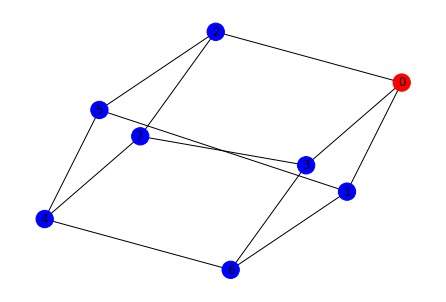

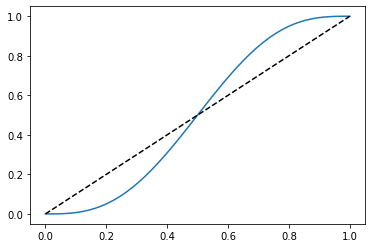

In [13]:
etas = np.linspace(0, 1)
best5_9_pauli = get_best_perf(5, 9, printing=False, pauli=True)
graph_subthresh = best5_9_pauli[8][0]
draw_graph(graph_subthresh[0], from_edges=True)
plt.plot(etas, [success_prob(graph_subthresh[1], t) for t in etas])
plt.plot(etas, etas, 'k--')
plt.show()

In [19]:
perf = load_obj('best_pauli_graphs_5-11_qubits', getcwd())
new_dict = {}
for k in range(5, 12):
    new_dict[k] = (perf[k][0], perf[k][2])
print(new_dict)
new_dict[7][0]

{5: ((EdgeView([(0, 1), (0, 2), (1, 3), (2, 4), (3, 4)]), {(0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0): 1, (0, 0, 0, 1, 0, 1, 2, 0, 0, 0, 0, 0): 1, (0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0): 1}, {(1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0): 1, (1, 0, 1, 0, 0, 0, 2, 0, 0, 0, 0, 0): 1, (1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0): 1}, {(1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0): 1, (2, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0): 1, (1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0): 1}), (EdgeView([(0, 1), (0, 2), (1, 3), (2, 4), (3, 4)]), {(0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0): 1, (0, 0, 0, 1, 0, 1, 2, 0, 0, 0, 0, 0): 1, (0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0): 1}, {(1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0): 1, (1, 0, 1, 0, 0, 0, 2, 0, 0, 0, 0, 0): 1, (1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0): 1}, {(1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0): 1, (2, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0): 1, (1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0): 1})), 6: ((EdgeView([(0, 1), (0, 4), (1, 5), (2, 4), (2, 5), (3, 5)]), {(0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0): 1, (1, 0, 0, 2, 0, 1, 0, 0, 0, 0

(EdgeView([(0, 5), (0, 1), (1, 6), (2, 3), (2, 6), (3, 5), (4, 6), (4, 5)]),
 {(0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0): 1,
  (1, 0, 0, 2, 0, 1, 0, 0, 0, 0, 0, 0): 1,
  (2, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0): 1,
  (1, 0, 1, 2, 0, 1, 0, 0, 0, 0, 0, 0): 1,
  (0, 0, 0, 1, 0, 1, 2, 0, 0, 0, 0, 0): 1,
  (2, 0, 0, 1, 0, 2, 0, 0, 0, 0, 0, 0): 1},
 {(1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0): 1,
  (0, 0, 1, 2, 0, 0, 1, 0, 0, 0, 0, 0): 1,
  (0, 0, 1, 1, 0, 1, 3, 0, 0, 0, 0, 0): 1,
  (0, 0, 1, 0, 0, 1, 3, 0, 0, 0, 0, 0): 1,
  (2, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0): 1,
  (0, 0, 0, 0, 0, 0, 3, 0, 2, 0, 0, 0): 1},
 {(1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0): 1,
  (2, 0, 0, 2, 0, 1, 0, 0, 0, 0, 0, 0): 1,
  (2, 0, 1, 2, 0, 1, 0, 0, 0, 0, 0, 0): 1,
  (2, 0, 0, 1, 0, 2, 0, 0, 0, 0, 0, 0): 2,
  (1, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0): 1,
  (1, 0, 1, 0, 0, 1, 2, 0, 0, 0, 0, 0): 1})

100%|██████████| 1/1 [00:00<00:00, 83.38it/s]

Graphs loaded, filesize=21368
0.9899000199
0.9994079700000001
0.9899000199
0.9896079501
0.9992139102000002
0.9993109401000001
0.9896079501
0.9799049601
0.9897059601
0.9896079501
0.9897059601
0.9799049601
0.9992139102
0.9898020099000001
0.9899980299000001
0.9899980299000001
0.9898020099000001
0.9702019701
0.9899999901000001
0.9899999901000001
0.9702019701
0.9896079501
0.9896079501
0.9896079501
0.9898020099000001
0.9898020099000001
0.9800990199
0.9800990199
0.9509900498999999
0.9509900498999999
0.9990198504000001
File number #0 complete, current bests: max_subthresh=0.9994079700000001, min_threshold=0.767314453125, max_dist=1.9997132609029769
((EdgeView([(0, 3), (0, 4), (1, 5), (2, 4), (3, 5)]), [{(2, 0, 0, 0, 0, 0, 1, 0): 1, (1, 1, 1, 0, 0, 0, 1, 0): 2, (0, 2, 2, 0, 0, 0, 1, 0): 1, (0, 0, 0, 0, 3, 0, 1, 1): 1}]), 0.9994079700000001, (EdgeView([(0, 3), (0, 4), (1, 5), (2, 4), (3, 5)]), [{(2, 0, 0, 0, 0, 0, 1, 0): 1, (1, 1, 1, 0, 0, 0, 1, 0): 2, (0, 2, 2, 0, 0, 0, 1, 0): 1, (0, 0, 0, 0, 3

In [4]:

graphs = get_best_perf(6, 6, printing=True)
print(graphs)

100%|██████████| 1/1 [00:00<00:00, 166.73it/s]

Graphs loaded, filesize=21368
0.9899000199
0.9994079700000001
0.9899000199
0.9896079501
0.9992139102000002
0.9993109401000001
0.9896079501
0.9799049601
0.9897059601
0.9896079501
0.9897059601
0.9799049601
0.9992139102
0.9898020099000001
0.9899980299000001
0.9899980299000001
0.9898020099000001
0.9702019701
0.9899999901000001
0.9899999901000001
0.9702019701
0.9896079501
0.9896079501
0.9896079501
0.9898020099000001
0.9898020099000001
0.9800990199
0.9800990199
0.9509900498999999
0.9509900498999999
0.9990198504000001
File number #0 complete, current bests: max_subthresh=0.9994079700000001, min_threshold=0.767314453125, max_dist=1.9997132609029769
((EdgeView([(0, 3), (0, 4), (1, 5), (2, 4), (3, 5)]), [{(2, 0, 0, 0, 0, 0, 1, 0): 1, (1, 1, 1, 0, 0, 0, 1, 0): 2, (0, 2, 2, 0, 0, 0, 1, 0): 1, (0, 0, 0, 0, 3, 0, 1, 1): 1}]), 0.9994079700000001, (EdgeView([(0, 3), (0, 4), (1, 5), (2, 4), (3, 5)]), [{(2, 0, 0, 0, 0, 0, 1, 0): 1, (1, 1, 1, 0, 0, 0, 1, 0): 2, (0, 2, 2, 0, 0, 0, 1, 0): 1, (0, 0, 0, 0, 3

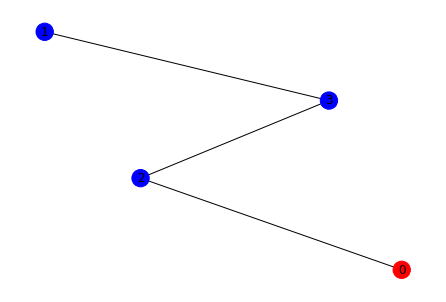

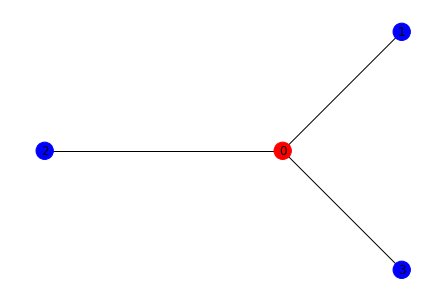

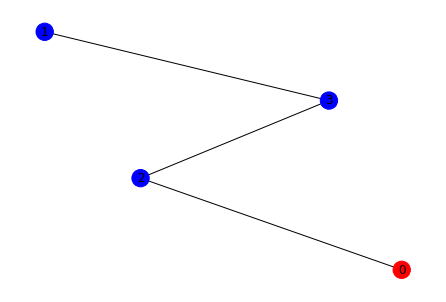

0.989901


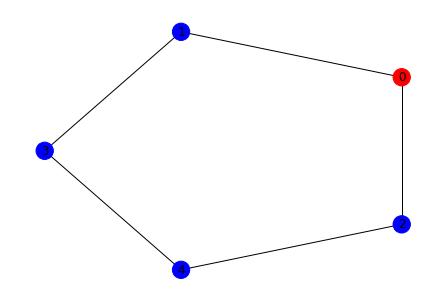

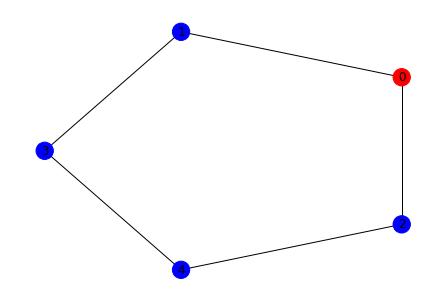

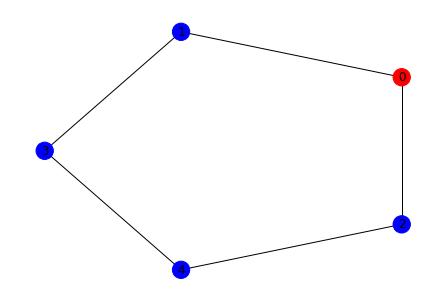

0.9994079699999999


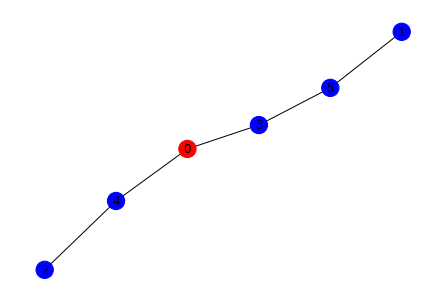

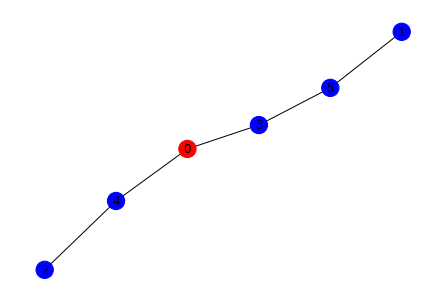

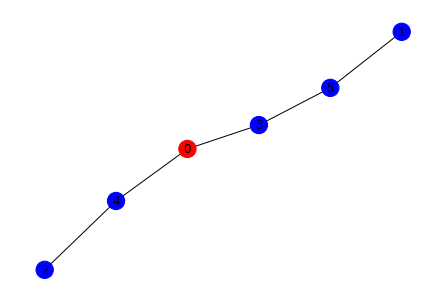

0.9994079700000001


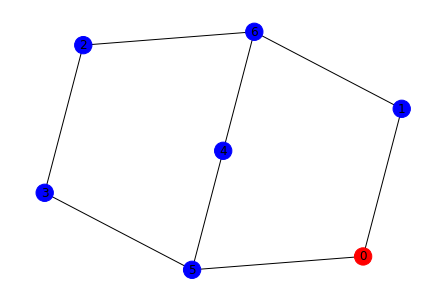

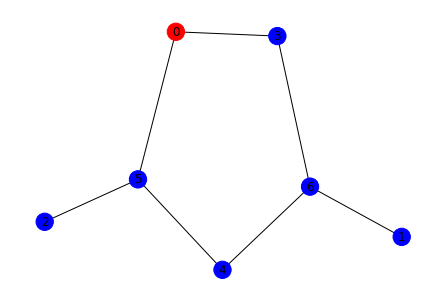

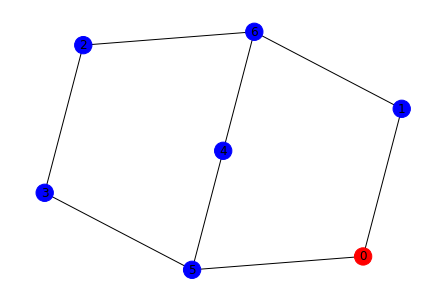

0.999695178504


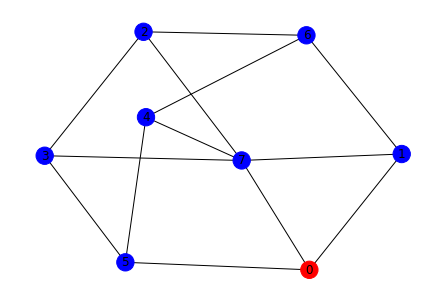

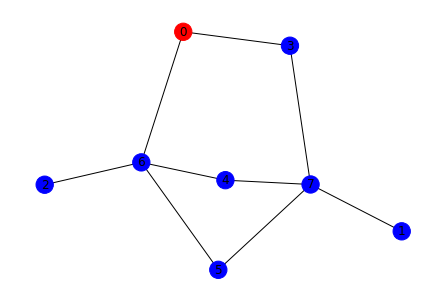

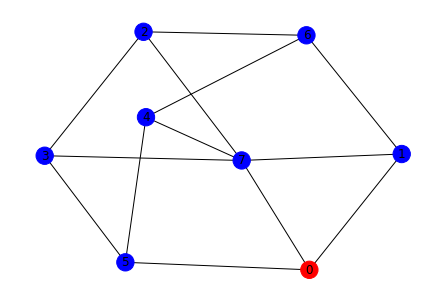

0.9999775646219701


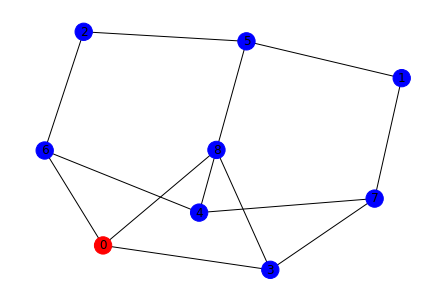

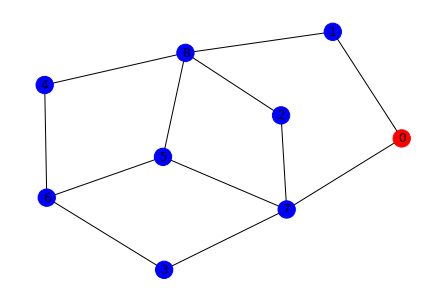

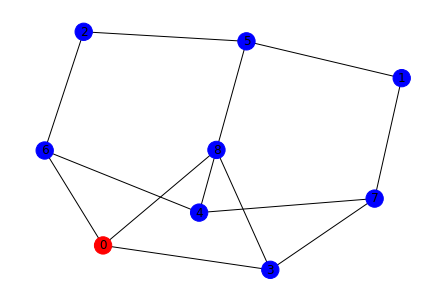

0.9999803599563594


In [6]:
for nq in range(4, 10):
    draw_graph(graphs[nq][0][0], from_edges=True)
    draw_graph(graphs[nq][2][0], from_edges=True)

    draw_graph(graphs[nq][4][0], from_edges=True)

    g = graphs[nq][0][0]
    gr = Graph()
    gr.add_nodes_from(list(range(nq)))
    gr.add_edges_from(g)
    dec = FastDecoder(gr)
    dec.get_dict()
    print(dec.success_prob(0.99))

In [2]:
x = load_obj('6_qubit_graphs_ordered_num_in_class', getcwd()+'/data/uib_data')

In [3]:
print(len(x))

31


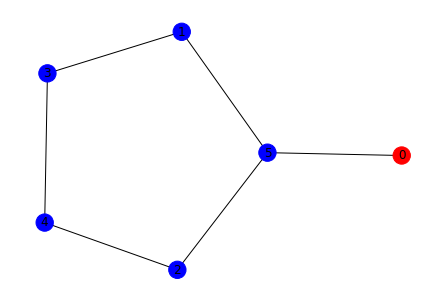

success_pattern=[1, 1, 1]
self.strat.pauli.to_str()='Z3_Z4_X3_X4'
self.strat.s1.to_str()='Z3_Z4_X3_X4'
self.strat.s2.to_str()='-_Z3_Z4_X3_X4'
self.pauli_done.to_str()='Z3_Z4_X3_X4'
self.arb_meas=[5]
self.q_lost=[]


success_pattern=[1, 1, 0, 1, 1]
self.strat.pauli.to_str()='Z1_Z2'
self.strat.s1.to_str()='-_Z1_Z2'
self.strat.s2.to_str()='Z1_Z2'
self.pauli_done.to_str()='Z1_Z2_Z3_X3'
self.arb_meas=[5]
self.q_lost=[4]


success_pattern=[1, 0, 1, 1]
self.strat.pauli.to_str()='Z1_Z2'
self.strat.s1.to_str()='-_Z1_Z2'
self.strat.s2.to_str()='Z1_Z2'
self.pauli_done.to_str()='Z1_Z2'
self.arb_meas=[5]
self.q_lost=[3]


0.9896079501


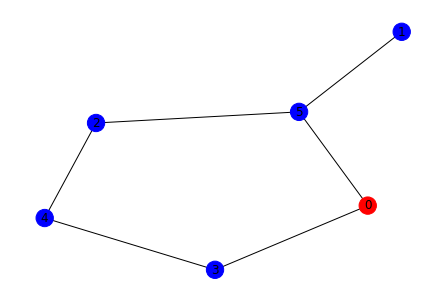

success_pattern=[1, 1, 1]
self.strat.pauli.to_str()='Z2_X2_X3'
self.strat.s1.to_str()='-_Z2_X2_X3'
self.strat.s2.to_str()='X3'
self.pauli_done.to_str()='Z2_X2_X3'
self.arb_meas=[4]
self.q_lost=[]


success_pattern=[1, 1, 0, 1, 1]
self.strat.pauli.to_str()='Z1_Z2_X1_X2_X5'
self.strat.s1.to_str()='Z1_X1_X5'
self.strat.s2.to_str()='Z1_Z2_X1_X2_X5'
self.pauli_done.to_str()='Z1_Z2_X1_X2_X5'
self.arb_meas=[4]
self.q_lost=[3]


success_pattern=[1, 0, 1, 1, 1]
self.strat.pauli.to_str()='Z1_X1_X3_X5'
self.strat.s1.to_str()='Z1_X1_X5'
self.strat.s2.to_str()='X3'
self.pauli_done.to_str()='Z1_X1_X3_X5'
self.arb_meas=[4]
self.q_lost=[2]


success_pattern=[0, 1, 1, 1, 1]
self.strat.pauli.to_str()='Z2_Z3_Z5_X5'
self.strat.s1.to_str()='-_Z2_Z3_Z5_X5'
self.strat.s2.to_str()='-_Z2_Z5_X5'
self.pauli_done.to_str()='Z2_Z3_Z5_X5'
self.arb_meas=[1]
self.q_lost=[4]


success_pattern=[0, 0, 1, 1, 1]
self.strat.pauli.to_str()='Z5_X2'
self.strat.s1.to_str()='-_X2'
self.strat.s2.to_str()='Z5_X2'
self.pauli_done.t

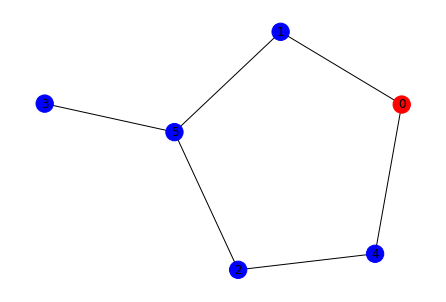

success_pattern=[1, 1, 1]
self.strat.pauli.to_str()='Z1_Z2'
self.strat.s1.to_str()='-_Z1_Z2'
self.strat.s2.to_str()='Z2'
self.pauli_done.to_str()='Z1_Z2'
self.arb_meas=[4]
self.q_lost=[]


success_pattern=[1, 1, 0, 1, 1]
self.strat.pauli.to_str()='Z1_Z3_Z5_X3_X5'
self.strat.s1.to_str()='Z3_Z5_X3_X5'
self.strat.s2.to_str()='-_Z1_Z3_Z5_X3_X5'
self.pauli_done.to_str()='Z1_Z3_Z5_X3_X5'
self.arb_meas=[4]
self.q_lost=[2]


success_pattern=[1, 0, 1, 1, 1]
self.strat.pauli.to_str()='Z2_Z3_Z5_X3_X5'
self.strat.s1.to_str()='Z3_Z5_X3_X5'
self.strat.s2.to_str()='Z2'
self.pauli_done.to_str()='Z2_Z3_Z5_X3_X5'
self.arb_meas=[4]
self.q_lost=[1]


success_pattern=[0, 1, 1, 1]
self.strat.pauli.to_str()='X2_X3'
self.strat.s1.to_str()='-_X2'
self.strat.s2.to_str()='X3'
self.pauli_done.to_str()='X2_X3'
self.arb_meas=[1]
self.q_lost=[4]


success_pattern=[0, 1, 1, 0, 1]
self.strat.pauli.to_str()='Z5_X2'
self.strat.s1.to_str()='-_X2'
self.strat.s2.to_str()='Z5'
self.pauli_done.to_str()='Z5_X2'
self.arb_meas=

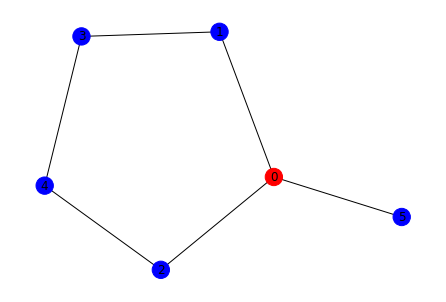

success_pattern=[1, 1, 1]
self.strat.pauli.to_str()='Z3_Z4_X3_X4'
self.strat.s1.to_str()='Z3_Z4_X3_X4'
self.strat.s2.to_str()=''
self.pauli_done.to_str()='Z3_Z4_X3_X4'
self.arb_meas=[5]
self.q_lost=[]


success_pattern=[1, 1, 0, 1, 1]
self.strat.pauli.to_str()='Z1_Z2'
self.strat.s1.to_str()='-_Z1_Z2'
self.strat.s2.to_str()=''
self.pauli_done.to_str()='Z1_Z2_Z3_X3'
self.arb_meas=[5]
self.q_lost=[4]


success_pattern=[1, 0, 1, 1]
self.strat.pauli.to_str()='Z1_Z2'
self.strat.s1.to_str()='-_Z1_Z2'
self.strat.s2.to_str()=''
self.pauli_done.to_str()='Z1_Z2'
self.arb_meas=[5]
self.q_lost=[3]


0.9896079501


In [23]:
for e in x[3:7]:
    draw_graph(e[1], from_edges=True)
    gr = Graph()
    # gr.add_nodes_from(list(range(6)))
    gr.add_edges_from(e[1])
    dec = FastDecoder(gr)
    dec.build_tree(printing=True)
    dec.get_dict()
    # print(dec.success_prob_outcome_list(0.99, 0, ec=False))
    print(dec.success_prob(0.99))

In [15]:
x = load_obj('graph_performance_batch9', getcwd() + '/graphs_batched_10'
                                                    'q')
print(x[0])

(EdgeView([(0, 7), (1, 9), (2, 3), (2, 4), (3, 5), (4, 8), (4, 9), (5, 6), (5, 8), (6, 7), (6, 8), (7, 9), (8, 9)]), {(1, 0, 1, 0, 0, 0, 1, 0): 1, (2, 0, 0, 1, 2, 0, 1, 0): 1, (3, 0, 0, 1, 2, 1, 1, 0): 1, (2, 1, 0, 1, 2, 0, 1, 0): 1, (2, 0, 0, 1, 2, 1, 1, 0): 1, (2, 0, 2, 1, 0, 2, 1, 0): 1, (0, 1, 2, 0, 0, 0, 1, 0): 1, (1, 1, 1, 1, 2, 0, 1, 0): 1, (2, 1, 1, 1, 2, 1, 1, 0): 1, (1, 2, 1, 1, 2, 0, 1, 0): 1, (1, 1, 1, 1, 2, 1, 1, 0): 1, (1, 1, 3, 1, 0, 2, 1, 0): 1, (1, 1, 0, 1, 2, 0, 1, 0): 1, (2, 1, 0, 1, 2, 1, 1, 0): 1, (1, 2, 0, 1, 2, 0, 1, 0): 1, (1, 1, 0, 1, 2, 1, 1, 0): 1, (1, 1, 2, 1, 0, 2, 1, 0): 1})


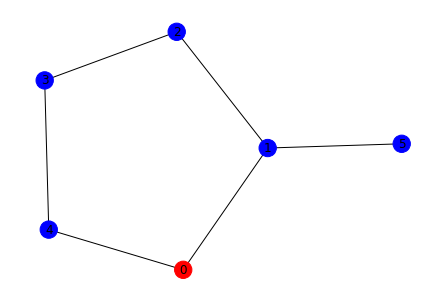

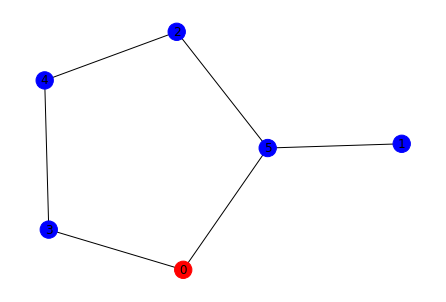

success_pattern=[1, 1, 1]
self.strat.pauli.to_str()='Z4_Z5'
self.strat.s1.to_str()='-_Z4_Z5'
self.strat.s2.to_str()='Z4'
self.pauli_done.to_str()='Z4_Z5'
self.arb_meas=[3]
self.q_lost=[]


success_pattern=[1, 1, 0, 1]
self.strat.pauli.to_str()='Z4_X1'
self.strat.s1.to_str()='-_Z4_X1'
self.strat.s2.to_str()='Z4'
self.pauli_done.to_str()='Z4_X1'
self.arb_meas=[3]
self.q_lost=[5]


success_pattern=[1, 1, 0, 0, 1]
self.strat.pauli.to_str()='Z4_X2'
self.strat.s1.to_str()='-_X2'
self.strat.s2.to_str()='Z4'
self.pauli_done.to_str()='Z4_X2'
self.arb_meas=[3]
self.q_lost=[5, 1]


success_pattern=[1, 0, 1, 1]
self.strat.pauli.to_str()='Z5_X2'
self.strat.s1.to_str()='-_X2'
self.strat.s2.to_str()='Z5_X2'
self.pauli_done.to_str()='Z5_X2'
self.arb_meas=[3]
self.q_lost=[4]


success_pattern=[1, 0, 1, 0, 1]
self.strat.pauli.to_str()='X1_X2'
self.strat.s1.to_str()='-_X2'
self.strat.s2.to_str()='X1_X2'
self.pauli_done.to_str()='X1_X2'
self.arb_meas=[3]
self.q_lost=[4, 5]


success_pattern=[0, 1, 1, 1, 1

In [2]:
g = gen_ring_graph(5)
g.add_edges_from([(1, 5)])
draw_graph(g)
mapping = {i: i for i in range(6)}
mapping[1] = 5
mapping[5] = 1
map2 = {0:0, 1:5, 2:2, 3:4, 4:3, 5:1}
# g2 = relabel_nodes(g, mapping)
# draw_graph(g2)
#
# dec = FastDecoder(g)
# dec.build_tree(printing=False)
# dec.get_dict()
# print(dec.success_prob(0.99))
#
# dec2 = CascadeDecoder(g)
# dec2.build_tree(cascading=False, printing=False)
# print(dec2.success_prob_outcome_list(0.99, 0, ec=False))
#
# dec = FastDecoder(g2)
# dec.get_dict()
# print(dec.success_prob(0.99))
#
# dec2 = CascadeDecoder(g2)
# dec2.build_tree(cascading=False, printing=True)
# print(dec2.success_prob_outcome_list(0.99, 0, ec=False))

g3 = relabel_nodes(g, map2)
draw_graph(g3)

dec = FastDecoder(g3)
dec.build_tree(printing=True)
dec.get_dict()
print(dec.success_prob(0.99))
print(dec.expr_dicts)


dec2 = CascadeDecoder(g3)
print([p.to_str() for p in dec2.stab_grp_nt])
dec2.build_tree(cascading=False, printing=True)
print(dec2.success_prob_outcome_list(0.99, 0, ec=False))

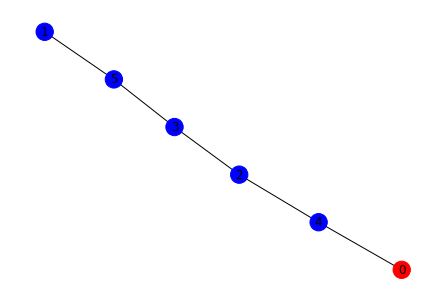

{(0, 0, 1, 0, 0, 0, 1, 0): 1, (2, 0, 0, 1, 0, 0, 1, 0): 1, (1, 1, 1, 1, 0, 0, 1, 0): 1}


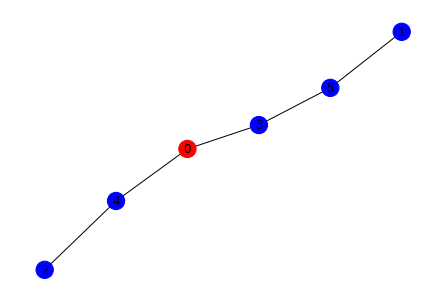

{(2, 0, 0, 0, 0, 0, 1, 0): 1, (1, 1, 1, 0, 0, 0, 1, 0): 2, (0, 2, 2, 0, 0, 0, 1, 0): 1, (0, 0, 0, 0, 3, 0, 1, 1): 1}


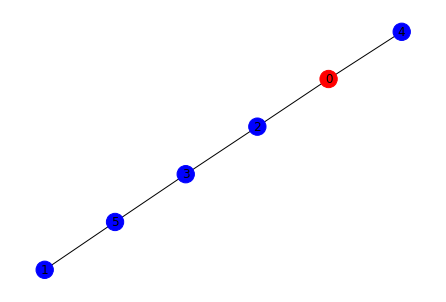

{(0, 0, 1, 0, 0, 0, 1, 0): 1, (2, 0, 0, 1, 0, 0, 1, 0): 1, (1, 1, 1, 1, 0, 0, 1, 0): 1}


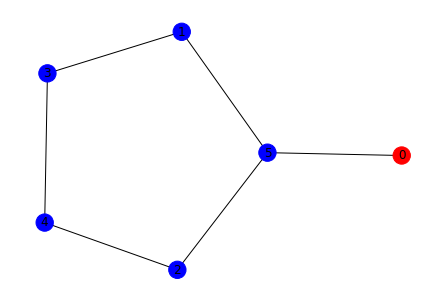

{(0, 0, 0, 0, 2, 0, 1, 0): 1, (0, 0, 2, 0, 1, 1, 1, 0): 1, (0, 0, 2, 0, 0, 1, 1, 0): 1}


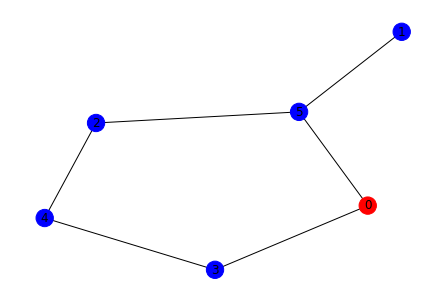

{(1, 0, 0, 0, 1, 0, 1, 0): 1, (1, 1, 0, 0, 2, 0, 1, 0): 1, (2, 0, 0, 0, 1, 1, 1, 0): 1, (0, 0, 2, 0, 1, 0, 1, 1): 1, (1, 0, 1, 0, 0, 0, 1, 2): 1}


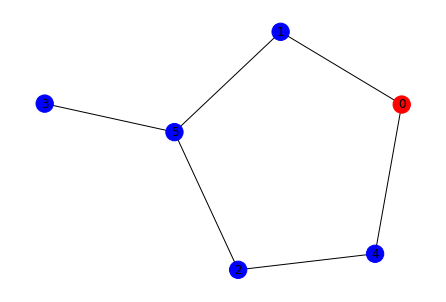

{(0, 0, 2, 0, 0, 0, 1, 0): 1, (0, 0, 1, 1, 2, 0, 1, 0): 2, (2, 0, 0, 0, 0, 0, 1, 1): 1, (1, 1, 1, 0, 0, 0, 1, 1): 1}


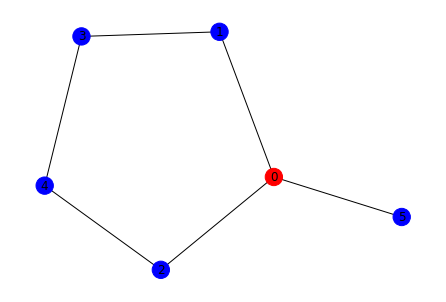

{(0, 0, 0, 0, 2, 0, 1, 0): 1, (0, 0, 2, 0, 1, 1, 1, 0): 1, (0, 0, 2, 0, 0, 1, 1, 0): 1}


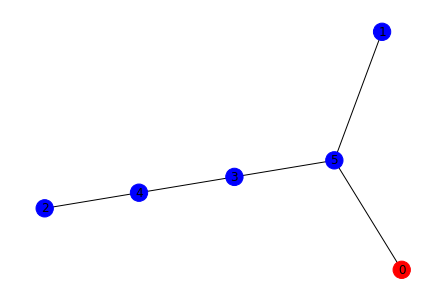

{(0, 0, 2, 0, 0, 0, 1, 0): 1, (0, 0, 1, 1, 2, 0, 1, 0): 1}


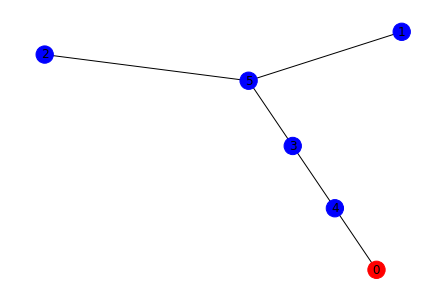

{(0, 0, 1, 0, 0, 0, 1, 0): 1, (1, 0, 0, 1, 2, 0, 1, 0): 1}


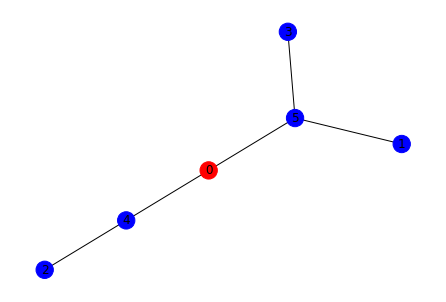

{(1, 0, 0, 0, 2, 0, 1, 0): 1, (0, 1, 1, 0, 2, 0, 1, 0): 1, (1, 0, 0, 0, 1, 1, 2, 0): 1, (1, 0, 0, 0, 1, 0, 1, 1): 1, (1, 1, 0, 0, 1, 0, 1, 1): 1}


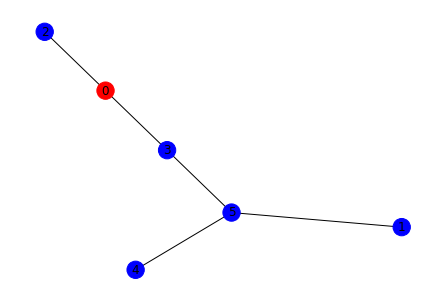

{(0, 0, 1, 0, 0, 0, 1, 0): 1, (1, 0, 0, 1, 2, 0, 1, 0): 1}


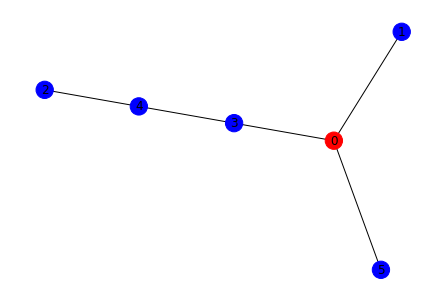

{(0, 0, 2, 0, 0, 0, 1, 0): 1, (0, 0, 1, 1, 2, 0, 1, 0): 1}


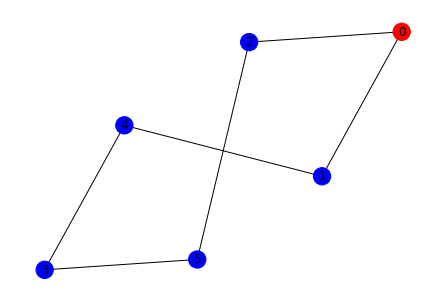

{(2, 0, 0, 0, 0, 0, 1, 0): 1, (1, 1, 0, 0, 2, 0, 1, 0): 1, (2, 1, 0, 0, 1, 0, 1, 0): 1, (0, 0, 2, 0, 0, 0, 1, 1): 1}


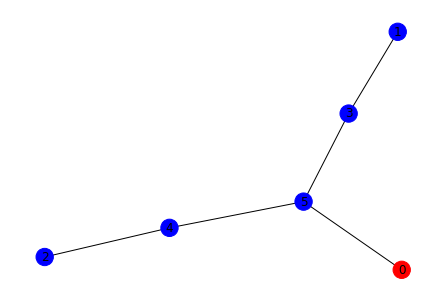

{(2, 0, 0, 0, 0, 0, 1, 0): 1, (1, 1, 1, 0, 0, 0, 1, 0): 2, (0, 2, 2, 0, 0, 0, 1, 0): 1}


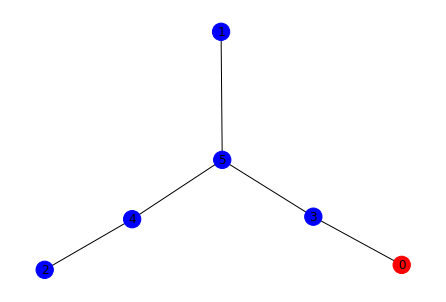

{(1, 0, 0, 0, 0, 0, 1, 0): 1, (0, 1, 1, 0, 0, 0, 1, 0): 1, (0, 1, 0, 1, 2, 0, 1, 0): 1}


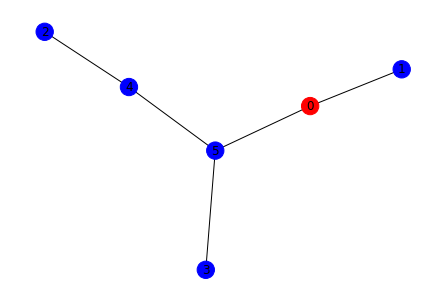

{(1, 0, 0, 0, 0, 0, 1, 0): 1, (0, 1, 1, 0, 0, 0, 1, 0): 1, (0, 1, 0, 1, 2, 0, 1, 0): 1}


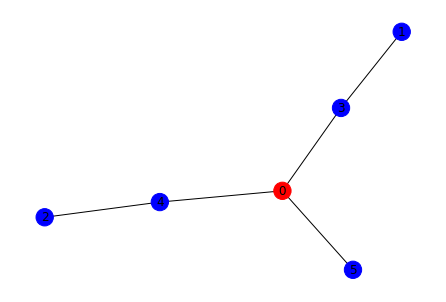

{(2, 0, 0, 0, 0, 0, 1, 0): 1, (1, 1, 1, 0, 0, 0, 1, 0): 2, (0, 2, 2, 0, 0, 0, 1, 0): 1}


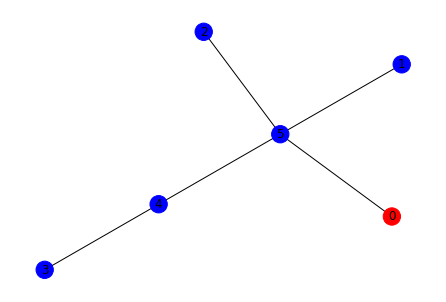

{(1, 0, 0, 0, 2, 0, 1, 0): 1, (0, 1, 1, 0, 2, 0, 1, 0): 1}


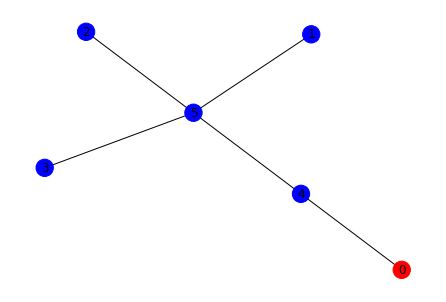

{(1, 0, 0, 0, 0, 0, 1, 0): 1, (1, 1, 0, 0, 0, 0, 1, 0): 1, (1, 2, 0, 0, 0, 0, 1, 0): 1, (0, 3, 1, 0, 0, 0, 1, 0): 1}


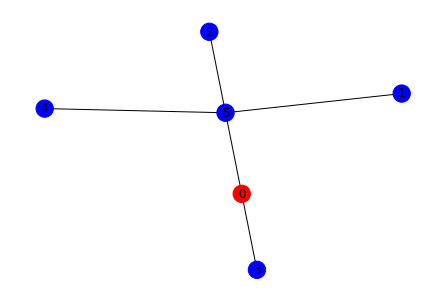

{(1, 0, 0, 0, 0, 0, 1, 0): 1, (1, 1, 0, 0, 0, 0, 1, 0): 1, (1, 2, 0, 0, 0, 0, 1, 0): 1, (0, 3, 1, 0, 0, 0, 1, 0): 1}


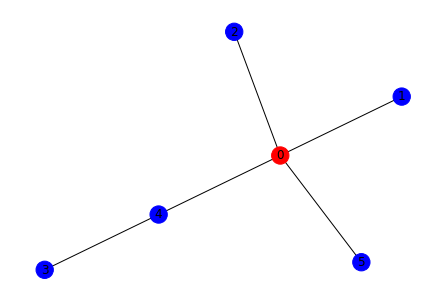

{(1, 0, 0, 0, 2, 0, 1, 0): 1, (0, 1, 1, 0, 2, 0, 1, 0): 1}


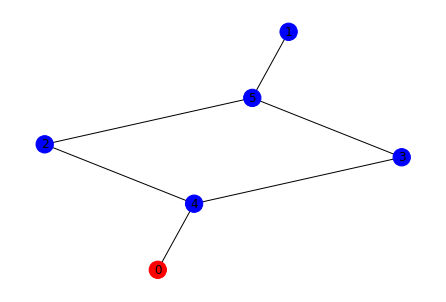

{(0, 0, 0, 0, 2, 0, 1, 0): 1, (0, 0, 0, 0, 3, 1, 1, 0): 1, (0, 0, 0, 0, 2, 1, 1, 0): 1}


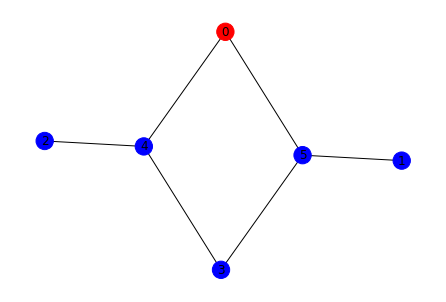

{(0, 0, 0, 0, 2, 0, 1, 0): 1, (0, 0, 0, 0, 3, 1, 1, 0): 1, (0, 0, 0, 0, 2, 1, 1, 0): 1}


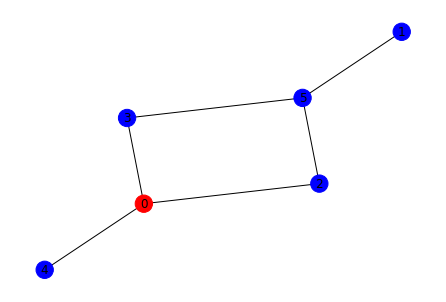

{(0, 0, 0, 0, 2, 0, 1, 0): 1, (0, 0, 0, 0, 3, 1, 1, 0): 1, (0, 0, 0, 0, 2, 1, 1, 0): 1}


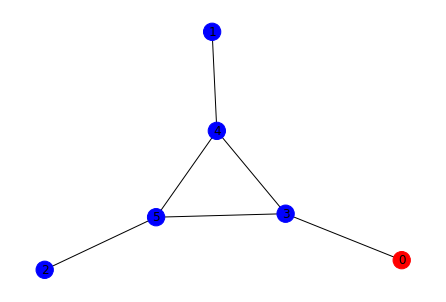

{(2, 0, 0, 0, 0, 0, 1, 0): 1, (1, 1, 1, 0, 0, 0, 1, 0): 2, (0, 2, 2, 0, 0, 0, 1, 0): 1}


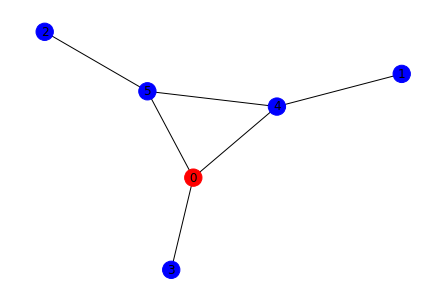

{(2, 0, 0, 0, 0, 0, 1, 0): 1, (1, 1, 1, 0, 0, 0, 1, 0): 2, (0, 2, 2, 0, 0, 0, 1, 0): 1}


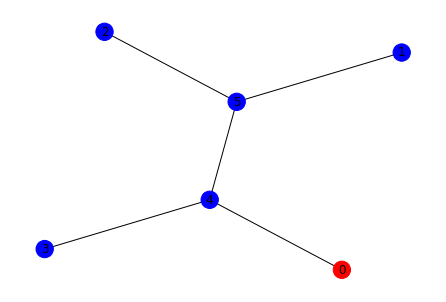

{(1, 0, 1, 0, 0, 0, 1, 0): 1, (1, 1, 1, 0, 0, 0, 1, 0): 1, (0, 2, 2, 0, 0, 0, 1, 0): 1}


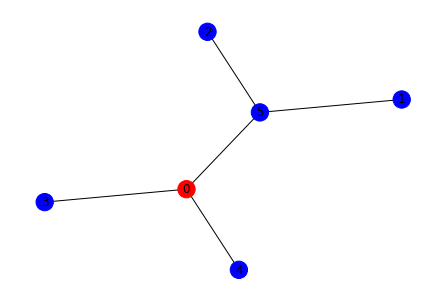

{(1, 0, 1, 0, 0, 0, 1, 0): 1, (1, 1, 1, 0, 0, 0, 1, 0): 1, (0, 2, 2, 0, 0, 0, 1, 0): 1}


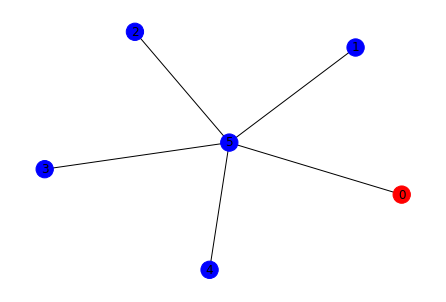

{(0, 0, 0, 0, 4, 0, 1, 0): 1}


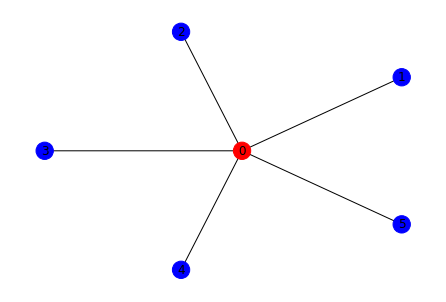

{(0, 0, 0, 0, 4, 0, 1, 0): 1}


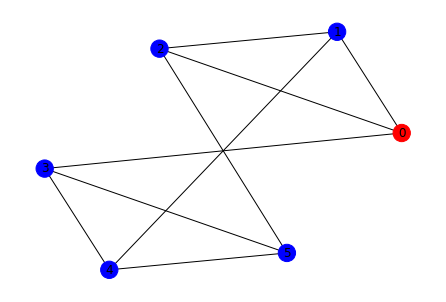

{(1, 0, 0, 0, 2, 0, 1, 0): 1, (0, 1, 1, 0, 2, 0, 1, 0): 1, (1, 0, 1, 0, 1, 1, 1, 0): 2, (0, 0, 3, 0, 0, 0, 1, 1): 1}
[(EdgeView([(0, 4), (1, 5), (2, 3), (2, 4), (3, 5)]), {(0, 0, 1, 0, 0, 0, 1, 0): 1, (2, 0, 0, 1, 0, 0, 1, 0): 1, (1, 1, 1, 1, 0, 0, 1, 0): 1}, 25), (EdgeView([(0, 3), (0, 4), (1, 5), (2, 4), (3, 5)]), {(2, 0, 0, 0, 0, 0, 1, 0): 1, (1, 1, 1, 0, 0, 0, 1, 0): 2, (0, 2, 2, 0, 0, 0, 1, 0): 1, (0, 0, 0, 0, 3, 0, 1, 1): 1}, 25), (EdgeView([(0, 4), (0, 2), (1, 5), (2, 3), (3, 5)]), {(0, 0, 1, 0, 0, 0, 1, 0): 1, (2, 0, 0, 1, 0, 0, 1, 0): 1, (1, 1, 1, 1, 0, 0, 1, 0): 1}, 25), (EdgeView([(0, 5), (1, 3), (1, 5), (2, 4), (2, 5), (3, 4)]), {(0, 0, 0, 0, 2, 0, 1, 0): 1, (0, 0, 2, 0, 1, 1, 1, 0): 1, (0, 0, 2, 0, 0, 1, 1, 0): 1}, 21), (EdgeView([(0, 3), (0, 5), (1, 5), (2, 4), (2, 5), (3, 4)]), {(1, 0, 0, 0, 1, 0, 1, 0): 1, (1, 1, 0, 0, 2, 0, 1, 0): 1, (2, 0, 0, 0, 1, 1, 1, 0): 1, (0, 0, 2, 0, 1, 0, 1, 1): 1, (1, 0, 1, 0, 0, 0, 1, 2): 1}, 21), (EdgeView([(0, 1), (0, 4), (1, 5), (2, 4), (

In [4]:
r = load_obj('6_qubit_performance', getcwd() + '/data/spc_data')
for g in r:
    draw_graph(g[0], from_edges=True)
    print(g[1])
print(r)

### Compare the new graph data to the old, see if one outperforms the other anywhere


In [2]:
old = get_best_perf(2, 9)
new = get_best_perf(2, 9, subdirname='new_data_11_10')

100%|██████████| 1/1 [00:00<00:00, 999.83it/s]


Graphs loaded, filesize=652
File number #0 complete, current bests: max_subthresh=0.99, min_threshold=1, max_dist=1.0000000000009883
((EdgeView([(0, 1)]), [{(0, 0, 0, 0, 0, 0, 1, 0): 1}]), 0.99, (EdgeView([(0, 1)]), [{(0, 0, 0, 0, 0, 0, 1, 0): 1}]), 1, (EdgeView([(0, 1)]), [{(0, 0, 0, 0, 0, 0, 1, 0): 1}]), 1.0000000000009883)


100%|██████████| 1/1 [00:00<00:00, 999.83it/s]


Graphs loaded, filesize=1280
File number #0 complete, current bests: max_subthresh=0.9801, min_threshold=1, max_dist=1
((EdgeView([(0, 1), (0, 2)]), [{(0, 0, 1, 0, 0, 0, 1, 0): 1}]), 0.9801, (EdgeView([(0, 1), (1, 2)]), [{(0, 0, 0, 0, 1, 0, 1, 0): 1}]), 1, None, 1)


100%|██████████| 1/1 [00:00<?, ?it/s]


Graphs loaded, filesize=2456
File number #0 complete, current bests: max_subthresh=0.989901, min_threshold=1, max_dist=1.0002146503701825
((EdgeView([(0, 2), (1, 3), (2, 3)]), [{(1, 0, 0, 0, 0, 0, 1, 0): 1, (0, 1, 1, 0, 0, 0, 1, 0): 1}]), 0.989901, (EdgeView([(0, 3), (0, 1), (0, 2)]), [{(0, 0, 0, 0, 2, 0, 1, 0): 1}]), 1, (EdgeView([(0, 2), (1, 3), (2, 3)]), [{(1, 0, 0, 0, 0, 0, 1, 0): 1, (0, 1, 1, 0, 0, 0, 1, 0): 1}]), 1.0002146503701825)


100%|██████████| 1/1 [00:00<00:00, 1000.07it/s]


Graphs loaded, filesize=6424
File number #0 complete, current bests: max_subthresh=0.9994079699999999, min_threshold=0.767314453125, max_dist=1.9997132609110237
((EdgeView([(0, 1), (0, 2), (1, 3), (2, 4), (3, 4)]), [{(1, 0, 0, 0, 1, 0, 1, 0): 1, (0, 1, 0, 0, 2, 0, 1, 0): 1, (1, 0, 0, 0, 1, 1, 1, 0): 1, (0, 0, 2, 0, 0, 0, 1, 1): 1}]), 0.9994079699999999, (EdgeView([(0, 1), (0, 2), (1, 3), (2, 4), (3, 4)]), [{(1, 0, 0, 0, 1, 0, 1, 0): 1, (0, 1, 0, 0, 2, 0, 1, 0): 1, (1, 0, 0, 0, 1, 1, 1, 0): 1, (0, 0, 2, 0, 0, 0, 1, 1): 1}]), 0.767314453125, (EdgeView([(0, 1), (0, 2), (1, 3), (2, 4), (3, 4)]), [{(1, 0, 0, 0, 1, 0, 1, 0): 1, (0, 1, 0, 0, 2, 0, 1, 0): 1, (1, 0, 0, 0, 1, 1, 1, 0): 1, (0, 0, 2, 0, 0, 0, 1, 1): 1}]), 1.9997132609110237)


100%|██████████| 1/1 [00:00<00:00, 333.33it/s]


Graphs loaded, filesize=21368
File number #0 complete, current bests: max_subthresh=0.9994079700000001, min_threshold=0.767314453125, max_dist=1.9997132609029769
((EdgeView([(0, 3), (0, 4), (1, 5), (2, 4), (3, 5)]), [{(2, 0, 0, 0, 0, 0, 1, 0): 1, (1, 1, 1, 0, 0, 0, 1, 0): 2, (0, 2, 2, 0, 0, 0, 1, 0): 1, (0, 0, 0, 0, 3, 0, 1, 1): 1}]), 0.9994079700000001, (EdgeView([(0, 3), (0, 4), (1, 5), (2, 4), (3, 5)]), [{(2, 0, 0, 0, 0, 0, 1, 0): 1, (1, 1, 1, 0, 0, 0, 1, 0): 2, (0, 2, 2, 0, 0, 0, 1, 0): 1, (0, 0, 0, 0, 3, 0, 1, 1): 1}]), 0.767314453125, (EdgeView([(0, 3), (0, 4), (1, 5), (2, 4), (3, 5)]), [{(2, 0, 0, 0, 0, 0, 1, 0): 1, (1, 1, 1, 0, 0, 0, 1, 0): 2, (0, 2, 2, 0, 0, 0, 1, 0): 1, (0, 0, 0, 0, 3, 0, 1, 1): 1}]), 1.9997132609029769)


100%|██████████| 1/1 [00:00<00:00, 21.28it/s]


Graphs loaded, filesize=97488
File number #0 complete, current bests: max_subthresh=0.999695178504, min_threshold=0.6812207031249999, max_dist=2.0003566770094254
((EdgeView([(0, 5), (0, 1), (1, 6), (2, 3), (2, 6), (3, 5), (4, 6), (4, 5)]), [{(1, 0, 1, 0, 0, 0, 1, 0): 1, (1, 0, 1, 1, 0, 0, 1, 0): 1, (2, 0, 1, 2, 0, 0, 1, 0): 1, (0, 1, 2, 0, 0, 0, 1, 0): 1, (0, 1, 1, 1, 2, 0, 1, 0): 2, (0, 0, 0, 0, 3, 0, 1, 1): 1, (2, 0, 1, 0, 0, 0, 1, 2): 1}]), 0.999695178504, (EdgeView([(0, 3), (0, 5), (1, 6), (2, 5), (3, 6), (4, 6), (4, 5)]), [{(2, 0, 0, 0, 0, 0, 1, 0): 1, (2, 1, 0, 0, 0, 0, 1, 0): 1, (1, 2, 1, 0, 0, 0, 1, 0): 2, (1, 1, 1, 0, 0, 0, 1, 0): 1, (2, 1, 0, 1, 0, 0, 1, 0): 1, (1, 2, 1, 1, 0, 0, 1, 0): 1, (0, 3, 2, 0, 0, 0, 1, 0): 1, (1, 0, 0, 0, 3, 0, 1, 1): 1}]), 0.6812207031249999, (EdgeView([(0, 5), (0, 1), (1, 6), (2, 3), (2, 6), (3, 5), (4, 6), (4, 5)]), [{(1, 0, 1, 0, 0, 0, 1, 0): 1, (1, 0, 1, 1, 0, 0, 1, 0): 1, (2, 0, 1, 2, 0, 0, 1, 0): 1, (0, 1, 2, 0, 0, 0, 1, 0): 1, (0, 1, 1, 1, 2,

100%|██████████| 1/1 [00:00<00:00, 12.35it/s]


Graphs loaded, filesize=582812
File number #0 complete, current bests: max_subthresh=0.9999775646219701, min_threshold=0.6512011718749999, max_dist=3.0006868886760607
((EdgeView([(0, 7), (0, 5), (0, 1), (1, 6), (1, 7), (2, 3), (2, 6), (2, 7), (3, 5), (3, 7), (4, 5), (4, 6), (4, 7)]), [{(3, 0, 0, 0, 0, 0, 1, 0): 1, (2, 1, 1, 0, 0, 0, 1, 0): 3, (4, 1, 0, 1, 0, 0, 1, 0): 2, (1, 2, 1, 0, 2, 0, 1, 0): 1, (3, 2, 1, 0, 0, 0, 1, 0): 2, (2, 1, 0, 1, 2, 0, 1, 0): 1, (1, 0, 2, 0, 0, 0, 1, 1): 1, (1, 0, 2, 1, 0, 0, 1, 1): 2, (0, 1, 3, 0, 0, 0, 1, 1): 1, (0, 0, 0, 0, 3, 0, 1, 2): 1, (0, 0, 0, 0, 3, 1, 1, 2): 3}]), 0.9999775646219701, (EdgeView([(0, 3), (0, 6), (1, 7), (2, 6), (3, 7), (4, 7), (4, 6), (5, 7), (5, 6)]), [{(2, 0, 0, 0, 0, 0, 1, 0): 1, (2, 1, 0, 0, 0, 0, 1, 0): 1, (2, 2, 0, 0, 0, 0, 1, 0): 1, (1, 3, 1, 0, 0, 0, 1, 0): 2, (1, 1, 1, 0, 0, 0, 1, 0): 1, (2, 1, 0, 1, 0, 0, 1, 0): 1, (1, 2, 1, 1, 0, 0, 1, 0): 1, (1, 2, 1, 0, 0, 0, 1, 0): 1, (2, 2, 0, 1, 0, 0, 1, 0): 1, (1, 3, 1, 1, 0, 0, 1, 0

  0%|          | 0/1 [00:00<?, ?it/s]

Graphs loaded, filesize=4971904


100%|██████████| 1/1 [00:00<00:00,  1.14it/s]


File number #0 complete, current bests: max_subthresh=0.9999803599563594, min_threshold=0.6410058593749999, max_dist=3.000992152712379
((EdgeView([(0, 8), (0, 6), (0, 3), (1, 5), (1, 7), (2, 5), (2, 6), (3, 7), (3, 8), (4, 6), (4, 7), (4, 8), (5, 8)]), [{(1, 0, 2, 0, 0, 0, 1, 0): 1, (1, 0, 2, 1, 0, 0, 1, 0): 2, (3, 0, 2, 2, 0, 0, 1, 0): 1, (2, 1, 2, 2, 0, 0, 1, 0): 6, (0, 1, 3, 0, 0, 0, 1, 0): 1, (2, 1, 3, 1, 0, 0, 1, 0): 1, (1, 2, 3, 1, 0, 0, 1, 0): 2, (2, 1, 2, 1, 0, 0, 1, 0): 1, (3, 0, 1, 2, 0, 0, 1, 0): 2, (3, 0, 1, 3, 0, 0, 1, 0): 1, (1, 1, 2, 1, 2, 0, 1, 0): 1, (1, 0, 0, 0, 2, 0, 1, 1): 1, (1, 0, 0, 0, 3, 1, 1, 1): 2, (0, 1, 0, 0, 4, 0, 1, 1): 1, (1, 0, 1, 0, 1, 0, 1, 2): 1, (1, 1, 1, 0, 2, 0, 1, 2): 1, (2, 0, 0, 1, 2, 0, 1, 2): 1, (2, 0, 1, 0, 1, 1, 1, 2): 1}]), 0.9999803599563594, (EdgeView([(0, 7), (0, 1), (1, 8), (2, 7), (2, 8), (3, 6), (3, 7), (4, 6), (4, 8), (5, 8), (5, 6), (5, 7)]), [{(1, 0, 1, 0, 0, 0, 1, 0): 1, (0, 1, 2, 0, 0, 0, 1, 0): 1, (2, 1, 1, 1, 0, 0, 1, 0): 1, (2

100%|██████████| 1/1 [00:00<00:00, 500.45it/s]


Graphs loaded, filesize=652
File number #0 complete, current bests: max_subthresh=0.99, min_threshold=1, max_dist=1.0000000000009883
((EdgeView([(0, 1)]), [{(0, 0, 0, 0, 0, 0, 1, 0): 1}]), 0.99, (EdgeView([(0, 1)]), [{(0, 0, 0, 0, 0, 0, 1, 0): 1}]), 1, (EdgeView([(0, 1)]), [{(0, 0, 0, 0, 0, 0, 1, 0): 1}]), 1.0000000000009883)


100%|██████████| 1/1 [00:00<00:00, 166.78it/s]


Graphs loaded, filesize=1280
File number #0 complete, current bests: max_subthresh=0.9801, min_threshold=1, max_dist=1
((EdgeView([(0, 1), (0, 2)]), [{(0, 0, 1, 0, 0, 0, 1, 0): 1}]), 0.9801, (EdgeView([(0, 1), (1, 2)]), [{(0, 0, 1, 0, 0, 0, 1, 0): 1}]), 1, None, 1)


100%|██████████| 1/1 [00:00<00:00, 142.84it/s]


Graphs loaded, filesize=2456
File number #0 complete, current bests: max_subthresh=0.989901, min_threshold=1, max_dist=1.0002146503701825
((EdgeView([(0, 2), (1, 3), (2, 3)]), [{(0, 0, 1, 0, 0, 0, 1, 0): 1, (1, 0, 0, 1, 0, 0, 1, 0): 1}]), 0.989901, (EdgeView([(0, 3), (0, 1), (0, 2)]), [{(0, 0, 2, 0, 0, 0, 1, 0): 1}]), 1, (EdgeView([(0, 2), (1, 3), (2, 3)]), [{(0, 0, 1, 0, 0, 0, 1, 0): 1, (1, 0, 0, 1, 0, 0, 1, 0): 1}]), 1.0002146503701825)


100%|██████████| 1/1 [00:00<00:00, 137.64it/s]


Graphs loaded, filesize=6320
File number #0 complete, current bests: max_subthresh=0.99940797, min_threshold=0.767314453125, max_dist=1.9997132609070003
((EdgeView([(0, 1), (0, 2), (1, 3), (2, 4), (3, 4)]), [{(0, 0, 2, 0, 0, 0, 1, 0): 1, (1, 0, 1, 1, 0, 0, 1, 0): 2, (1, 0, 1, 0, 0, 0, 1, 1): 1}]), 0.99940797, (EdgeView([(0, 1), (0, 2), (1, 3), (2, 4), (3, 4)]), [{(0, 0, 2, 0, 0, 0, 1, 0): 1, (1, 0, 1, 1, 0, 0, 1, 0): 2, (1, 0, 1, 0, 0, 0, 1, 1): 1}]), 0.767314453125, (EdgeView([(0, 1), (0, 2), (1, 3), (2, 4), (3, 4)]), [{(0, 0, 2, 0, 0, 0, 1, 0): 1, (1, 0, 1, 1, 0, 0, 1, 0): 2, (1, 0, 1, 0, 0, 0, 1, 1): 1}]), 1.9997132609070003)


100%|██████████| 1/1 [00:00<00:00, 90.80it/s]


Graphs loaded, filesize=21368
File number #0 complete, current bests: max_subthresh=0.9995049999000002, min_threshold=0.7259667968749999, max_dist=1.999784895930139
((EdgeView([(0, 3), (0, 5), (1, 5), (2, 4), (2, 5), (3, 4)]), [{(0, 0, 2, 0, 0, 0, 1, 0): 1, (1, 0, 1, 1, 0, 0, 1, 0): 2, (1, 1, 1, 1, 0, 0, 1, 0): 1, (2, 0, 0, 2, 0, 0, 1, 0): 1, (1, 0, 1, 0, 1, 0, 1, 1): 1}]), 0.9995049999000002, (EdgeView([(0, 3), (0, 5), (1, 5), (2, 4), (2, 5), (3, 4)]), [{(0, 0, 2, 0, 0, 0, 1, 0): 1, (1, 0, 1, 1, 0, 0, 1, 0): 2, (1, 1, 1, 1, 0, 0, 1, 0): 1, (2, 0, 0, 2, 0, 0, 1, 0): 1, (1, 0, 1, 0, 1, 0, 1, 1): 1}]), 0.7259667968749999, (EdgeView([(0, 3), (0, 5), (1, 5), (2, 4), (2, 5), (3, 4)]), [{(0, 0, 2, 0, 0, 0, 1, 0): 1, (1, 0, 1, 1, 0, 0, 1, 0): 2, (1, 1, 1, 1, 0, 0, 1, 0): 1, (2, 0, 0, 2, 0, 0, 1, 0): 1, (1, 0, 1, 0, 1, 0, 1, 1): 1}]), 1.999784895930139)


100%|██████████| 1/1 [00:00<00:00, 31.22it/s]


Graphs loaded, filesize=94892
File number #0 complete, current bests: max_subthresh=0.9996951785040001, min_threshold=0.6812207031249999, max_dist=2.0003566770014025
((EdgeView([(0, 5), (0, 1), (1, 6), (2, 3), (2, 6), (3, 5), (4, 6), (4, 5)]), [{(0, 0, 2, 0, 0, 0, 1, 0): 1, (1, 0, 1, 1, 0, 0, 1, 0): 2, (1, 1, 2, 1, 0, 0, 1, 0): 2, (2, 0, 1, 2, 0, 0, 1, 0): 1, (0, 0, 0, 0, 3, 0, 1, 1): 1, (2, 0, 1, 0, 0, 0, 1, 2): 1}]), 0.9996951785040001, (EdgeView([(0, 3), (0, 5), (1, 6), (2, 5), (3, 6), (4, 6), (4, 5)]), [{(0, 0, 2, 0, 0, 0, 1, 0): 1, (1, 0, 1, 1, 0, 0, 1, 0): 2, (1, 1, 1, 1, 0, 0, 1, 0): 2, (2, 0, 0, 2, 0, 0, 1, 0): 1, (2, 1, 0, 2, 0, 0, 1, 0): 2, (0, 0, 1, 0, 3, 0, 1, 1): 1}]), 0.6812207031249999, (EdgeView([(0, 5), (0, 1), (1, 6), (2, 3), (2, 6), (3, 5), (4, 6), (4, 5)]), [{(0, 0, 2, 0, 0, 0, 1, 0): 1, (1, 0, 1, 1, 0, 0, 1, 0): 2, (1, 1, 2, 1, 0, 0, 1, 0): 2, (2, 0, 1, 2, 0, 0, 1, 0): 1, (0, 0, 0, 0, 3, 0, 1, 1): 1, (2, 0, 1, 0, 0, 0, 1, 2): 1}]), 2.0003566770014025)


  0%|          | 0/1 [00:00<?, ?it/s]

Graphs loaded, filesize=569828


100%|██████████| 1/1 [00:00<00:00,  5.64it/s]

File number #0 complete, current bests: max_subthresh=0.9999775646219701, min_threshold=0.6512011718749999, max_dist=3.0006868886760607


100%|██████████| 1/1 [00:00<00:00,  5.61it/s]


((EdgeView([(0, 7), (0, 5), (0, 1), (1, 6), (1, 7), (2, 3), (2, 6), (2, 7), (3, 5), (3, 7), (4, 5), (4, 6), (4, 7)]), [{(0, 0, 3, 0, 0, 0, 1, 0): 1, (1, 0, 2, 1, 0, 0, 1, 0): 3, (1, 1, 3, 1, 0, 0, 1, 0): 3, (2, 0, 2, 2, 0, 0, 1, 0): 3, (0, 0, 0, 0, 3, 0, 1, 1): 1, (0, 0, 0, 0, 3, 1, 1, 1): 3, (2, 0, 1, 0, 0, 0, 1, 2): 1, (2, 1, 1, 0, 0, 0, 1, 2): 2, (3, 0, 0, 1, 0, 0, 1, 2): 1}]), 0.9999775646219701, (EdgeView([(0, 3), (0, 6), (1, 7), (2, 6), (3, 7), (4, 7), (4, 6), (5, 7), (5, 6)]), [{(0, 0, 2, 0, 0, 0, 1, 0): 1, (1, 0, 1, 1, 0, 0, 1, 0): 2, (1, 1, 1, 1, 0, 0, 1, 0): 2, (1, 2, 1, 1, 0, 0, 1, 0): 2, (2, 0, 0, 2, 0, 0, 1, 0): 1, (2, 1, 0, 2, 0, 0, 1, 0): 2, (2, 2, 0, 2, 0, 0, 1, 0): 2, (0, 0, 2, 0, 3, 0, 1, 1): 1}]), 0.6512011718749999, (EdgeView([(0, 7), (0, 5), (0, 1), (1, 6), (1, 7), (2, 3), (2, 6), (2, 7), (3, 5), (3, 7), (4, 5), (4, 6), (4, 7)]), [{(0, 0, 3, 0, 0, 0, 1, 0): 1, (1, 0, 2, 1, 0, 0, 1, 0): 3, (1, 1, 3, 1, 0, 0, 1, 0): 3, (2, 0, 2, 2, 0, 0, 1, 0): 3, (0, 0, 0, 0, 3, 0, 

  0%|          | 0/1 [00:00<?, ?it/s]

Graphs loaded, filesize=4762092


100%|██████████| 1/1 [00:00<00:00,  1.18it/s]

File number #0 complete, current bests: max_subthresh=0.9999803599563593, min_threshold=0.6410058593749999, max_dist=3.000992151504796
((EdgeView([(0, 8), (0, 6), (0, 3), (1, 5), (1, 7), (2, 5), (2, 6), (3, 7), (3, 8), (4, 6), (4, 7), (4, 8), (5, 8)]), [{(0, 0, 3, 0, 0, 0, 1, 0): 1, (1, 0, 2, 1, 0, 0, 1, 0): 3, (1, 1, 3, 1, 0, 0, 1, 0): 2, (2, 1, 2, 2, 0, 0, 1, 0): 4, (2, 0, 2, 2, 0, 0, 1, 0): 3, (3, 0, 1, 3, 0, 0, 1, 0): 3, (1, 1, 4, 1, 0, 0, 1, 0): 1, (1, 0, 0, 0, 2, 0, 1, 1): 1, (1, 0, 0, 0, 3, 1, 1, 1): 2, (0, 1, 0, 0, 4, 0, 1, 1): 1, (1, 0, 1, 0, 1, 0, 1, 2): 1, (1, 1, 1, 0, 2, 0, 1, 2): 1, (2, 0, 0, 1, 2, 0, 1, 2): 1, (2, 0, 1, 0, 1, 1, 1, 2): 1}]), 0.9999803599563593, (EdgeView([(0, 7), (0, 1), (1, 8), (2, 7), (2, 8), (3, 6), (3, 7), (4, 6), (4, 8), (5, 8), (5, 6), (5, 7)]), [{(0, 0, 2, 0, 0, 0, 1, 0): 1, (1, 0, 1, 1, 0, 0, 1, 0): 2, (1, 1, 2, 1, 0, 0, 1, 0): 2, (2, 1, 1, 2, 0, 0, 1, 0): 4, (1, 2, 2, 1, 0, 0, 1, 0): 2, (2, 2, 1, 2, 0, 0, 1, 0): 5, (3, 0, 1, 2, 0, 0, 1, 0): 1, (4

In [6]:
bp = load_obj('best_pauli_graphs_5-11_qubits', os.getcwd() + '/best_graphs')
bspf = load_obj('best_spf_graphs_5-11_qubits', os.getcwd() + '/best_graphs')

In [8]:
print(bspf[6])

((EdgeView([(0, 3), (0, 4), (1, 5), (2, 4), (3, 5)]), {(2, 0, 0, 0, 0, 0, 1, 0): 1, (1, 1, 1, 0, 0, 0, 1, 0): 2, (0, 2, 2, 0, 0, 0, 1, 0): 1, (0, 0, 0, 0, 3, 0, 1, 1): 1}, 25), 0.9994079700000001, (EdgeView([(0, 3), (0, 4), (1, 5), (2, 4), (3, 5)]), {(2, 0, 0, 0, 0, 0, 1, 0): 1, (1, 1, 1, 0, 0, 0, 1, 0): 2, (0, 2, 2, 0, 0, 0, 1, 0): 1, (0, 0, 0, 0, 3, 0, 1, 1): 1}, 25), 0.767314453125, (EdgeView([(0, 3), (0, 4), (1, 5), (2, 4), (3, 5)]), {(2, 0, 0, 0, 0, 0, 1, 0): 1, (1, 1, 1, 0, 0, 0, 1, 0): 2, (0, 2, 2, 0, 0, 0, 1, 0): 1, (0, 0, 0, 0, 3, 0, 1, 1): 1}, 25), 1.9997132609029769)


In [9]:
bspf_nu = get_best_perf(5, 11, subdirname='new_data_11_10')


100%|██████████| 1/1 [00:00<00:00, 121.85it/s]


Graphs loaded, filesize=6320
File number #0 complete, current bests: max_subthresh=0.99940797, min_threshold=0.767314453125, max_dist=1.9997132609070003
((EdgeView([(0, 1), (0, 2), (1, 3), (2, 4), (3, 4)]), [{(0, 0, 2, 0, 0, 0, 1, 0): 1, (1, 0, 1, 1, 0, 0, 1, 0): 2, (1, 0, 1, 0, 0, 0, 1, 1): 1}]), 0.99940797, (EdgeView([(0, 1), (0, 2), (1, 3), (2, 4), (3, 4)]), [{(0, 0, 2, 0, 0, 0, 1, 0): 1, (1, 0, 1, 1, 0, 0, 1, 0): 2, (1, 0, 1, 0, 0, 0, 1, 1): 1}]), 0.767314453125, (EdgeView([(0, 1), (0, 2), (1, 3), (2, 4), (3, 4)]), [{(0, 0, 2, 0, 0, 0, 1, 0): 1, (1, 0, 1, 1, 0, 0, 1, 0): 2, (1, 0, 1, 0, 0, 0, 1, 1): 1}]), 1.9997132609070003)


100%|██████████| 1/1 [00:00<00:00, 98.75it/s]


Graphs loaded, filesize=21368
File number #0 complete, current bests: max_subthresh=0.9995049999000002, min_threshold=0.7259667968749999, max_dist=1.999784895930139
((EdgeView([(0, 3), (0, 5), (1, 5), (2, 4), (2, 5), (3, 4)]), [{(0, 0, 2, 0, 0, 0, 1, 0): 1, (1, 0, 1, 1, 0, 0, 1, 0): 2, (1, 1, 1, 1, 0, 0, 1, 0): 1, (2, 0, 0, 2, 0, 0, 1, 0): 1, (1, 0, 1, 0, 1, 0, 1, 1): 1}]), 0.9995049999000002, (EdgeView([(0, 3), (0, 5), (1, 5), (2, 4), (2, 5), (3, 4)]), [{(0, 0, 2, 0, 0, 0, 1, 0): 1, (1, 0, 1, 1, 0, 0, 1, 0): 2, (1, 1, 1, 1, 0, 0, 1, 0): 1, (2, 0, 0, 2, 0, 0, 1, 0): 1, (1, 0, 1, 0, 1, 0, 1, 1): 1}]), 0.7259667968749999, (EdgeView([(0, 3), (0, 5), (1, 5), (2, 4), (2, 5), (3, 4)]), [{(0, 0, 2, 0, 0, 0, 1, 0): 1, (1, 0, 1, 1, 0, 0, 1, 0): 2, (1, 1, 1, 1, 0, 0, 1, 0): 1, (2, 0, 0, 2, 0, 0, 1, 0): 1, (1, 0, 1, 0, 1, 0, 1, 1): 1}]), 1.999784895930139)


100%|██████████| 1/1 [00:00<00:00, 33.90it/s]


Graphs loaded, filesize=94892
File number #0 complete, current bests: max_subthresh=0.9996951785040001, min_threshold=0.6812207031249999, max_dist=2.0003566770014025
((EdgeView([(0, 5), (0, 1), (1, 6), (2, 3), (2, 6), (3, 5), (4, 6), (4, 5)]), [{(0, 0, 2, 0, 0, 0, 1, 0): 1, (1, 0, 1, 1, 0, 0, 1, 0): 2, (1, 1, 2, 1, 0, 0, 1, 0): 2, (2, 0, 1, 2, 0, 0, 1, 0): 1, (0, 0, 0, 0, 3, 0, 1, 1): 1, (2, 0, 1, 0, 0, 0, 1, 2): 1}]), 0.9996951785040001, (EdgeView([(0, 3), (0, 5), (1, 6), (2, 5), (3, 6), (4, 6), (4, 5)]), [{(0, 0, 2, 0, 0, 0, 1, 0): 1, (1, 0, 1, 1, 0, 0, 1, 0): 2, (1, 1, 1, 1, 0, 0, 1, 0): 2, (2, 0, 0, 2, 0, 0, 1, 0): 1, (2, 1, 0, 2, 0, 0, 1, 0): 2, (0, 0, 1, 0, 3, 0, 1, 1): 1}]), 0.6812207031249999, (EdgeView([(0, 5), (0, 1), (1, 6), (2, 3), (2, 6), (3, 5), (4, 6), (4, 5)]), [{(0, 0, 2, 0, 0, 0, 1, 0): 1, (1, 0, 1, 1, 0, 0, 1, 0): 2, (1, 1, 2, 1, 0, 0, 1, 0): 2, (2, 0, 1, 2, 0, 0, 1, 0): 1, (0, 0, 0, 0, 3, 0, 1, 1): 1, (2, 0, 1, 0, 0, 0, 1, 2): 1}]), 2.0003566770014025)


  0%|          | 0/1 [00:00<?, ?it/s]

Graphs loaded, filesize=569828


100%|██████████| 1/1 [00:00<00:00,  4.79it/s]


File number #0 complete, current bests: max_subthresh=0.9999775646219701, min_threshold=0.6512011718749999, max_dist=3.0006868886760607
((EdgeView([(0, 7), (0, 5), (0, 1), (1, 6), (1, 7), (2, 3), (2, 6), (2, 7), (3, 5), (3, 7), (4, 5), (4, 6), (4, 7)]), [{(0, 0, 3, 0, 0, 0, 1, 0): 1, (1, 0, 2, 1, 0, 0, 1, 0): 3, (1, 1, 3, 1, 0, 0, 1, 0): 3, (2, 0, 2, 2, 0, 0, 1, 0): 3, (0, 0, 0, 0, 3, 0, 1, 1): 1, (0, 0, 0, 0, 3, 1, 1, 1): 3, (2, 0, 1, 0, 0, 0, 1, 2): 1, (2, 1, 1, 0, 0, 0, 1, 2): 2, (3, 0, 0, 1, 0, 0, 1, 2): 1}]), 0.9999775646219701, (EdgeView([(0, 3), (0, 6), (1, 7), (2, 6), (3, 7), (4, 7), (4, 6), (5, 7), (5, 6)]), [{(0, 0, 2, 0, 0, 0, 1, 0): 1, (1, 0, 1, 1, 0, 0, 1, 0): 2, (1, 1, 1, 1, 0, 0, 1, 0): 2, (1, 2, 1, 1, 0, 0, 1, 0): 2, (2, 0, 0, 2, 0, 0, 1, 0): 1, (2, 1, 0, 2, 0, 0, 1, 0): 2, (2, 2, 0, 2, 0, 0, 1, 0): 2, (0, 0, 2, 0, 3, 0, 1, 1): 1}]), 0.6512011718749999, (EdgeView([(0, 7), (0, 5), (0, 1), (1, 6), (1, 7), (2, 3), (2, 6), (2, 7), (3, 5), (3, 7), (4, 5), (4, 6), (4, 7)]), [

  0%|          | 0/1 [00:00<?, ?it/s]

Graphs loaded, filesize=4762092


100%|██████████| 1/1 [00:01<00:00,  1.74s/it]


File number #0 complete, current bests: max_subthresh=0.9999803599563593, min_threshold=0.6410058593749999, max_dist=3.000992151504796
((EdgeView([(0, 8), (0, 6), (0, 3), (1, 5), (1, 7), (2, 5), (2, 6), (3, 7), (3, 8), (4, 6), (4, 7), (4, 8), (5, 8)]), [{(0, 0, 3, 0, 0, 0, 1, 0): 1, (1, 0, 2, 1, 0, 0, 1, 0): 3, (1, 1, 3, 1, 0, 0, 1, 0): 2, (2, 1, 2, 2, 0, 0, 1, 0): 4, (2, 0, 2, 2, 0, 0, 1, 0): 3, (3, 0, 1, 3, 0, 0, 1, 0): 3, (1, 1, 4, 1, 0, 0, 1, 0): 1, (1, 0, 0, 0, 2, 0, 1, 1): 1, (1, 0, 0, 0, 3, 1, 1, 1): 2, (0, 1, 0, 0, 4, 0, 1, 1): 1, (1, 0, 1, 0, 1, 0, 1, 2): 1, (1, 1, 1, 0, 2, 0, 1, 2): 1, (2, 0, 0, 1, 2, 0, 1, 2): 1, (2, 0, 1, 0, 1, 1, 1, 2): 1}]), 0.9999803599563593, (EdgeView([(0, 7), (0, 1), (1, 8), (2, 7), (2, 8), (3, 6), (3, 7), (4, 6), (4, 8), (5, 8), (5, 6), (5, 7)]), [{(0, 0, 2, 0, 0, 0, 1, 0): 1, (1, 0, 1, 1, 0, 0, 1, 0): 2, (1, 1, 2, 1, 0, 0, 1, 0): 2, (2, 1, 1, 2, 0, 0, 1, 0): 4, (1, 2, 2, 1, 0, 0, 1, 0): 2, (2, 2, 1, 2, 0, 0, 1, 0): 5, (3, 0, 1, 2, 0, 0, 1, 0): 1, (4

  0%|          | 0/26 [00:00<?, ?it/s]

Graphs loaded, filesize=3671248


  4%|▍         | 1/26 [00:00<00:19,  1.27it/s]

File number #0 complete, current bests: max_subthresh=0.9999763844337122, min_threshold=0.7084082031249999, max_dist=3.0018581428486715
Graphs loaded, filesize=3633732


  8%|▊         | 2/26 [00:01<00:17,  1.37it/s]

File number #1 complete, current bests: max_subthresh=0.9999811298740613, min_threshold=0.684052734375, max_dist=3.0018581428486715
Graphs loaded, filesize=2715864


 12%|█▏        | 3/26 [00:01<00:13,  1.69it/s]

File number #2 complete, current bests: max_subthresh=0.9999811298740613, min_threshold=0.670458984375, max_dist=3.0018581428486715
Graphs loaded, filesize=3080084


 15%|█▌        | 4/26 [00:02<00:13,  1.66it/s]

File number #3 complete, current bests: max_subthresh=0.9999832510621706, min_threshold=0.654033203125, max_dist=3.0018581428486715
Graphs loaded, filesize=2825476


 19%|█▉        | 5/26 [00:02<00:11,  1.82it/s]

File number #4 complete, current bests: max_subthresh=0.9999832510621706, min_threshold=0.654033203125, max_dist=3.0018581428486715
Graphs loaded, filesize=2743876


 23%|██▎       | 6/26 [00:03<00:10,  1.95it/s]

File number #5 complete, current bests: max_subthresh=0.9999832510621706, min_threshold=0.654033203125, max_dist=3.0018581428486715
Graphs loaded, filesize=2445616


 27%|██▋       | 7/26 [00:03<00:09,  2.01it/s]

File number #6 complete, current bests: max_subthresh=0.9999832510621706, min_threshold=0.654033203125, max_dist=3.0018581428486715
Graphs loaded, filesize=2374852


 31%|███       | 8/26 [00:04<00:08,  2.22it/s]

File number #7 complete, current bests: max_subthresh=0.9999832510621706, min_threshold=0.654033203125, max_dist=3.0018581428486715
Graphs loaded, filesize=2552536


 35%|███▍      | 9/26 [00:04<00:07,  2.33it/s]

File number #8 complete, current bests: max_subthresh=0.9999832510621706, min_threshold=0.654033203125, max_dist=3.0018581428486715
Graphs loaded, filesize=2680284


 38%|███▊      | 10/26 [00:05<00:07,  2.23it/s]

File number #9 complete, current bests: max_subthresh=0.9999832510621706, min_threshold=0.6387402343749999, max_dist=3.0018581428486715
Graphs loaded, filesize=2363532


 42%|████▏     | 11/26 [00:05<00:06,  2.41it/s]

File number #10 complete, current bests: max_subthresh=0.9999832510621706, min_threshold=0.6387402343749999, max_dist=3.0018581428486715
Graphs loaded, filesize=2117864


 46%|████▌     | 12/26 [00:05<00:05,  2.66it/s]

File number #11 complete, current bests: max_subthresh=0.9999832510621706, min_threshold=0.6387402343749999, max_dist=3.0018581428486715


 50%|█████     | 13/26 [00:06<00:06,  2.09it/s]

Graphs loaded, filesize=3440020
File number #12 complete, current bests: max_subthresh=0.9999832510621706, min_threshold=0.6387402343749999, max_dist=3.0018581428486715
Graphs loaded, filesize=2050224


 54%|█████▍    | 14/26 [00:06<00:05,  2.35it/s]

File number #13 complete, current bests: max_subthresh=0.9999832510621706, min_threshold=0.6387402343749999, max_dist=3.0018581428486715
Graphs loaded, filesize=2179040


 58%|█████▊    | 15/26 [00:07<00:04,  2.55it/s]

File number #14 complete, current bests: max_subthresh=0.9999832510621706, min_threshold=0.6387402343749999, max_dist=3.0018581428486715
Graphs loaded, filesize=2023332


 62%|██████▏   | 16/26 [00:07<00:03,  2.62it/s]

File number #15 complete, current bests: max_subthresh=0.9999858656123908, min_threshold=0.6387402343749999, max_dist=3.0021339774280813
Graphs loaded, filesize=1775916


 69%|██████▉   | 18/26 [00:07<00:02,  3.41it/s]

File number #16 complete, current bests: max_subthresh=0.9999858656123908, min_threshold=0.6387402343749999, max_dist=3.0021339774280813
Graphs loaded, filesize=1648912
File number #17 complete, current bests: max_subthresh=0.9999858656123908, min_threshold=0.6336425781249999, max_dist=3.0021339774280813
Graphs loaded, filesize=175980
File number #18 complete, current bests: max_subthresh=0.9999858656123908, min_threshold=0.6336425781249999, max_dist=3.0021339774280813
Graphs loaded, filesize=3227016


 77%|███████▋  | 20/26 [00:08<00:01,  3.29it/s]

File number #19 complete, current bests: max_subthresh=0.9999858656123908, min_threshold=0.6336425781249999, max_dist=3.0021339774280813
Graphs loaded, filesize=3041116


 81%|████████  | 21/26 [00:09<00:01,  2.74it/s]

File number #20 complete, current bests: max_subthresh=0.9999858656123908, min_threshold=0.6336425781249999, max_dist=3.0021339774280813
Graphs loaded, filesize=3493592


 85%|████████▍ | 22/26 [00:09<00:01,  2.23it/s]

File number #21 complete, current bests: max_subthresh=0.9999858656123908, min_threshold=0.6336425781249999, max_dist=3.0023170876300678
Graphs loaded, filesize=3172332


 88%|████████▊ | 23/26 [00:10<00:01,  2.05it/s]

File number #22 complete, current bests: max_subthresh=0.9999858656123908, min_threshold=0.6336425781249999, max_dist=3.0023170876300678
Graphs loaded, filesize=2951108


 92%|█████████▏| 24/26 [00:10<00:00,  2.03it/s]

File number #23 complete, current bests: max_subthresh=0.9999858656123908, min_threshold=0.6336425781249999, max_dist=3.0023170876300678
Graphs loaded, filesize=3042416


 96%|█████████▌| 25/26 [00:11<00:00,  2.05it/s]

File number #24 complete, current bests: max_subthresh=0.9999858656123908, min_threshold=0.6336425781249999, max_dist=3.0023170876300678
Graphs loaded, filesize=2655324


100%|██████████| 26/26 [00:11<00:00,  2.21it/s]


File number #25 complete, current bests: max_subthresh=0.9999858656123908, min_threshold=0.6336425781249999, max_dist=3.0023170876300678
((EdgeView([(0, 1), (0, 8), (0, 5), (1, 9), (1, 2), (2, 6), (2, 7), (3, 4), (3, 8), (3, 5), (4, 7), (4, 6), (5, 6), (5, 9), (6, 9), (7, 8), (7, 9), (8, 9)]), [{(3, 0, 1, 0, 0, 0, 1, 0): 1, (3, 1, 3, 0, 0, 0, 1, 0): 1, (3, 1, 2, 1, 0, 0, 1, 0): 4, (2, 2, 4, 0, 0, 0, 1, 0): 1, (2, 2, 3, 1, 0, 0, 1, 0): 3, (3, 1, 3, 1, 0, 0, 1, 0): 1, (3, 1, 2, 2, 0, 0, 1, 0): 6, (4, 0, 1, 1, 0, 0, 1, 0): 1, (4, 0, 1, 2, 0, 0, 1, 0): 1, (3, 1, 1, 0, 0, 0, 1, 0): 1, (3, 1, 1, 1, 0, 0, 1, 0): 1, (2, 2, 2, 0, 0, 0, 1, 0): 3, (2, 2, 2, 1, 0, 0, 1, 0): 4, (1, 3, 3, 0, 0, 0, 1, 0): 1, (2, 1, 2, 0, 0, 0, 1, 0): 1, (0, 2, 3, 0, 2, 0, 1, 0): 1, (1, 2, 2, 1, 2, 0, 1, 0): 2, (1, 2, 3, 0, 1, 1, 1, 0): 1, (1, 2, 3, 0, 0, 1, 1, 0): 1, (2, 1, 2, 1, 0, 0, 1, 0): 1, (2, 1, 1, 2, 2, 0, 1, 0): 1, (0, 2, 2, 1, 2, 0, 1, 0): 1, (3, 0, 1, 0, 0, 0, 1, 1): 1, (2, 1, 3, 0, 0, 0, 1, 1): 2, (2, 1, 

  0%|          | 0/82 [00:00<?, ?it/s]

Graphs loaded, filesize=28865484


  1%|          | 1/82 [00:05<07:11,  5.33s/it]

File number #0 complete, current bests: max_subthresh=0.9999835758185486, min_threshold=0.7237011718749999, max_dist=3.003444729259774
Graphs loaded, filesize=28624780


  2%|▏         | 2/82 [00:10<07:09,  5.37s/it]

File number #1 complete, current bests: max_subthresh=0.9999836423888124, min_threshold=0.7078417968749999, max_dist=3.0042082528203458
Graphs loaded, filesize=26813404


  4%|▎         | 3/82 [00:15<06:52,  5.22s/it]

File number #2 complete, current bests: max_subthresh=0.9999876912289499, min_threshold=0.6817871093749999, max_dist=3.0043959316840594
Graphs loaded, filesize=26521552


  5%|▍         | 4/82 [00:20<06:38,  5.11s/it]

File number #3 complete, current bests: max_subthresh=0.9999876912289499, min_threshold=0.6812207031249999, max_dist=3.0043959316840594
Graphs loaded, filesize=26226320


  6%|▌         | 5/82 [00:25<06:28,  5.05s/it]

File number #4 complete, current bests: max_subthresh=0.9999876912289499, min_threshold=0.6812207031249999, max_dist=3.0043959316840594
Graphs loaded, filesize=25944636


  7%|▋         | 6/82 [00:30<06:21,  5.02s/it]

File number #5 complete, current bests: max_subthresh=0.9999876912289499, min_threshold=0.6812207031249999, max_dist=3.0043959316840594
Graphs loaded, filesize=25405540


  9%|▊         | 7/82 [00:35<06:11,  4.95s/it]

File number #6 complete, current bests: max_subthresh=0.9999876912289499, min_threshold=0.6812207031249999, max_dist=3.0043959316840594
Graphs loaded, filesize=24494924


 10%|▉         | 8/82 [00:40<06:01,  4.88s/it]

File number #7 complete, current bests: max_subthresh=0.9999876912289499, min_threshold=0.6744238281249999, max_dist=3.0043959316840594
Graphs loaded, filesize=26638628


 11%|█         | 9/82 [00:46<06:27,  5.30s/it]

File number #8 complete, current bests: max_subthresh=0.9999876912289499, min_threshold=0.647236328125, max_dist=3.0043959316840594
Graphs loaded, filesize=28081100


 12%|█▏        | 10/82 [00:52<06:40,  5.56s/it]

File number #9 complete, current bests: max_subthresh=0.9999876912289499, min_threshold=0.647236328125, max_dist=3.0043959316840594
Graphs loaded, filesize=27464596


 13%|█▎        | 11/82 [00:58<06:34,  5.55s/it]

File number #10 complete, current bests: max_subthresh=0.9999876912289499, min_threshold=0.647236328125, max_dist=3.0043959316840594
Graphs loaded, filesize=26885992


 15%|█▍        | 12/82 [01:03<06:23,  5.49s/it]

File number #11 complete, current bests: max_subthresh=0.9999877286979579, min_threshold=0.647236328125, max_dist=3.004753296091096
Graphs loaded, filesize=28522060


 16%|█▌        | 13/82 [01:09<06:22,  5.54s/it]

File number #12 complete, current bests: max_subthresh=0.9999896494125616, min_threshold=0.647236328125, max_dist=3.005851257425483
Graphs loaded, filesize=26054176


 17%|█▋        | 14/82 [01:14<06:13,  5.49s/it]

File number #13 complete, current bests: max_subthresh=0.9999896494125616, min_threshold=0.647236328125, max_dist=3.005851257425483
Graphs loaded, filesize=24977380


 18%|█▊        | 15/82 [01:19<05:56,  5.33s/it]

File number #14 complete, current bests: max_subthresh=0.9999896494125616, min_threshold=0.647236328125, max_dist=3.005851257425483
Graphs loaded, filesize=24118472


 20%|█▉        | 16/82 [01:23<05:36,  5.09s/it]

File number #15 complete, current bests: max_subthresh=0.9999896494125616, min_threshold=0.647236328125, max_dist=3.005851257425483
Graphs loaded, filesize=24801896


 21%|██        | 17/82 [01:28<05:20,  4.93s/it]

File number #16 complete, current bests: max_subthresh=0.9999896494125616, min_threshold=0.647236328125, max_dist=3.005851257425483
Graphs loaded, filesize=24518936


 22%|██▏       | 18/82 [01:33<05:09,  4.84s/it]

File number #17 complete, current bests: max_subthresh=0.9999896494125616, min_threshold=0.647236328125, max_dist=3.005851257425483
Graphs loaded, filesize=24603216


 23%|██▎       | 19/82 [01:37<04:57,  4.72s/it]

File number #18 complete, current bests: max_subthresh=0.9999896494125616, min_threshold=0.647236328125, max_dist=3.005851257425483
Graphs loaded, filesize=23954724


 24%|██▍       | 20/82 [01:41<04:45,  4.61s/it]

File number #19 complete, current bests: max_subthresh=0.9999896494125616, min_threshold=0.647236328125, max_dist=3.005851257425483
Graphs loaded, filesize=23948536


 26%|██▌       | 21/82 [01:46<04:37,  4.55s/it]

File number #20 complete, current bests: max_subthresh=0.9999896494125616, min_threshold=0.647236328125, max_dist=3.005851257425483
Graphs loaded, filesize=23550808


 27%|██▋       | 22/82 [01:50<04:27,  4.46s/it]

File number #21 complete, current bests: max_subthresh=0.9999896494125616, min_threshold=0.647236328125, max_dist=3.005851257425483
Graphs loaded, filesize=23633744


 28%|██▊       | 23/82 [01:54<04:20,  4.41s/it]

File number #22 complete, current bests: max_subthresh=0.9999896494125616, min_threshold=0.647236328125, max_dist=3.005851257425483
Graphs loaded, filesize=28314780


 29%|██▉       | 24/82 [02:02<05:09,  5.34s/it]

File number #23 complete, current bests: max_subthresh=0.9999896494125616, min_threshold=0.647236328125, max_dist=3.005851257425483
Graphs loaded, filesize=23139656


 30%|███       | 25/82 [02:06<04:49,  5.09s/it]

File number #24 complete, current bests: max_subthresh=0.9999896494125616, min_threshold=0.647236328125, max_dist=3.005851257425483
Graphs loaded, filesize=23161780


 32%|███▏      | 26/82 [02:11<04:32,  4.87s/it]

File number #25 complete, current bests: max_subthresh=0.9999896494125616, min_threshold=0.647236328125, max_dist=3.005851257425483
Graphs loaded, filesize=22718872


 33%|███▎      | 27/82 [02:15<04:17,  4.68s/it]

File number #26 complete, current bests: max_subthresh=0.9999896494125616, min_threshold=0.647236328125, max_dist=3.005851257425483
Graphs loaded, filesize=22601124


 34%|███▍      | 28/82 [02:19<04:05,  4.54s/it]

File number #27 complete, current bests: max_subthresh=0.9999896494125616, min_threshold=0.647236328125, max_dist=3.005851257425483
Graphs loaded, filesize=21961636


 35%|███▌      | 29/82 [02:24<03:58,  4.50s/it]

File number #28 complete, current bests: max_subthresh=0.9999896494125616, min_threshold=0.647236328125, max_dist=3.005851257425483
Graphs loaded, filesize=21927988


 37%|███▋      | 30/82 [02:28<03:53,  4.49s/it]

File number #29 complete, current bests: max_subthresh=0.9999896494125616, min_threshold=0.6444042968749999, max_dist=3.005851257425483
Graphs loaded, filesize=23364524


 38%|███▊      | 31/82 [02:33<03:53,  4.58s/it]

File number #30 complete, current bests: max_subthresh=0.9999896494125616, min_threshold=0.6444042968749999, max_dist=3.005851257425483
Graphs loaded, filesize=23337352


 39%|███▉      | 32/82 [02:38<03:53,  4.66s/it]

File number #31 complete, current bests: max_subthresh=0.9999896494125616, min_threshold=0.6444042968749999, max_dist=3.005851257425483
Graphs loaded, filesize=27153936


 40%|████      | 33/82 [02:43<03:58,  4.86s/it]

File number #32 complete, current bests: max_subthresh=0.9999896494125616, min_threshold=0.6444042968749999, max_dist=3.005851257425483
Graphs loaded, filesize=24843500


 41%|████▏     | 34/82 [02:48<03:55,  4.90s/it]

File number #33 complete, current bests: max_subthresh=0.9999896494125616, min_threshold=0.6415722656249998, max_dist=3.005851257425483
Graphs loaded, filesize=28067652


 43%|████▎     | 35/82 [02:54<03:59,  5.10s/it]

File number #34 complete, current bests: max_subthresh=0.9999896494125616, min_threshold=0.6415722656249998, max_dist=3.005851257425483
Graphs loaded, filesize=24174160


 44%|████▍     | 36/82 [02:58<03:45,  4.90s/it]

File number #35 complete, current bests: max_subthresh=0.9999896494125616, min_threshold=0.6415722656249998, max_dist=3.005851257425483
Graphs loaded, filesize=23603340


 45%|████▌     | 37/82 [03:02<03:33,  4.73s/it]

File number #36 complete, current bests: max_subthresh=0.9999896494125616, min_threshold=0.6415722656249998, max_dist=3.005851257425483
Graphs loaded, filesize=22913908


 46%|████▋     | 38/82 [03:07<03:24,  4.64s/it]

File number #37 complete, current bests: max_subthresh=0.9999896494125616, min_threshold=0.6415722656249998, max_dist=3.005851257425483
Graphs loaded, filesize=22376668


 48%|████▊     | 39/82 [03:11<03:12,  4.47s/it]

File number #38 complete, current bests: max_subthresh=0.9999896494125616, min_threshold=0.6415722656249998, max_dist=3.005851257425483
Graphs loaded, filesize=22286748


 49%|████▉     | 40/82 [03:15<03:04,  4.40s/it]

File number #39 complete, current bests: max_subthresh=0.9999896494125616, min_threshold=0.6415722656249998, max_dist=3.005851257425483
Graphs loaded, filesize=23194812


 50%|█████     | 41/82 [03:20<03:02,  4.45s/it]

File number #40 complete, current bests: max_subthresh=0.9999896494125616, min_threshold=0.6415722656249998, max_dist=3.005851257425483
Graphs loaded, filesize=22522024


 51%|█████     | 42/82 [03:24<02:50,  4.27s/it]

File number #41 complete, current bests: max_subthresh=0.9999896494125616, min_threshold=0.6415722656249998, max_dist=3.005851257425483
Graphs loaded, filesize=21550112


 52%|█████▏    | 43/82 [03:28<02:43,  4.19s/it]

File number #42 complete, current bests: max_subthresh=0.9999896494125616, min_threshold=0.6415722656249998, max_dist=3.005851257425483
Graphs loaded, filesize=21232172


 54%|█████▎    | 44/82 [03:31<02:35,  4.09s/it]

File number #43 complete, current bests: max_subthresh=0.9999896494125616, min_threshold=0.6410058593749999, max_dist=3.005851257425483
Graphs loaded, filesize=20714624


 55%|█████▍    | 45/82 [03:35<02:25,  3.93s/it]

File number #44 complete, current bests: max_subthresh=0.9999896494125616, min_threshold=0.6410058593749999, max_dist=3.005851257425483
Graphs loaded, filesize=28012764


 56%|█████▌    | 46/82 [03:40<02:38,  4.41s/it]

File number #45 complete, current bests: max_subthresh=0.9999896494125616, min_threshold=0.6410058593749999, max_dist=3.005851257425483
Graphs loaded, filesize=20692944


 57%|█████▋    | 47/82 [03:44<02:25,  4.15s/it]

File number #46 complete, current bests: max_subthresh=0.9999896494125616, min_threshold=0.6410058593749999, max_dist=3.005851257425483
Graphs loaded, filesize=19938120


 59%|█████▊    | 48/82 [03:48<02:15,  3.99s/it]

File number #47 complete, current bests: max_subthresh=0.9999896494125616, min_threshold=0.6410058593749999, max_dist=3.005851257425483
Graphs loaded, filesize=19290684


 60%|█████▉    | 49/82 [03:51<02:05,  3.79s/it]

File number #48 complete, current bests: max_subthresh=0.9999896494125616, min_threshold=0.6410058593749999, max_dist=3.005851257425483
Graphs loaded, filesize=19707148


 61%|██████    | 50/82 [03:54<01:58,  3.71s/it]

File number #49 complete, current bests: max_subthresh=0.9999896494125616, min_threshold=0.6410058593749999, max_dist=3.005851257425483
Graphs loaded, filesize=21487500


 62%|██████▏   | 51/82 [03:58<01:56,  3.76s/it]

File number #50 complete, current bests: max_subthresh=0.9999896494125616, min_threshold=0.6410058593749999, max_dist=3.005851257425483
Graphs loaded, filesize=20274272


 63%|██████▎   | 52/82 [04:02<01:51,  3.73s/it]

File number #51 complete, current bests: max_subthresh=0.9999896494125616, min_threshold=0.6410058593749999, max_dist=3.005851257425483
Graphs loaded, filesize=20925348


 65%|██████▍   | 53/82 [04:06<01:48,  3.75s/it]

File number #52 complete, current bests: max_subthresh=0.9999905625522467, min_threshold=0.6410058593749999, max_dist=3.005851257425483
Graphs loaded, filesize=22633976


 66%|██████▌   | 54/82 [04:10<01:50,  3.93s/it]

File number #53 complete, current bests: max_subthresh=0.9999905625522467, min_threshold=0.6410058593749999, max_dist=3.005851257425483
Graphs loaded, filesize=22986916


 67%|██████▋   | 55/82 [04:14<01:47,  3.98s/it]

File number #54 complete, current bests: max_subthresh=0.9999905625522467, min_threshold=0.6336425781249999, max_dist=3.005851257425483
Graphs loaded, filesize=20865536


 68%|██████▊   | 56/82 [04:18<01:40,  3.85s/it]

File number #55 complete, current bests: max_subthresh=0.9999905625522467, min_threshold=0.6336425781249999, max_dist=3.005851257425483
Graphs loaded, filesize=27997028


 70%|██████▉   | 57/82 [04:23<01:48,  4.33s/it]

File number #56 complete, current bests: max_subthresh=0.9999905625522467, min_threshold=0.6336425781249999, max_dist=3.005851257425483
Graphs loaded, filesize=19595400


 71%|███████   | 58/82 [04:27<01:36,  4.04s/it]

File number #57 complete, current bests: max_subthresh=0.9999905625522467, min_threshold=0.6336425781249999, max_dist=3.005851257425483
Graphs loaded, filesize=19641840


 72%|███████▏  | 59/82 [04:30<01:29,  3.88s/it]

File number #58 complete, current bests: max_subthresh=0.9999905625522467, min_threshold=0.6336425781249999, max_dist=3.005851257425483
Graphs loaded, filesize=20356784


 73%|███████▎  | 60/82 [04:34<01:24,  3.85s/it]

File number #59 complete, current bests: max_subthresh=0.9999905625522467, min_threshold=0.6336425781249999, max_dist=3.005851257425483
Graphs loaded, filesize=18815060


 74%|███████▍  | 61/82 [04:37<01:15,  3.58s/it]

File number #60 complete, current bests: max_subthresh=0.9999905625522467, min_threshold=0.6336425781249999, max_dist=3.005851257425483
Graphs loaded, filesize=17386052


 76%|███████▌  | 62/82 [04:40<01:06,  3.35s/it]

File number #61 complete, current bests: max_subthresh=0.9999905625522467, min_threshold=0.6336425781249999, max_dist=3.005851257425483
Graphs loaded, filesize=16907900


 77%|███████▋  | 63/82 [04:42<00:59,  3.15s/it]

File number #62 complete, current bests: max_subthresh=0.9999905625522467, min_threshold=0.6336425781249999, max_dist=3.005851257425483
Graphs loaded, filesize=17862220


 78%|███████▊  | 64/82 [04:45<00:55,  3.10s/it]

File number #63 complete, current bests: max_subthresh=0.9999905625522467, min_threshold=0.6336425781249999, max_dist=3.005851257425483
Graphs loaded, filesize=18106264


 79%|███████▉  | 65/82 [04:48<00:52,  3.06s/it]

File number #64 complete, current bests: max_subthresh=0.9999905625522467, min_threshold=0.6336425781249999, max_dist=3.0072868205160823
Graphs loaded, filesize=17972948


 80%|████████  | 66/82 [04:51<00:49,  3.08s/it]

File number #65 complete, current bests: max_subthresh=0.9999905625522467, min_threshold=0.6336425781249999, max_dist=3.0072868205160823
Graphs loaded, filesize=19651200


 82%|████████▏ | 67/82 [04:55<00:48,  3.21s/it]

File number #66 complete, current bests: max_subthresh=0.9999905625522467, min_threshold=0.6336425781249999, max_dist=3.0072868205160823
Graphs loaded, filesize=27713540


 83%|████████▎ | 68/82 [05:01<00:55,  3.98s/it]

File number #67 complete, current bests: max_subthresh=0.9999905625522467, min_threshold=0.6336425781249999, max_dist=3.0072868205160823
Graphs loaded, filesize=18402352


 84%|████████▍ | 69/82 [05:04<00:48,  3.72s/it]

File number #68 complete, current bests: max_subthresh=0.9999905625522467, min_threshold=0.6336425781249999, max_dist=3.0072868205160823
Graphs loaded, filesize=17282640


 85%|████████▌ | 70/82 [05:07<00:41,  3.46s/it]

File number #69 complete, current bests: max_subthresh=0.9999905625522467, min_threshold=0.6336425781249999, max_dist=3.0072868205160823
Graphs loaded, filesize=17082036


 87%|████████▋ | 71/82 [05:10<00:36,  3.28s/it]

File number #70 complete, current bests: max_subthresh=0.9999905625522467, min_threshold=0.6336425781249999, max_dist=3.0072868205160823
Graphs loaded, filesize=14913412


 88%|████████▊ | 72/82 [05:12<00:29,  2.99s/it]

File number #71 complete, current bests: max_subthresh=0.9999905625522467, min_threshold=0.6336425781249999, max_dist=3.0072868205160823
Graphs loaded, filesize=14752652


 89%|████████▉ | 73/82 [05:14<00:25,  2.84s/it]

File number #72 complete, current bests: max_subthresh=0.9999905625522467, min_threshold=0.6336425781249999, max_dist=3.0072868205160823
Graphs loaded, filesize=15450968


 90%|█████████ | 74/82 [05:18<00:24,  3.03s/it]

File number #73 complete, current bests: max_subthresh=0.9999905625522467, min_threshold=0.6336425781249999, max_dist=3.0072868205160823
Graphs loaded, filesize=16295368


 91%|█████████▏| 75/82 [05:21<00:20,  2.93s/it]

File number #74 complete, current bests: max_subthresh=0.9999905625522467, min_threshold=0.631376953125, max_dist=3.0072868205160823
Graphs loaded, filesize=14124260


 93%|█████████▎| 76/82 [05:24<00:17,  2.98s/it]

File number #75 complete, current bests: max_subthresh=0.9999905625522467, min_threshold=0.631376953125, max_dist=3.0072868205160823
Graphs loaded, filesize=12662992


 94%|█████████▍| 77/82 [05:26<00:13,  2.65s/it]

File number #76 complete, current bests: max_subthresh=0.9999905625522467, min_threshold=0.626279296875, max_dist=3.0072868205160823
Graphs loaded, filesize=13137224


 95%|█████████▌| 78/82 [05:28<00:09,  2.47s/it]

File number #77 complete, current bests: max_subthresh=0.9999905625522467, min_threshold=0.620615234375, max_dist=3.0072868205160823
Graphs loaded, filesize=27215424


 96%|█████████▋| 79/82 [05:34<00:11,  3.68s/it]

File number #78 complete, current bests: max_subthresh=0.9999905625522467, min_threshold=0.620615234375, max_dist=3.0072868205160823
Graphs loaded, filesize=10737976


 99%|█████████▉| 81/82 [05:36<00:02,  2.18s/it]

File number #79 complete, current bests: max_subthresh=0.9999905625522467, min_threshold=0.620615234375, max_dist=3.0072868205160823
Graphs loaded, filesize=1365712
File number #80 complete, current bests: max_subthresh=0.9999905625522467, min_threshold=0.620615234375, max_dist=3.0072868205160823
Graphs loaded, filesize=27158000


100%|██████████| 82/82 [05:41<00:00,  4.17s/it]

File number #81 complete, current bests: max_subthresh=0.9999905625522467, min_threshold=0.620615234375, max_dist=3.0072868205160823
((EdgeView([(0, 1), (0, 2), (0, 3), (0, 10), (1, 10), (1, 5), (2, 6), (2, 9), (3, 7), (3, 9), (4, 6), (4, 7), (4, 8), (5, 8), (5, 7), (6, 9), (7, 10), (8, 9), (8, 10), (9, 10)]), [{(4, 0, 0, 0, 0, 0, 1, 0): 1, (3, 1, 1, 0, 0, 0, 1, 0): 3, (3, 1, 1, 1, 0, 0, 1, 0): 4, (5, 1, 1, 2, 0, 0, 1, 0): 1, (4, 1, 1, 0, 0, 0, 1, 0): 1, (3, 2, 3, 0, 0, 0, 1, 0): 2, (3, 2, 3, 1, 0, 0, 1, 0): 4, (3, 2, 2, 2, 0, 0, 1, 0): 13, (3, 2, 2, 1, 0, 0, 1, 0): 5, (3, 2, 2, 0, 0, 0, 1, 0): 3, (2, 3, 3, 0, 0, 0, 1, 0): 5, (2, 3, 3, 1, 0, 0, 1, 0): 10, (2, 2, 2, 1, 0, 0, 1, 0): 3, (1, 4, 4, 0, 0, 0, 1, 0): 2, (4, 1, 2, 2, 0, 0, 1, 0): 1, (4, 1, 1, 3, 0, 0, 1, 0): 1, (4, 1, 1, 2, 0, 0, 1, 0): 1, (2, 2, 2, 0, 0, 0, 1, 0): 2, (2, 2, 3, 1, 0, 0, 1, 0): 1, (1, 3, 3, 0, 0, 0, 1, 0): 1, (2, 3, 2, 0, 0, 0, 1, 0): 1, (2, 3, 2, 0, 2, 0, 1, 0): 1, (0, 0, 4, 0, 0, 0, 1, 1): 1, (2, 0, 3, 1, 0, 0

In [10]:
bp_nu = get_best_perf(5, 11, subdirname='new_data_11_10', pauli=True)

  0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ip19160\PycharmProjects\LTdecode\graph_finding.py:387: RuntimeWarning: divide by zero encountered in log10
  dist = (np.log10(l1e3) - np.log10(l1e5)) / 2
100%|██████████| 1/1 [00:00<00:00, 142.87it/s]


Graphs loaded, filesize=18760
File number #0 complete, current bests: max_subthresh=0.99960399, min_threshold=0.6177832031249999, max_dist=1.9997849502338831
((EdgeView([(0, 1), (0, 2), (1, 3), (2, 4), (3, 4)]), [{(0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0): 1, (0, 0, 0, 1, 0, 1, 2, 0, 0, 0, 0, 0): 1, (0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0): 1}, {(1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0): 1, (1, 0, 1, 0, 0, 0, 2, 0, 0, 0, 0, 0): 1, (1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0): 1}, {(1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0): 1, (2, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0): 1, (1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0): 1}]), 0.99960399, (EdgeView([(0, 1), (0, 2), (1, 3), (2, 4), (3, 4)]), [{(0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0): 1, (0, 0, 0, 1, 0, 1, 2, 0, 0, 0, 0, 0): 1, (0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0): 1}, {(1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0): 1, (1, 0, 1, 0, 0, 0, 2, 0, 0, 0, 0, 0): 1, (1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0): 1}, {(1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0): 1, (2, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0): 1, (1, 0, 1, 1

100%|██████████| 1/1 [00:00<00:00, 76.34it/s]


Graphs loaded, filesize=67668
File number #0 complete, current bests: max_subthresh=0.9996030099, min_threshold=0.6529003906249999, max_dist=1.9998386335345102
((EdgeView([(0, 1), (0, 4), (1, 5), (2, 4), (2, 5), (3, 5)]), [{(0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0): 1, (1, 0, 0, 2, 0, 1, 0, 0, 0, 0, 0, 0): 1, (2, 0, 0, 1, 0, 2, 0, 0, 0, 0, 0, 0): 1, (0, 0, 0, 1, 0, 1, 2, 0, 0, 0, 0, 0): 1}, {(1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0): 1, (0, 0, 1, 2, 0, 0, 1, 0, 0, 0, 0, 0): 1, (1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0): 1, (1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0): 1}, {(1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0): 1, (1, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0): 1, (2, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0): 1, (1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0): 1, (2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0): 1}]), 0.9996030099, (EdgeView([(0, 1), (0, 4), (1, 5), (2, 4), (2, 5), (3, 5)]), [{(0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0): 1, (1, 0, 0, 2, 0, 1, 0, 0, 0, 0, 0, 0): 1, (2, 0, 0, 1, 0, 2, 0, 0, 0, 0, 0, 0): 1, (0, 0, 0, 1, 0, 1, 2, 0, 0, 0, 0, 0)

100%|██████████| 1/1 [00:00<00:00,  9.02it/s]


Graphs loaded, filesize=302864
File number #0 complete, current bests: max_subthresh=0.999796099401, min_threshold=0.5668066406249999, max_dist=2.000428420440629
((EdgeView([(0, 5), (0, 1), (1, 6), (2, 3), (2, 6), (3, 5), (4, 6), (4, 5)]), [{(0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0): 1, (1, 0, 0, 2, 0, 1, 0, 0, 0, 0, 0, 0): 1, (2, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0): 1, (1, 0, 1, 2, 0, 1, 0, 0, 0, 0, 0, 0): 1, (0, 0, 0, 1, 0, 1, 2, 0, 0, 0, 0, 0): 1, (2, 0, 0, 1, 0, 2, 0, 0, 0, 0, 0, 0): 1}, {(1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0): 1, (0, 0, 1, 2, 0, 0, 1, 0, 0, 0, 0, 0): 1, (0, 0, 1, 1, 0, 1, 3, 0, 0, 0, 0, 0): 1, (0, 0, 1, 0, 0, 1, 3, 0, 0, 0, 0, 0): 1, (2, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0): 1, (0, 0, 0, 0, 0, 0, 3, 0, 2, 0, 0, 0): 1}, {(1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0): 1, (2, 0, 0, 2, 0, 1, 0, 0, 0, 0, 0, 0): 1, (2, 0, 1, 2, 0, 1, 0, 0, 0, 0, 0, 0): 1, (2, 0, 0, 1, 0, 2, 0, 0, 0, 0, 0, 0): 2, (1, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0): 1, (1, 0, 1, 0, 0, 1, 2, 0, 0, 0, 0, 0): 1}]), 0.99979609940

  0%|          | 0/1 [00:00<?, ?it/s]

Graphs loaded, filesize=1867324


100%|██████████| 1/1 [00:00<00:00,  3.34it/s]


File number #0 complete, current bests: max_subthresh=0.9999930020790601, min_threshold=0.49997070312499997, max_dist=2.999772620631411
((EdgeView([(0, 1), (0, 2), (0, 3), (1, 5), (1, 6), (2, 7), (2, 5), (3, 6), (3, 7), (4, 5), (4, 6), (4, 7)]), [{(0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0): 1, (1, 0, 0, 3, 0, 1, 0, 0, 0, 0, 0, 0): 1, (1, 0, 1, 3, 0, 1, 0, 0, 0, 0, 0, 0): 3, (2, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0): 3, (2, 0, 1, 2, 0, 2, 0, 0, 0, 0, 0, 0): 6, (1, 0, 0, 2, 0, 1, 0, 0, 0, 0, 0, 0): 2, (2, 0, 0, 1, 0, 3, 0, 0, 0, 0, 0, 0): 3, (1, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0): 1}, {(0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0): 1, (0, 0, 0, 0, 0, 0, 4, 0, 1, 0, 0, 0): 1, (0, 0, 0, 0, 0, 0, 4, 0, 2, 0, 0, 0): 5, (0, 0, 0, 0, 0, 0, 4, 0, 3, 0, 0, 0): 6, (0, 0, 0, 0, 0, 0, 3, 0, 1, 0, 0, 0): 2, (0, 0, 0, 0, 0, 0, 3, 0, 3, 0, 0, 0): 2, (0, 0, 0, 0, 0, 0, 3, 0, 2, 0, 0, 0): 2}, {(1, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0): 1, (2, 0, 0, 2, 0, 1, 0, 0, 0, 0, 0, 0): 2, (4, 0, 0, 1, 0, 2, 0, 0, 0, 0, 0, 0): 2, (3, 0, 1, 

  0%|          | 0/1 [00:00<?, ?it/s]

Graphs loaded, filesize=15371496


100%|██████████| 1/1 [00:02<00:00,  2.57s/it]


File number #0 complete, current bests: max_subthresh=0.9999900335462995, min_threshold=0.5486816406249999, max_dist=3.0001076952103496
((EdgeView([(0, 5), (0, 8), (0, 6), (1, 8), (2, 7), (2, 5), (2, 8), (3, 6), (3, 7), (3, 8), (4, 7), (4, 5), (4, 6)]), [{(0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0): 1, (1, 0, 0, 3, 0, 1, 0, 0, 0, 0, 0, 0): 1, (2, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0): 4, (1, 0, 1, 3, 0, 1, 0, 0, 0, 0, 0, 0): 2, (2, 0, 1, 2, 0, 2, 0, 0, 0, 0, 0, 0): 4, (1, 0, 0, 2, 0, 1, 0, 0, 0, 0, 0, 0): 2, (3, 0, 0, 1, 0, 3, 0, 0, 0, 0, 0, 0): 2, (2, 0, 1, 1, 0, 2, 0, 0, 0, 0, 0, 0): 3, (4, 0, 0, 1, 0, 3, 0, 0, 0, 0, 0, 0): 2, (3, 0, 1, 1, 0, 3, 0, 0, 0, 0, 0, 0): 5, (4, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0): 1, (3, 0, 1, 0, 0, 3, 0, 0, 0, 0, 0, 0): 1, (1, 0, 1, 2, 0, 1, 0, 0, 0, 0, 0, 0): 1, (2, 0, 2, 2, 0, 2, 0, 0, 0, 0, 0, 0): 2, (1, 0, 2, 2, 0, 1, 0, 0, 0, 0, 0, 0): 1, (2, 0, 2, 1, 0, 2, 0, 0, 0, 0, 0, 0): 1}, {(0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0): 1, (0, 0, 0, 0, 0, 0, 4, 0, 1, 0, 0, 0): 1, (0, 

  0%|          | 0/26 [00:00<?, ?it/s]

Graphs loaded, filesize=11122324


  4%|▍         | 1/26 [00:02<00:56,  2.28s/it]

File number #0 complete, current bests: max_subthresh=0.9999870365798972, min_threshold=0.6228808593749999, max_dist=3.0001224012766903
Graphs loaded, filesize=11165748


  8%|▊         | 2/26 [00:04<00:54,  2.26s/it]

File number #1 complete, current bests: max_subthresh=0.999988025994758, min_threshold=0.6160839843749999, max_dist=3.0001224012766903
Graphs loaded, filesize=8276508


 12%|█▏        | 3/26 [00:06<00:44,  1.95s/it]

File number #2 complete, current bests: max_subthresh=0.999988025994758, min_threshold=0.601357421875, max_dist=3.0001224012766903
Graphs loaded, filesize=9233864


 15%|█▌        | 4/26 [00:07<00:40,  1.86s/it]

File number #3 complete, current bests: max_subthresh=0.9999889773700164, min_threshold=0.601357421875, max_dist=3.0002903334749984
Graphs loaded, filesize=8465340


 19%|█▉        | 5/26 [00:09<00:36,  1.73s/it]

File number #4 complete, current bests: max_subthresh=0.9999889773700164, min_threshold=0.5775683593749998, max_dist=3.0002903334749984
Graphs loaded, filesize=8327380


 23%|██▎       | 6/26 [00:11<00:35,  1.77s/it]

File number #5 complete, current bests: max_subthresh=0.9999889773700164, min_threshold=0.5775683593749998, max_dist=3.0002903334749984
Graphs loaded, filesize=7460436


 27%|██▋       | 7/26 [00:12<00:32,  1.71s/it]

File number #6 complete, current bests: max_subthresh=0.9999889773700164, min_threshold=0.5775683593749998, max_dist=3.0002903334749984
Graphs loaded, filesize=7423644


 31%|███       | 8/26 [00:14<00:30,  1.70s/it]

File number #7 complete, current bests: max_subthresh=0.9999889773700164, min_threshold=0.5775683593749998, max_dist=3.0002903334749984
Graphs loaded, filesize=7785140


 35%|███▍      | 9/26 [00:15<00:27,  1.62s/it]

File number #8 complete, current bests: max_subthresh=0.9999898899352554, min_threshold=0.5775683593749998, max_dist=3.0002903334749984
Graphs loaded, filesize=8380892


 38%|███▊      | 10/26 [00:17<00:25,  1.58s/it]

File number #9 complete, current bests: max_subthresh=0.9999898899352554, min_threshold=0.571337890625, max_dist=3.001036998947008
Graphs loaded, filesize=7148136


 42%|████▏     | 11/26 [00:18<00:22,  1.47s/it]

File number #10 complete, current bests: max_subthresh=0.9999908504352059, min_threshold=0.571337890625, max_dist=3.001036998947008
Graphs loaded, filesize=6532824


 46%|████▌     | 12/26 [00:19<00:18,  1.33s/it]

File number #11 complete, current bests: max_subthresh=0.9999908504352059, min_threshold=0.571337890625, max_dist=3.001036998947008
Graphs loaded, filesize=10091372


 50%|█████     | 13/26 [00:21<00:19,  1.54s/it]

File number #12 complete, current bests: max_subthresh=0.9999908504352059, min_threshold=0.571337890625, max_dist=3.001036998947008
Graphs loaded, filesize=6387932


 54%|█████▍    | 14/26 [00:22<00:16,  1.39s/it]

File number #13 complete, current bests: max_subthresh=0.999992001998673, min_threshold=0.549814453125, max_dist=3.001036998947008
Graphs loaded, filesize=6796484


 58%|█████▊    | 15/26 [00:23<00:14,  1.29s/it]

File number #14 complete, current bests: max_subthresh=0.999992001998673, min_threshold=0.549814453125, max_dist=3.001036998947008
Graphs loaded, filesize=6252784


 62%|██████▏   | 16/26 [00:24<00:11,  1.18s/it]

File number #15 complete, current bests: max_subthresh=0.999992001998673, min_threshold=0.549814453125, max_dist=3.001036998947008
Graphs loaded, filesize=5563980


 65%|██████▌   | 17/26 [00:25<00:09,  1.09s/it]

File number #16 complete, current bests: max_subthresh=0.999992001998673, min_threshold=0.549814453125, max_dist=3.001036998947008


 69%|██████▉   | 18/26 [00:26<00:07,  1.03it/s]

Graphs loaded, filesize=5219340
File number #17 complete, current bests: max_subthresh=0.9999929723937325, min_threshold=0.533388671875, max_dist=3.001036998947008
Graphs loaded, filesize=589428
File number #18 complete, current bests: max_subthresh=0.9999929723937325, min_threshold=0.533388671875, max_dist=3.001036998947008
Graphs loaded, filesize=9601784


 77%|███████▋  | 20/26 [00:28<00:05,  1.04it/s]

File number #19 complete, current bests: max_subthresh=0.9999929723937325, min_threshold=0.533388671875, max_dist=3.001036998947008
Graphs loaded, filesize=9150124


 81%|████████  | 21/26 [00:29<00:05,  1.17s/it]

File number #20 complete, current bests: max_subthresh=0.9999929723937325, min_threshold=0.533388671875, max_dist=3.001036998947008
Graphs loaded, filesize=10624372


 85%|████████▍ | 22/26 [00:31<00:05,  1.41s/it]

File number #21 complete, current bests: max_subthresh=0.9999929723937325, min_threshold=0.533388671875, max_dist=3.001036998947008
Graphs loaded, filesize=9623080


 88%|████████▊ | 23/26 [00:33<00:04,  1.51s/it]

File number #22 complete, current bests: max_subthresh=0.9999929723937325, min_threshold=0.533388671875, max_dist=3.001036998947008
Graphs loaded, filesize=8767260


 92%|█████████▏| 24/26 [00:35<00:03,  1.57s/it]

File number #23 complete, current bests: max_subthresh=0.9999929723937325, min_threshold=0.533388671875, max_dist=3.001036998947008
Graphs loaded, filesize=9442452


 96%|█████████▌| 25/26 [00:37<00:01,  1.60s/it]

File number #24 complete, current bests: max_subthresh=0.9999929723937325, min_threshold=0.533388671875, max_dist=3.001036998947008
Graphs loaded, filesize=8124280


100%|██████████| 26/26 [00:38<00:00,  1.49s/it]


File number #25 complete, current bests: max_subthresh=0.9999929723937325, min_threshold=0.533388671875, max_dist=3.001036998947008
((EdgeView([(0, 2), (0, 3), (0, 5), (1, 6), (1, 9), (2, 9), (2, 7), (3, 8), (3, 9), (4, 7), (4, 8), (4, 9), (5, 8), (5, 7)]), [{(0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0): 1, (1, 0, 0, 3, 0, 1, 0, 0, 0, 0, 0, 0): 1, (2, 0, 0, 3, 0, 2, 0, 0, 0, 0, 0, 0): 1, (3, 0, 0, 2, 0, 3, 0, 0, 0, 0, 0, 0): 2, (1, 0, 1, 3, 0, 1, 0, 0, 0, 0, 0, 0): 1, (2, 0, 1, 3, 0, 2, 0, 0, 0, 0, 0, 0): 7, (3, 0, 1, 2, 0, 3, 0, 0, 0, 0, 0, 0): 5, (1, 0, 0, 2, 0, 1, 0, 0, 0, 0, 0, 0): 2, (2, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0): 2, (4, 0, 0, 1, 0, 4, 0, 0, 0, 0, 0, 0): 1, (1, 0, 1, 4, 0, 1, 0, 0, 0, 0, 0, 0): 2, (2, 0, 1, 2, 0, 2, 0, 0, 0, 0, 0, 0): 1, (3, 0, 1, 1, 0, 3, 0, 0, 0, 0, 0, 0): 1, (2, 0, 0, 2, 0, 3, 0, 0, 0, 0, 0, 0): 1, (3, 0, 0, 1, 0, 4, 0, 0, 0, 0, 0, 0): 1, (2, 0, 0, 1, 0, 2, 0, 0, 0, 0, 0, 0): 1, (1, 0, 1, 3, 0, 2, 0, 0, 0, 0, 0, 0): 1, (2, 0, 1, 2, 0, 3, 0, 0, 0, 0, 0, 0): 1}, {

  0%|          | 0/82 [00:00<?, ?it/s]

Graphs loaded, filesize=93293992


  1%|          | 1/82 [00:19<26:36, 19.71s/it]

File number #0 complete, current bests: max_subthresh=0.9999906601344026, min_threshold=0.6393066406249999, max_dist=3.002555820369242
Graphs loaded, filesize=89919852


  2%|▏         | 2/82 [00:39<25:59, 19.49s/it]

File number #1 complete, current bests: max_subthresh=0.9999906601344026, min_threshold=0.6336425781249999, max_dist=3.0027892837967354
Graphs loaded, filesize=81609904


  4%|▎         | 3/82 [00:55<24:01, 18.24s/it]

File number #2 complete, current bests: max_subthresh=0.9999916873996277, min_threshold=0.609853515625, max_dist=3.0027892837967354
Graphs loaded, filesize=81151712


  5%|▍         | 4/82 [01:12<22:57, 17.66s/it]

File number #3 complete, current bests: max_subthresh=0.9999916873996277, min_threshold=0.609853515625, max_dist=3.0027892837967354
Graphs loaded, filesize=80107816


  6%|▌         | 5/82 [01:29<22:21, 17.43s/it]

File number #4 complete, current bests: max_subthresh=0.9999916873996277, min_threshold=0.609853515625, max_dist=3.0027892837967354
Graphs loaded, filesize=78591192


  7%|▋         | 6/82 [01:45<21:32, 17.00s/it]

File number #5 complete, current bests: max_subthresh=0.9999916873996277, min_threshold=0.609853515625, max_dist=3.0027892837967354
Graphs loaded, filesize=76259008


  9%|▊         | 7/82 [02:01<20:41, 16.55s/it]

File number #6 complete, current bests: max_subthresh=0.9999916873996277, min_threshold=0.6070214843749999, max_dist=3.0027892837967354
Graphs loaded, filesize=72470744


 10%|▉         | 8/82 [02:16<19:44, 16.01s/it]

File number #7 complete, current bests: max_subthresh=0.9999916873996277, min_threshold=0.5985253906250001, max_dist=3.0027892837967354
Graphs loaded, filesize=82567660


 11%|█         | 9/82 [02:34<20:28, 16.83s/it]

File number #8 complete, current bests: max_subthresh=0.9999916873996277, min_threshold=0.5985253906250001, max_dist=3.0027892837967354
Graphs loaded, filesize=87472328


 12%|█▏        | 10/82 [02:55<21:37, 18.02s/it]

File number #9 complete, current bests: max_subthresh=0.9999916873996277, min_threshold=0.5985253906250001, max_dist=3.0027892837967354
Graphs loaded, filesize=84962596


 13%|█▎        | 11/82 [03:13<21:15, 17.97s/it]

File number #10 complete, current bests: max_subthresh=0.9999916873996277, min_threshold=0.5985253906250001, max_dist=3.0027892837967354
Graphs loaded, filesize=82100660


 15%|█▍        | 12/82 [03:30<20:40, 17.71s/it]

File number #11 complete, current bests: max_subthresh=0.9999927144708025, min_threshold=0.5985253906250001, max_dist=3.0027892837967354
Graphs loaded, filesize=88873200


 16%|█▌        | 13/82 [03:49<20:49, 18.11s/it]

File number #12 complete, current bests: max_subthresh=0.9999927144708025, min_threshold=0.5985253906250001, max_dist=3.0027892837967354
Graphs loaded, filesize=79033020


 17%|█▋        | 14/82 [04:06<20:09, 17.78s/it]

File number #13 complete, current bests: max_subthresh=0.9999927144708025, min_threshold=0.5985253906250001, max_dist=3.0027892837967354
Graphs loaded, filesize=74608400


 18%|█▊        | 15/82 [04:21<18:49, 16.86s/it]

File number #14 complete, current bests: max_subthresh=0.9999927144708025, min_threshold=0.5985253906250001, max_dist=3.0027892837967354
Graphs loaded, filesize=75830988


 20%|█▉        | 16/82 [04:36<17:50, 16.21s/it]

File number #15 complete, current bests: max_subthresh=0.9999927144708025, min_threshold=0.584931640625, max_dist=3.0027892837967354
Graphs loaded, filesize=78648056


 21%|██        | 17/82 [04:51<17:17, 15.96s/it]

File number #16 complete, current bests: max_subthresh=0.9999927144708025, min_threshold=0.584931640625, max_dist=3.0027892837967354
Graphs loaded, filesize=76948088


 22%|██▏       | 18/82 [05:06<16:52, 15.82s/it]

File number #17 complete, current bests: max_subthresh=0.9999927144708025, min_threshold=0.584931640625, max_dist=3.0027892837967354
Graphs loaded, filesize=76140660


 23%|██▎       | 19/82 [05:22<16:25, 15.65s/it]

File number #18 complete, current bests: max_subthresh=0.9999927144708025, min_threshold=0.584931640625, max_dist=3.0027892837967354
Graphs loaded, filesize=75033304


 24%|██▍       | 20/82 [05:37<16:10, 15.66s/it]

File number #19 complete, current bests: max_subthresh=0.9999927144708025, min_threshold=0.584931640625, max_dist=3.0027892837967354
Graphs loaded, filesize=73972672


 26%|██▌       | 21/82 [05:53<15:58, 15.71s/it]

File number #20 complete, current bests: max_subthresh=0.9999927144708025, min_threshold=0.584931640625, max_dist=3.0027892837967354
Graphs loaded, filesize=73612956


 27%|██▋       | 22/82 [06:08<15:18, 15.31s/it]

File number #21 complete, current bests: max_subthresh=0.9999927144708025, min_threshold=0.584931640625, max_dist=3.0027892837967354
Graphs loaded, filesize=72266560


 28%|██▊       | 23/82 [06:22<14:50, 15.09s/it]

File number #22 complete, current bests: max_subthresh=0.9999927144708025, min_threshold=0.584931640625, max_dist=3.0027892837967354
Graphs loaded, filesize=87569484


 29%|██▉       | 24/82 [06:41<15:36, 16.15s/it]

File number #23 complete, current bests: max_subthresh=0.9999927144708025, min_threshold=0.584931640625, max_dist=3.0027892837967354
Graphs loaded, filesize=71381708


 30%|███       | 25/82 [06:54<14:38, 15.40s/it]

File number #24 complete, current bests: max_subthresh=0.9999927144708025, min_threshold=0.584931640625, max_dist=3.0027892837967354
Graphs loaded, filesize=69378708


 32%|███▏      | 26/82 [07:08<13:46, 14.76s/it]

File number #25 complete, current bests: max_subthresh=0.9999927144708025, min_threshold=0.584931640625, max_dist=3.0027892837967354
Graphs loaded, filesize=69080808


 33%|███▎      | 27/82 [07:21<13:07, 14.32s/it]

File number #26 complete, current bests: max_subthresh=0.9999927144708025, min_threshold=0.584931640625, max_dist=3.0027892837967354
Graphs loaded, filesize=67073800


 34%|███▍      | 28/82 [07:34<12:25, 13.80s/it]

File number #27 complete, current bests: max_subthresh=0.9999927144708025, min_threshold=0.584931640625, max_dist=3.0027892837967354
Graphs loaded, filesize=65114364


 35%|███▌      | 29/82 [07:46<11:43, 13.27s/it]

File number #28 complete, current bests: max_subthresh=0.9999927144708025, min_threshold=0.584931640625, max_dist=3.0027892837967354
Graphs loaded, filesize=65057012


 37%|███▋      | 30/82 [07:58<11:16, 13.00s/it]

File number #29 complete, current bests: max_subthresh=0.9999927144708025, min_threshold=0.584931640625, max_dist=3.0027892837967354
Graphs loaded, filesize=71996536


 38%|███▊      | 31/82 [08:12<11:24, 13.42s/it]

File number #30 complete, current bests: max_subthresh=0.9999928941147442, min_threshold=0.5820996093749999, max_dist=3.0035417363104466
Graphs loaded, filesize=70942388


 39%|███▉      | 32/82 [08:28<11:42, 14.05s/it]

File number #31 complete, current bests: max_subthresh=0.9999939310791076, min_threshold=0.5820996093749999, max_dist=3.0035417363104466
Graphs loaded, filesize=85233476


C:\Users\ip19160\PycharmProjects\LTdecode\graph_finding.py:387: RuntimeWarning: invalid value encountered in log10
  dist = (np.log10(l1e3) - np.log10(l1e5)) / 2
 40%|████      | 33/82 [08:47<12:41, 15.55s/it]

File number #32 complete, current bests: max_subthresh=0.9999939310791076, min_threshold=0.5820996093749999, max_dist=3.0035417363104466
Graphs loaded, filesize=75400260


 41%|████▏     | 34/82 [09:03<12:34, 15.72s/it]

File number #33 complete, current bests: max_subthresh=0.9999939310791076, min_threshold=0.5549121093749998, max_dist=3.0035417363104466
Graphs loaded, filesize=86322560


 43%|████▎     | 35/82 [09:22<12:58, 16.57s/it]

File number #34 complete, current bests: max_subthresh=0.9999939310791076, min_threshold=0.5549121093749998, max_dist=3.0035417363104466
Graphs loaded, filesize=76075316


 44%|████▍     | 36/82 [09:37<12:27, 16.26s/it]

File number #35 complete, current bests: max_subthresh=0.9999939310791076, min_threshold=0.5549121093749998, max_dist=3.0035417363104466
Graphs loaded, filesize=72814684


 45%|████▌     | 37/82 [09:51<11:46, 15.69s/it]

File number #36 complete, current bests: max_subthresh=0.9999939310791076, min_threshold=0.5549121093749998, max_dist=3.0035417363104466
Graphs loaded, filesize=68997424


 46%|████▋     | 38/82 [10:05<10:59, 14.99s/it]

File number #37 complete, current bests: max_subthresh=0.9999939310791076, min_threshold=0.5549121093749998, max_dist=3.0035417363104466
Graphs loaded, filesize=66951340


 48%|████▊     | 39/82 [10:17<10:14, 14.30s/it]

File number #38 complete, current bests: max_subthresh=0.9999939310791076, min_threshold=0.5549121093749998, max_dist=3.0035417363104466
Graphs loaded, filesize=67677212


 49%|████▉     | 40/82 [10:31<09:46, 13.97s/it]

File number #39 complete, current bests: max_subthresh=0.9999939310791076, min_threshold=0.5549121093749998, max_dist=3.0035417363104466
Graphs loaded, filesize=69856228


 50%|█████     | 41/82 [10:45<09:38, 14.12s/it]

File number #40 complete, current bests: max_subthresh=0.9999939310791076, min_threshold=0.5549121093749998, max_dist=3.0035417363104466
Graphs loaded, filesize=68816128


 51%|█████     | 42/82 [10:58<09:06, 13.66s/it]

File number #41 complete, current bests: max_subthresh=0.9999939310791076, min_threshold=0.5549121093749998, max_dist=3.0035417363104466
Graphs loaded, filesize=65934032


 52%|█████▏    | 43/82 [11:10<08:36, 13.23s/it]

File number #42 complete, current bests: max_subthresh=0.9999939310791076, min_threshold=0.5549121093749998, max_dist=3.0035417363104466
Graphs loaded, filesize=64237940


 54%|█████▎    | 44/82 [11:21<08:03, 12.71s/it]

File number #43 complete, current bests: max_subthresh=0.9999939310791076, min_threshold=0.5549121093749998, max_dist=3.0035417363104466
Graphs loaded, filesize=62384740


 55%|█████▍    | 45/82 [11:33<07:34, 12.29s/it]

File number #44 complete, current bests: max_subthresh=0.9999939310791076, min_threshold=0.5549121093749998, max_dist=3.0035417363104466
Graphs loaded, filesize=85364204


 56%|█████▌    | 46/82 [11:51<08:24, 14.01s/it]

File number #45 complete, current bests: max_subthresh=0.9999939310791076, min_threshold=0.5549121093749998, max_dist=3.0035417363104466
Graphs loaded, filesize=62519420


 57%|█████▋    | 47/82 [12:02<07:38, 13.10s/it]

File number #46 complete, current bests: max_subthresh=0.9999939310791076, min_threshold=0.5549121093749998, max_dist=3.0035417363104466
Graphs loaded, filesize=59467120


 59%|█████▊    | 48/82 [12:12<06:59, 12.34s/it]

File number #47 complete, current bests: max_subthresh=0.9999939310791076, min_threshold=0.5549121093749998, max_dist=3.0035417363104466
Graphs loaded, filesize=57071084


 60%|█████▉    | 49/82 [12:22<06:24, 11.64s/it]

File number #48 complete, current bests: max_subthresh=0.9999939310791076, min_threshold=0.5549121093749998, max_dist=3.0035417363104466
Graphs loaded, filesize=59434064


 61%|██████    | 50/82 [12:33<06:05, 11.41s/it]

File number #49 complete, current bests: max_subthresh=0.9999939310791076, min_threshold=0.5549121093749998, max_dist=3.0035417363104466
Graphs loaded, filesize=66567416


 62%|██████▏   | 51/82 [12:46<06:04, 11.76s/it]

File number #50 complete, current bests: max_subthresh=0.9999939310791076, min_threshold=0.5549121093749998, max_dist=3.0035417363104466
Graphs loaded, filesize=61484464


 63%|██████▎   | 52/82 [12:57<05:49, 11.66s/it]

File number #51 complete, current bests: max_subthresh=0.9999939310791076, min_threshold=0.5549121093749998, max_dist=3.0035417363104466
Graphs loaded, filesize=64777484


 65%|██████▍   | 53/82 [13:09<05:42, 11.83s/it]

File number #52 complete, current bests: max_subthresh=0.9999939310791076, min_threshold=0.5549121093749998, max_dist=3.0035417363104466
Graphs loaded, filesize=68630680


 66%|██████▌   | 54/82 [13:23<05:46, 12.36s/it]

File number #53 complete, current bests: max_subthresh=0.9999947295236195, min_threshold=0.5549121093749998, max_dist=3.0035417363104466
Graphs loaded, filesize=69388716


 67%|██████▋   | 55/82 [13:37<05:43, 12.72s/it]

File number #54 complete, current bests: max_subthresh=0.9999947295236195, min_threshold=0.5549121093749998, max_dist=3.0035417363104466
Graphs loaded, filesize=62873988


 68%|██████▊   | 56/82 [13:48<05:20, 12.32s/it]

File number #55 complete, current bests: max_subthresh=0.9999947295236195, min_threshold=0.5549121093749998, max_dist=3.0035417363104466
Graphs loaded, filesize=85298200


 70%|██████▉   | 57/82 [14:06<05:51, 14.05s/it]

File number #56 complete, current bests: max_subthresh=0.9999947295236195, min_threshold=0.5549121093749998, max_dist=3.0035417363104466
Graphs loaded, filesize=58058904


 71%|███████   | 58/82 [14:16<05:08, 12.86s/it]

File number #57 complete, current bests: max_subthresh=0.9999947295236195, min_threshold=0.5549121093749998, max_dist=3.0035417363104466
Graphs loaded, filesize=58803228


 72%|███████▏  | 59/82 [14:27<04:42, 12.29s/it]

File number #58 complete, current bests: max_subthresh=0.9999947295236195, min_threshold=0.5549121093749998, max_dist=3.0035417363104466
Graphs loaded, filesize=62411160


 73%|███████▎  | 60/82 [14:39<04:25, 12.08s/it]

File number #59 complete, current bests: max_subthresh=0.9999947295236195, min_threshold=0.5549121093749998, max_dist=3.0035417363104466
Graphs loaded, filesize=57142664


 74%|███████▍  | 61/82 [14:48<03:56, 11.28s/it]

File number #60 complete, current bests: max_subthresh=0.9999947295236195, min_threshold=0.5549121093749998, max_dist=3.0035417363104466
Graphs loaded, filesize=52362168


 76%|███████▌  | 62/82 [14:57<03:31, 10.55s/it]

File number #61 complete, current bests: max_subthresh=0.9999947295236195, min_threshold=0.5549121093749998, max_dist=3.0035417363104466
Graphs loaded, filesize=51026280


 77%|███████▋  | 63/82 [15:05<03:07,  9.86s/it]

File number #62 complete, current bests: max_subthresh=0.9999947295236195, min_threshold=0.5549121093749998, max_dist=3.0035417363104466
Graphs loaded, filesize=54007672


 78%|███████▊  | 64/82 [15:14<02:54,  9.67s/it]

File number #63 complete, current bests: max_subthresh=0.9999947768829238, min_threshold=0.5492480468749998, max_dist=3.0035417363104466
Graphs loaded, filesize=54931680


 79%|███████▉  | 65/82 [15:24<02:43,  9.62s/it]

File number #64 complete, current bests: max_subthresh=0.9999947768829238, min_threshold=0.5492480468749998, max_dist=3.0035417363104466
Graphs loaded, filesize=53898472


 80%|████████  | 66/82 [15:34<02:33,  9.60s/it]

File number #65 complete, current bests: max_subthresh=0.9999947768829238, min_threshold=0.5492480468749998, max_dist=3.0035417363104466
Graphs loaded, filesize=59174860


 82%|████████▏ | 67/82 [15:45<02:30, 10.03s/it]

File number #66 complete, current bests: max_subthresh=0.9999947768829238, min_threshold=0.5492480468749998, max_dist=3.0035417363104466
Graphs loaded, filesize=84714364


 83%|████████▎ | 68/82 [16:03<02:54, 12.47s/it]

File number #67 complete, current bests: max_subthresh=0.9999947768829238, min_threshold=0.5492480468749998, max_dist=3.0035417363104466
Graphs loaded, filesize=55994424


 84%|████████▍ | 69/82 [16:12<02:30, 11.58s/it]

File number #68 complete, current bests: max_subthresh=0.9999947768829238, min_threshold=0.5492480468749998, max_dist=3.0035417363104466
Graphs loaded, filesize=51894840


 85%|████████▌ | 70/82 [16:22<02:11, 10.95s/it]

File number #69 complete, current bests: max_subthresh=0.9999947768829238, min_threshold=0.5492480468749998, max_dist=3.0035417363104466
Graphs loaded, filesize=51124492


 87%|████████▋ | 71/82 [16:31<01:53, 10.32s/it]

File number #70 complete, current bests: max_subthresh=0.9999947768829238, min_threshold=0.5492480468749998, max_dist=3.0035417363104466
Graphs loaded, filesize=45379320


 88%|████████▊ | 72/82 [16:37<01:32,  9.23s/it]

File number #71 complete, current bests: max_subthresh=0.9999947768829238, min_threshold=0.5492480468749998, max_dist=3.0035417363104466
Graphs loaded, filesize=45145404


 89%|████████▉ | 73/82 [16:44<01:17,  8.59s/it]

File number #72 complete, current bests: max_subthresh=0.9999947768829238, min_threshold=0.5492480468749998, max_dist=3.0035417363104466
Graphs loaded, filesize=47073372


 90%|█████████ | 74/82 [16:53<01:07,  8.49s/it]

File number #73 complete, current bests: max_subthresh=0.9999947768829238, min_threshold=0.5492480468749998, max_dist=3.0035417363104466
Graphs loaded, filesize=49792120


 91%|█████████▏| 75/82 [17:01<00:58,  8.38s/it]

File number #74 complete, current bests: max_subthresh=0.9999947768829238, min_threshold=0.5486816406249999, max_dist=3.0035417363104466
Graphs loaded, filesize=42602172


 93%|█████████▎| 76/82 [17:08<00:47,  7.92s/it]

File number #75 complete, current bests: max_subthresh=0.9999947768829238, min_threshold=0.5486816406249999, max_dist=3.0035417363104466
Graphs loaded, filesize=38628508


 94%|█████████▍| 77/82 [17:13<00:36,  7.32s/it]

File number #76 complete, current bests: max_subthresh=0.9999947768829238, min_threshold=0.521494140625, max_dist=3.0035417363104466
Graphs loaded, filesize=39825572


 95%|█████████▌| 78/82 [17:20<00:28,  7.08s/it]

File number #77 complete, current bests: max_subthresh=0.999994930195027, min_threshold=0.521494140625, max_dist=3.0035417363104466
Graphs loaded, filesize=83407724


 96%|█████████▋| 79/82 [17:39<00:31, 10.56s/it]

File number #78 complete, current bests: max_subthresh=0.999994930195027, min_threshold=0.521494140625, max_dist=3.0035417363104466
Graphs loaded, filesize=33073892


 98%|█████████▊| 80/82 [17:43<00:17,  8.80s/it]

File number #79 complete, current bests: max_subthresh=0.9999958818526912, min_threshold=0.515830078125, max_dist=3.0035417363104466
Graphs loaded, filesize=4250736


 99%|█████████▉| 81/82 [17:44<00:06,  6.32s/it]

File number #80 complete, current bests: max_subthresh=0.9999958818526912, min_threshold=0.515830078125, max_dist=3.0035417363104466
Graphs loaded, filesize=82537500


100%|██████████| 82/82 [18:01<00:00, 13.19s/it]

File number #81 complete, current bests: max_subthresh=0.9999958818526912, min_threshold=0.515830078125, max_dist=3.0035417363104466
((EdgeView([(0, 6), (0, 5), (0, 7), (1, 2), (1, 10), (2, 9), (3, 5), (3, 6), (3, 8), (4, 8), (4, 7), (4, 5), (6, 9), (6, 10), (7, 9), (7, 10), (8, 9), (8, 10)]), [{(0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0): 1, (1, 0, 0, 3, 0, 1, 0, 0, 0, 0, 0, 0): 2, (1, 0, 1, 4, 0, 1, 0, 0, 0, 0, 0, 0): 1, (1, 0, 2, 5, 0, 1, 0, 0, 0, 0, 0, 0): 1, (1, 0, 1, 4, 0, 2, 0, 0, 0, 0, 0, 0): 1, (2, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0): 4, (2, 0, 1, 3, 0, 2, 0, 0, 0, 0, 0, 0): 6, (2, 0, 2, 4, 0, 2, 0, 0, 0, 0, 0, 0): 5, (2, 0, 1, 3, 0, 3, 0, 0, 0, 0, 0, 0): 5, (1, 0, 1, 3, 0, 1, 0, 0, 0, 0, 0, 0): 1, (1, 0, 2, 4, 0, 1, 0, 0, 0, 0, 0, 0): 1, (1, 0, 1, 3, 0, 2, 0, 0, 0, 0, 0, 0): 1, (2, 0, 0, 1, 0, 2, 0, 0, 0, 0, 0, 0): 1, (1, 0, 0, 2, 0, 1, 0, 0, 0, 0, 0, 0): 1, (1, 0, 1, 2, 0, 1, 0, 0, 0, 0, 0, 0): 1, (3, 0, 0, 2, 0, 3, 0, 0, 0, 0, 0, 0): 1, (2, 0, 1, 2, 0, 2, 0, 0, 0, 0, 0, 0): 1, (3, 0,

In [14]:
for nq in range(5, 12):
    print(np.isclose(bp[nq][1], bp_nu[nq][1]), np.isclose(bp[nq][3], bp_nu[nq][3]), np.isclose(bp[nq][5], bp_nu[nq][5]))
    print(np.isclose(bspf[nq][1], bspf_nu[nq][1]), np.isclose(bspf[nq][3], bspf_nu[nq][3]), np.isclose(bspf[nq][5], bspf_nu[nq][5]))



True True True
True True True
True True True
False False False
True True True
True True True
True True True
True True True
True True True
True True True
True True True
True True True
True True True
True True True


In [16]:
save_obj(bp_nu, 'best_pauli_graphs_5-11_qubits_dated_11_10', os.getcwd() + '/best_graphs')
save_obj(bspf_nu, 'best_spf_graphs_5-11_qubits_dated_11_10', os.getcwd() + '/best_graphs')

In [3]:
bp_nu = load_obj('best_pauli_graphs_5-11_qubits_dated_11_10', os.getcwd() + '/best_graphs')
bspf_nu = load_obj('best_spf_graphs_5-11_qubits_dated_11_10', os.getcwd() + '/best_graphs')
best_12_spf = load_obj('best_12_qubit_graphs', os.getcwd() + '/best_graphs')

subthresh:


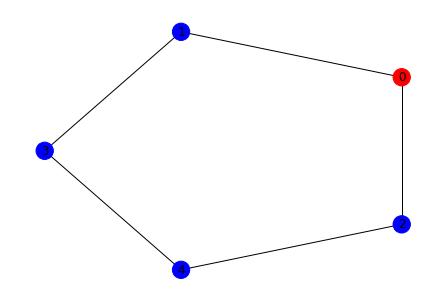

Threshold


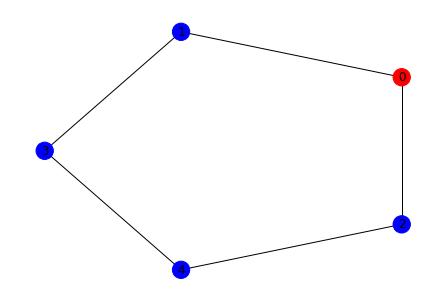

subthresh:


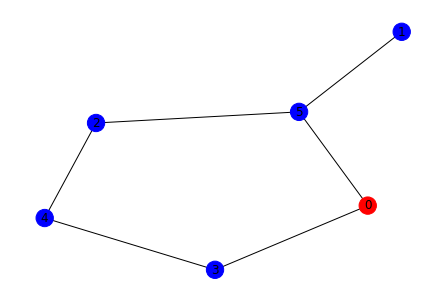

Threshold


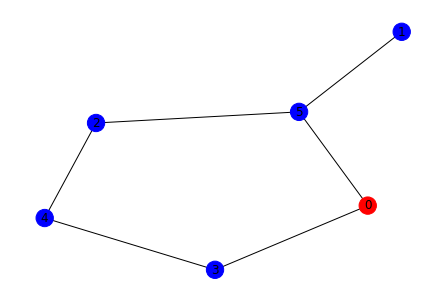

subthresh:


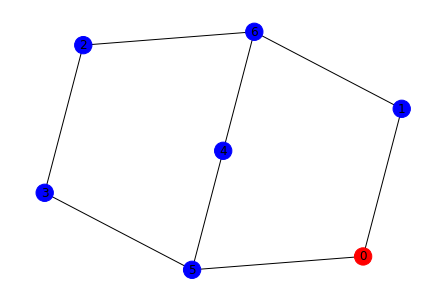

Threshold


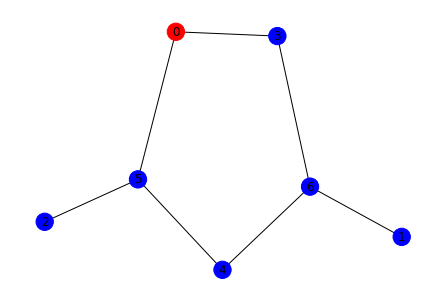

subthresh:


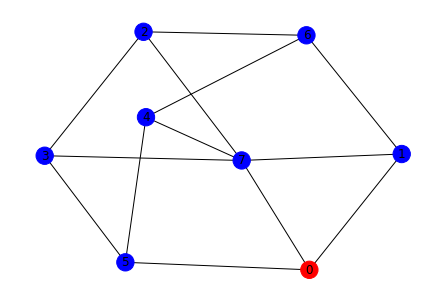

Threshold


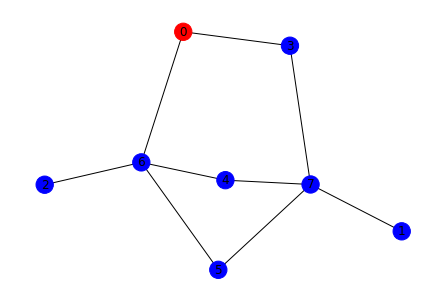

subthresh:


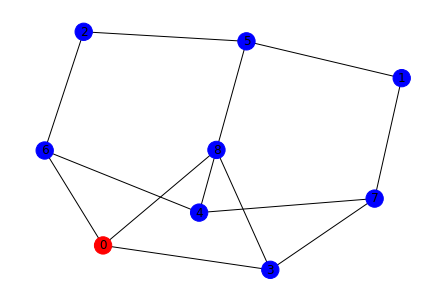

Threshold


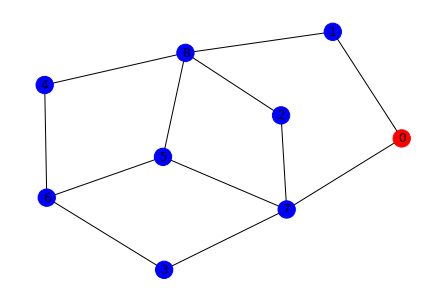

subthresh:


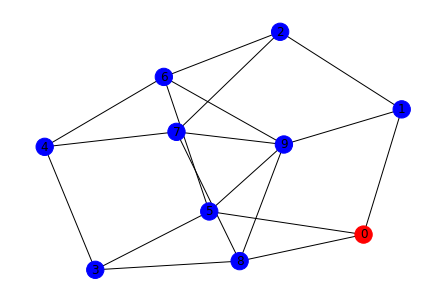

Threshold


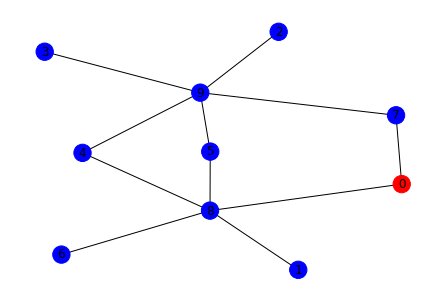

subthresh:


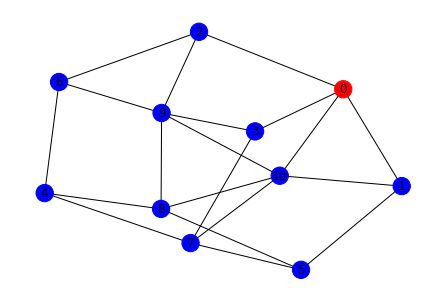

Threshold


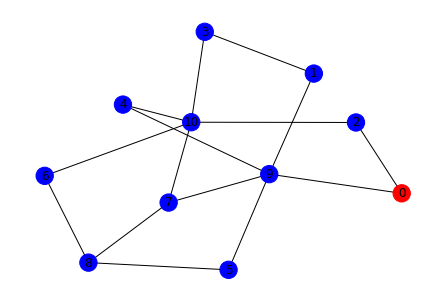

In [6]:
for nq in range(5, 12):
    print('subthresh:')
    draw_graph(bspf_nu[nq][0][0], from_edges=True)
    print('Threshold')
    draw_graph(bspf_nu[nq][2][0], from_edges=True)


subthresh:


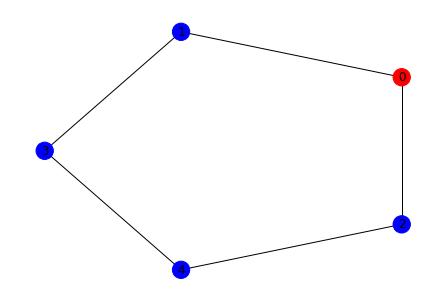

Threshold


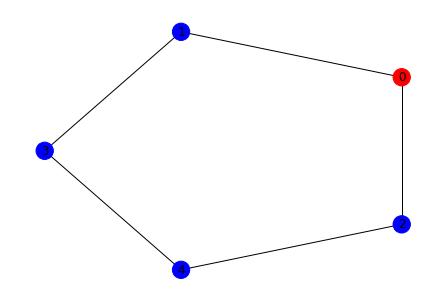

subthresh:


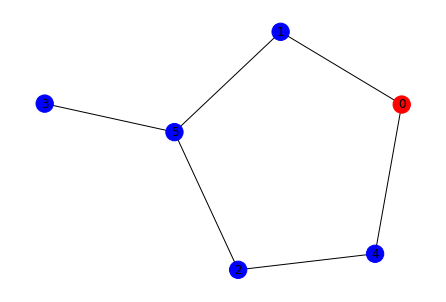

Threshold


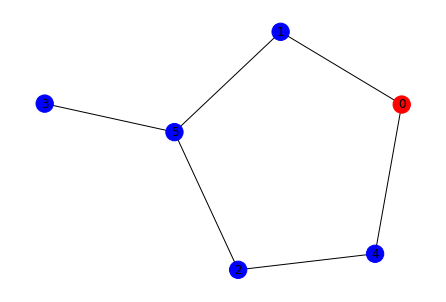

subthresh:


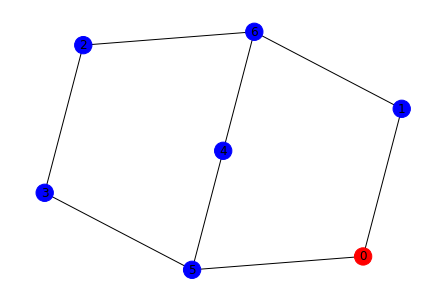

Threshold


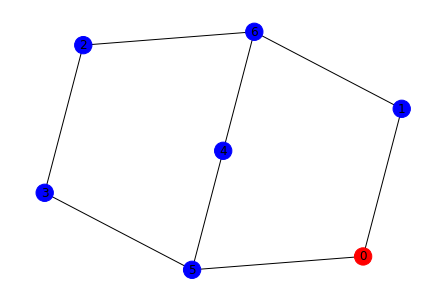

subthresh:


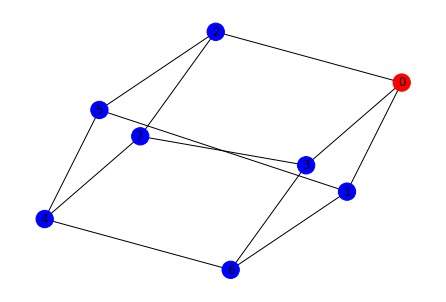

Threshold


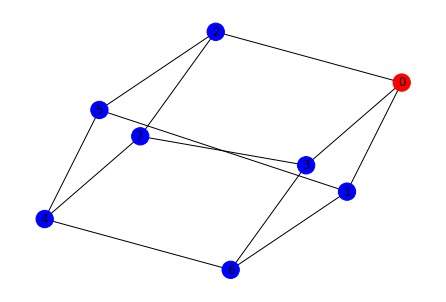

subthresh:


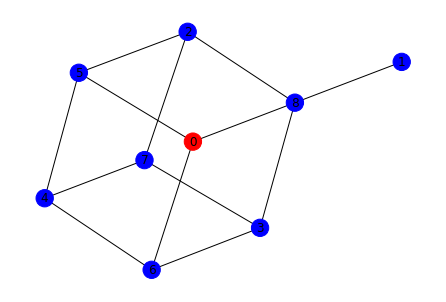

Threshold


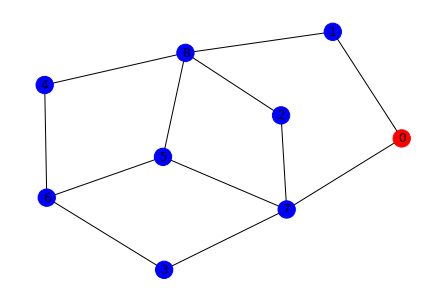

subthresh:


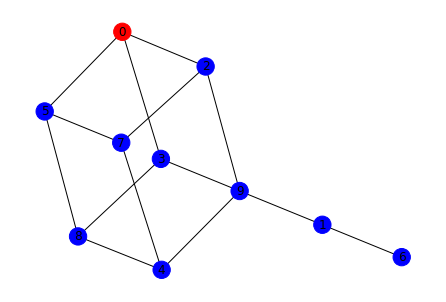

Threshold


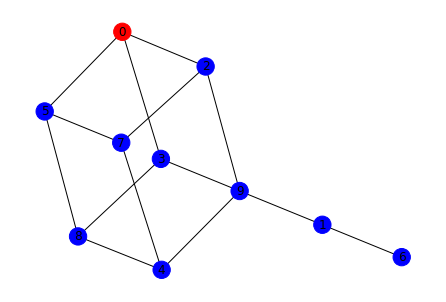

subthresh:


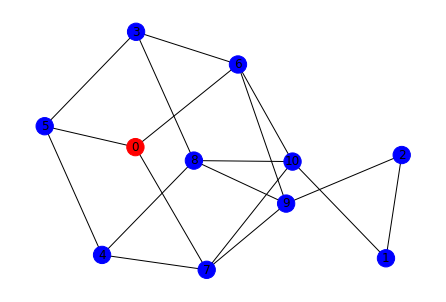

Threshold


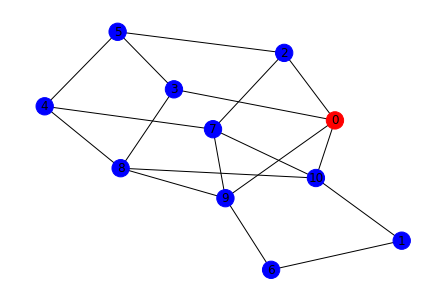

In [7]:
for nq in range(5, 12):
    print('subthresh:')
    draw_graph(bp_nu[nq][0][0], from_edges=True)
    print('Threshold')
    draw_graph(bp_nu[nq][2][0], from_edges=True)



In [9]:
print(bp_nu[7][0][0])

[(0, 5), (0, 1), (1, 6), (2, 3), (2, 6), (3, 5), (4, 6), (4, 5)]


In [2]:
from helpers import load_obj
from os import getcwd
gs = load_obj('7_qubit_graphs_ordered_num_in_class', getcwd()+'/data/uib_data')
print(len(gs))

110


In [1]:
a = 1

([(0, 1), (0, 4), (1, 2), (2, 3), (3, 4), (4, 5), (5, 6)], array([0.        , 0.0010101 , 0.0020202 , 0.0030303 , 0.0040404 ,
       0.00505051, 0.00606061, 0.00707071, 0.00808081, 0.00909091,
       0.01010101, 0.01111111, 0.01212121, 0.01313131, 0.01414141,
       0.01515152, 0.01616162, 0.01717172, 0.01818182, 0.01919192,
       0.02020202, 0.02121212, 0.02222222, 0.02323232, 0.02424242,
       0.02525253, 0.02626263, 0.02727273, 0.02828283, 0.02929293,
       0.03030303, 0.03131313, 0.03232323, 0.03333333, 0.03434343,
       0.03535354, 0.03636364, 0.03737374, 0.03838384, 0.03939394,
       0.04040404, 0.04141414, 0.04242424, 0.04343434, 0.04444444,
       0.04545455, 0.04646465, 0.04747475, 0.04848485, 0.04949495,
       0.05050505, 0.05151515, 0.05252525, 0.05353535, 0.05454545,
       0.05555556, 0.05656566, 0.05757576, 0.05858586, 0.05959596,
       0.06060606, 0.06161616, 0.06262626, 0.06363636, 0.06464646,
       0.06565657, 0.06666667, 0.06767677, 0.06868687, 0.06969697,
   

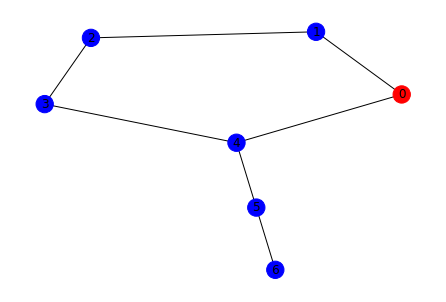

[{(0, 0, 2, 0, 0, 0, 1, 0): 1, (1, 0, 1, 1, 0, 0, 1, 0): 2, (1, 1, 2, 1, 0, 0, 1, 0): 2, (2, 0, 1, 2, 0, 0, 1, 0): 1, (0, 0, 0, 0, 3, 0, 1, 1): 1, (2, 0, 1, 0, 0, 0, 1, 2): 1}]


In [21]:
gs = load_obj('best_graphs_data_n=4_9_subthreshold', getcwd() + '/best_graphs')
print(gs[3])
draw_graph(gs[3][0], from_edges=True)
res = FastResult(bspf_nu[7][0][1][0])
print(bspf_nu[7][0][1])


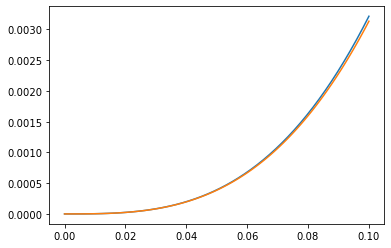

In [22]:
etas_high = np.linspace(0.9, 1)
plt.plot(etas_high, [res.get_spc_prob(t) for t in etas_high])
plt.plot(gs[3][1], gs[3][2])
plt.show()

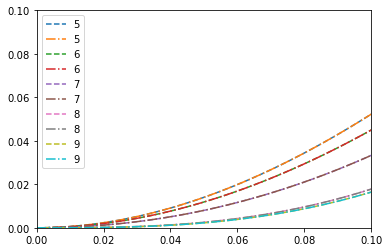

In [38]:
from graphs import graph_from_edges
g1 = gs[3][0]
g2 = bspf_nu[7][0][0]
losses = np.linspace(0, 0.1)
legend = []

# In cascaded decoder
for i in range(1, len(gs)):
    g1 = gs[i][0]
    g2 = bspf_nu[i+4][0][0]
    # dec = CascadeDecoder(graph_from_edges(g1))
    # dec.build_tree(cascading=False, ec=False)
    # plt.plot(losses, [1 - dec.success_prob_outcome_list(1-l, depolarizing_noise=0, ec=False) for l in losses])
    legend.append(i+4)
    dec = CascadeDecoder(graph_from_edges(g2))
    dec.build_tree(cascading=False, ec=False)
    plt.plot(losses, [1 - dec.success_prob_outcome_list(1-l, depolarizing_noise=0, ec=False) for l in losses], '--')
    dec = FastDecoder(graph_from_edges(g2))
    dec.get_dict()
    plt.plot(losses, [1 - dec.success_prob(1-l) for l in losses], '-.')

    legend.append(i+4)
    # plt.plot(gs[i][1], gs[i][2], '--')
plt.xlim(0, 0.1)
plt.ylim(0, 0.1)
plt.legend(legend)
plt.show()

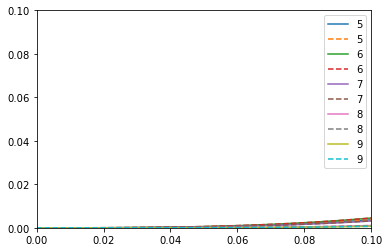

In [35]:
etas = np.linspace(0, 0.1)
legend = []

# In cascaded decoder
for i in range(1, len(gs)):
    g1 = gs[i][0]
    g2 = bspf_nu[i+4][0][0]
    dec = CascadeDecoder(graph_from_edges(g1))
    dec.build_tree(cascading=False, ec=False)
    plt.plot(losses, [dec.success_prob_outcome_list(t, depolarizing_noise=0, ec=False) for t in etas])
    legend.append(i+4)
    dec = CascadeDecoder(graph_from_edges(g2))
    dec.build_tree(cascading=False, ec=False)
    plt.plot(etas, [dec.success_prob_outcome_list(t, depolarizing_noise=0, ec=False) for t in etas], '--')
    legend.append(i+4)
plt.xlim(0, 0.1)
plt.ylim(0, 0.1)
    # plt.plot(gs[i][1], gs[i][2], '--')
plt.legend(legend)
plt.show()

In [3]:

from cascaded import AnalyticCascadedResult

## Data for cascaded STEANE



In [4]:
cube_edges = [(0, 1), (0, 3), (0, 7), (1, 2), (1, 4), (2, 3), (2, 5), (3, 6), (4, 5), (4, 7), (5, 6), (6, 7)]
etas = np.linspace(0, 1)
dec = CascadeDecoder(graph_from_edges(cube_edges))
bases = ['spc', 'x', 'y', 'z', 'xy']
dicts = [dec.get_dict(b) for b in bases]
res = AnalyticCascadedResult([dicts] * 5)

C:\Users\ip19160\AppData\Local\Temp/ipykernel_25452/2967664477.py:2: RuntimeWarning: invalid value encountered in double_scalars
  plt.plot(etas, [res.xx(depth, t)/t for t in etas])
C:\Users\ip19160\AppData\Local\Temp/ipykernel_25452/2967664477.py:2: RuntimeWarning: invalid value encountered in double_scalars
  plt.plot(etas, [res.xx(depth, t)/t for t in etas])
C:\Users\ip19160\AppData\Local\Temp/ipykernel_25452/2967664477.py:2: RuntimeWarning: invalid value encountered in double_scalars
  plt.plot(etas, [res.xx(depth, t)/t for t in etas])
C:\Users\ip19160\AppData\Local\Temp/ipykernel_25452/2967664477.py:2: RuntimeWarning: invalid value encountered in double_scalars
  plt.plot(etas, [res.xx(depth, t)/t for t in etas])


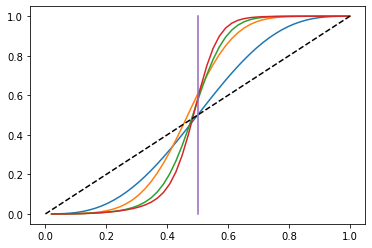

TypeError: cannot pickle 'generator' object

In [6]:
for depth in range(1, 5):
    plt.plot(etas, [res.xx(depth, t)/t for t in etas])
plt.plot(etas, etas, 'k--')
plt.plot([0.5, 0.5], [0, 1])
plt.show()
# save_obj((etas, ([res.xx(depth, t)/t for t in etas] for depth in range(1, 5))), 'SteaneCascadeXmeas', getcwd()+'/data/cascaded')

C:\Users\ip19160\AppData\Local\Temp/ipykernel_25452/3446308778.py:2: RuntimeWarning: invalid value encountered in double_scalars
  plt.plot(etas, [res.zi(depth, t)/(1-t) for t in etas])
C:\Users\ip19160\AppData\Local\Temp/ipykernel_25452/3446308778.py:2: RuntimeWarning: invalid value encountered in double_scalars
  plt.plot(etas, [res.zi(depth, t)/(1-t) for t in etas])
C:\Users\ip19160\AppData\Local\Temp/ipykernel_25452/3446308778.py:2: RuntimeWarning: invalid value encountered in double_scalars
  plt.plot(etas, [res.zi(depth, t)/(1-t) for t in etas])
C:\Users\ip19160\AppData\Local\Temp/ipykernel_25452/3446308778.py:2: RuntimeWarning: invalid value encountered in double_scalars
  plt.plot(etas, [res.zi(depth, t)/(1-t) for t in etas])


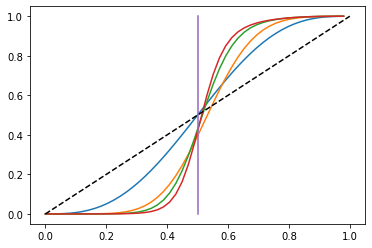

In [7]:
for depth in range(1, 5):
    plt.plot(etas, [res.zi(depth, t)/(1-t) for t in etas])
plt.plot(etas, etas, 'k--')
plt.plot([0.5, 0.5], [0, 1])
plt.show()
# save_obj((etas, ([res.zi(depth, t)/(1-t) for t in etas] for depth in range(1, 5))), 'SteaneCascadeZmeas', getcwd()+'/data/cascaded')


In [8]:
steane2ddata = load_obj('concatenated_steane_x_2d_data', getcwd() + '/data')
print(steane2ddata)

[array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        9.97055593e-01, 9.99246033e-01, 9.99831592e-01],
       [0.00000000e+00, 1.67643677e-14, 1.22934996e-12, ...,
        9.97764749e-01, 9.99427862e-01, 9.99872248e-01],
       [1.90958360e-14, 2.01735295e-11, 6.57849886e-10, ...,
        9.98134606e-01, 9.99522569e-01, 9.99893401e-01],
       ...,
       [4.99999996e-01, 4.99999998e-01, 4.99999999e-01, ...,
        9.98527797e-01, 9.99623017e-01, 9.99915796e-01],
       [4.99999998e-01, 4.99999999e-01, 5.00000000e-01, ...,
        9.98527797e-01, 9.99623017e-01, 9.99915796e-01],
       [4.99999999e-01, 5.00000000e-01, 5.00000000e-01, ...,
        9.98527797e-01, 9.99623017e-01, 9.99915796e-01]]), array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        9.24675911e-01, 9.52317165e-01, 9.71108212e-01],
       [1.28143385e-10, 2.81619927e-08, 2.41980353e-07, ...,
        9.32085207e-01, 9.57015256e-01, 9.73958605e-01],
       [3.01042488e-08, 9.80136489e-07, 5

C:\Users\ip19160\AppData\Local\Temp/ipykernel_25452/487292217.py:15: RuntimeWarning: invalid value encountered in double_scalars
  ax.plot([1-t for t in etas[20:]], [1-res.zi(i+1, t)/(1-t) for t in etas[20:]], color=colors[i], ls='--')
C:\Users\ip19160\AppData\Local\Temp/ipykernel_25452/487292217.py:15: RuntimeWarning: invalid value encountered in double_scalars
  ax.plot([1-t for t in etas[20:]], [1-res.zi(i+1, t)/(1-t) for t in etas[20:]], color=colors[i], ls='--')
C:\Users\ip19160\AppData\Local\Temp/ipykernel_25452/487292217.py:15: RuntimeWarning: invalid value encountered in double_scalars
  ax.plot([1-t for t in etas[20:]], [1-res.zi(i+1, t)/(1-t) for t in etas[20:]], color=colors[i], ls='--')
C:\Users\ip19160\AppData\Local\Temp/ipykernel_25452/487292217.py:15: RuntimeWarning: invalid value encountered in double_scalars
  ax.plot([1-t for t in etas[20:]], [1-res.zi(i+1, t)/(1-t) for t in etas[20:]], color=colors[i], ls='--')


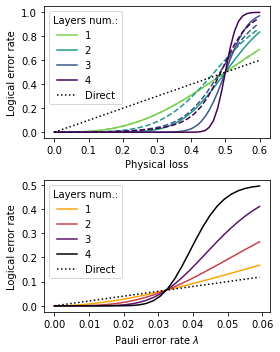

In [9]:
fig,axs = plt.subplots(2,1, figsize=(4, 5))
data_2Dconc_steane = steane2ddata
data_2Dconc_steane_loss = np.linspace(0, 0.6, 50)
data_2Dconc_steane_error = np.linspace(0, 0.1, 50)


########### Loss plot
ax = axs[0]

max_points_toplot = 50

colors = plt.cm.viridis(np.linspace(0.8,0,4))

for i in range(4):
    ax.plot([1-t for t in etas[20:]], [1-res.zi(i+1, t)/(1-t) for t in etas[20:]], color=colors[i], ls='--')
    data = data_2Dconc_steane[3-i][0][:max_points_toplot]
    ax.plot(data_2Dconc_steane_loss[:max_points_toplot], data[:max_points_toplot], label=str(i+1), color=colors[i])

ax.plot(data_2Dconc_steane_loss[:max_points_toplot], data_2Dconc_steane_loss[:max_points_toplot], 'k:', label='Direct')


ax.set_xlabel(r"Physical loss")
ax.set_ylabel('Logical error rate')
ax.legend(title='Layers num.:')

########### Error plot
ax = axs[1]

max_points_toplot = 30

colors = plt.cm.inferno(np.linspace(0.8,0,4))

for i in range(4):
    data = data_2Dconc_steane[3-i][:, 0][:max_points_toplot]
    ax.plot(data_2Dconc_steane_error[:max_points_toplot], data[:max_points_toplot], label=str(i+1), color=colors[i])

ax.plot(data_2Dconc_steane_error[:max_points_toplot], 2*data_2Dconc_steane_error[:max_points_toplot], 'k:', label='Direct')


ax.set_xlabel(r"Pauli error rate $\lambda$")
ax.set_ylabel('Logical error rate')
ax.legend(title='Layers num.:')

#####################

plt.tight_layout()

# plt.savefig(os.path.join(SavingFolder, 'ConcSteane_1D_plots.png'), dpi=200)

plt.show()

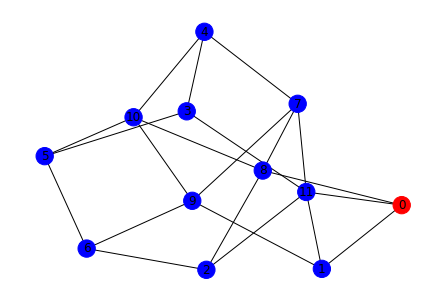

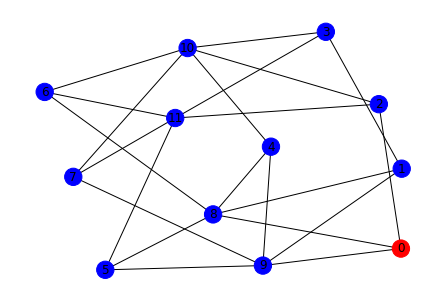

In [5]:
from helpers import load_obj
from os import getcwd
from graphs import draw_graph
best12 = load_obj('best_12_qubit_graphs', getcwd() + '/best_graphs')
draw_graph(best12[12][0][0], from_edges=True)
draw_graph(best12[12][2][0], from_edges=True)

## Concatenated Alien error plots



In [18]:
data_full = load_obj('concatenated_alien_x_2d_data', getcwd() + '/data')

0.0006683041514963239


[]

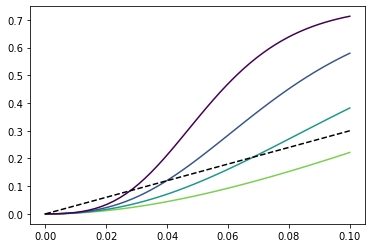

In [24]:
colors = plt.cm.viridis(np.linspace(0.8,0,4))
data_2Dconc_alien_error = np.linspace(0, 0.1, 50)
print(data[2])
npoints = 50


for i in range(4):
    data = data_full[3-i][:, 0]
    plt.plot(data_2Dconc_alien_error[:npoints], data[:npoints], label=str(i+1), color=colors[i])
plt.plot(data_2Dconc_alien_error[:npoints], 3 * data_2Dconc_alien_error[:npoints], 'k--')
plt.plot()

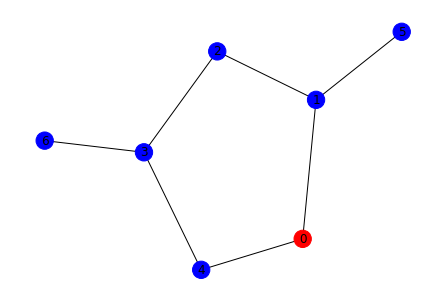

C:\Users\ip19160\PycharmProjects\LTdecode\cascaded.py:342: RuntimeWarning: invalid value encountered in double_scalars
  return prob_tot, sum([x[0] * x[1] for x in res_perfs]) / prob_tot


[0.0, 5.479134572045743e-34, 1.0813507880263436e-26, 2.1052551431070871e-22, 2.3887372740128175e-19, 5.674350527809806e-17, 4.988509187129097e-15, 2.1992653062016991e-13, 5.8278011408921054e-12, 1.0429465071689709e-10, 1.3643645191911554e-09, 1.379756765251651e-08, 1.1233491290929897e-07, 7.587099327244001e-07, 4.346351135670512e-06, 2.1466149261273305e-05, 9.248818576397336e-05, 0.00035052521283596204, 0.0011751909880515943, 0.0034988206276501716, 0.009276501860904885, 0.021959017231775693, 0.04655069825437967, 0.08873769707748734, 0.1529659050394088, 0.24018605601194512, 0.34657000492330786, 0.46409249674621433, 0.5826814080907317, 0.6927652310316383, 0.7871748648845913, 0.862044985051815, 0.9168343690164942, 0.9536821915496724, 0.9763396127850504, 0.989002868374111, 0.9953928294627613, 0.9982803277028904, 0.9994365652613311, 0.9998411139668442, 0.9999624475397269, 0.9999928291820114, 0.9999989499076017, 0.9999998908182675, 0.9999999928520773, 0.9999999997591905, 0.9999999999971422, 

C:\Users\ip19160\PycharmProjects\LTdecode\cascaded.py:342: RuntimeWarning: invalid value encountered in double_scalars
  return prob_tot, sum([x[0] * x[1] for x in res_perfs]) / prob_tot


[0.0, 2.3162809012257988e-17, 1.0201143371479275e-13, 1.4133111728407643e-11, 4.732818897096146e-10, 7.256999887031992e-09, 6.769941970604543e-08, 4.4693696602551905e-07, 2.2840338071715127e-06, 9.568904499395582e-06, 3.416042324984719e-05, 0.00010677755102567269, 0.00029804585161987226, 0.0007538787663627818, 0.001747417403152064, 0.0037442883189487976, 0.007469064881543506, 0.013950738446813042, 0.024518364801480945, 0.04072052176067959, 0.06415742910572629, 0.09624078992834482, 0.13792521303193428, 0.18947405973569797, 0.25032135245840875, 0.3190678954079587, 0.39361246689370355, 0.4713831265189333, 0.5496134555670318, 0.6256095652801322, 0.6969710143071, 0.7617508721054577, 0.8185562038778786, 0.8665956918646331, 0.9056786930781096, 0.9361663901037709, 0.9588764007207152, 0.9749485677513204, 0.9856886058168871, 0.9924129119780842, 0.9963184013959081, 0.9983949904024845, 0.999387609133262, 0.9998032256049105, 0.9999498507882274, 0.9999908346345994, 0.9999990060056999, 0.999999958208

C:\Users\ip19160\PycharmProjects\LTdecode\cascaded.py:342: RuntimeWarning: invalid value encountered in double_scalars
  return prob_tot, sum([x[0] * x[1] for x in res_perfs]) / prob_tot


[0.0, 4.853288023714521e-09, 3.2278522199587376e-07, 3.784470801003491e-06, 2.168660344514917e-05, 8.363057143877119e-05, 0.00025030161540859765, 0.0006274546528067615, 0.0013788623988642838, 0.002735826681489305, 0.005001085531873869, 0.008545533869282815, 0.013797026046444444, 0.021221516738187132, 0.031297777625686925, 0.04448776138266327, 0.06120525794554584, 0.081785728726406, 0.10646008982199714, 0.13533477311513908, 0.1683796955889776, 0.20542491415946112, 0.24616585263289242, 0.2901761735042011, 0.3369267268945694, 0.3858086088005407, 0.4361582308509848, 0.48728243527212484, 0.5384820383100082, 0.5890726829857449, 0.6384024425416502, 0.6858661514444073, 0.7309168731468872, 0.7730751846901504, 0.8119370363836493, 0.8471808291747525, 0.8785740711408424, 0.9059795806327927, 0.929360766654903, 0.948785113952468, 0.9644247046549655, 0.976552480800126, 0.9855330320349885, 0.9918069928295454, 0.9958686369392575, 0.9982369185191303, 0.9994209598792211, 0.9998817387579896, 0.99999238845

C:\Users\ip19160\PycharmProjects\LTdecode\cascaded.py:342: RuntimeWarning: invalid value encountered in double_scalars
  return prob_tot, sum([x[0] * x[1] for x in res_perfs]) / prob_tot


[0.0, 6.560553124960764e-05, 0.0005062534934968869, 0.0016477031845963212, 0.0037655873505922474, 0.0070892702084030665, 0.011805549413655286, 0.01806220197366744, 0.025971374105583804, 0.0356128150396581, 0.04703695476768684, 0.060267825736592735, 0.0753058284871579, 0.0921303412379066, 0.11070217341413864, 0.1309658631221115, 0.1528518185683734, 0.17627830342424525, 0.20115326613545348, 0.22737601317691203, 0.25483872625265375, 0.2834278234409131, 0.31302516428435745, 0.34350909882546826, 0.37475536058707337, 0.40663780349802736, 0.43902898276404295, 0.47180057968367267, 0.5048236704094383, 0.5379688386541125, 0.5711061323421487, 0.6041048642062639, 0.636833256329163, 0.6691579286304266, 0.7009432312985354, 0.7320504211680504, 0.7623366820419462, 0.7916539889590869, 0.819847816406855, 0.8467556904789351, 0.8722055849782379, 0.8960141614649816, 0.9179848532499213, 0.937905793332725, 0.9555475862855044, 0.970660924081494, 0.982974045868871, 0.9921900416897503, 0.9979840001442946, 1.0]


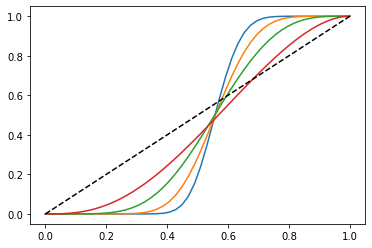

C:\Users\ip19160\PycharmProjects\LTdecode\error_correction.py:73: RuntimeWarning: invalid value encountered in double_scalars
  confidences_dict = {k: v / synd_tot_probs[syndrome] for k, v in syndrome_prob_dicts[syndrome].items()}
C:\Users\ip19160\PycharmProjects\LTdecode\error_correction.py:73: RuntimeWarning: invalid value encountered in double_scalars
  confidences_dict = {k: v / synd_tot_probs[syndrome] for k, v in syndrome_prob_dicts[syndrome].items()}
C:\Users\ip19160\PycharmProjects\LTdecode\error_correction.py:73: RuntimeWarning: invalid value encountered in double_scalars
  confidences_dict = {k: v / synd_tot_probs[syndrome] for k, v in syndrome_prob_dicts[syndrome].items()}
C:\Users\ip19160\PycharmProjects\LTdecode\error_correction.py:73: RuntimeWarning: invalid value encountered in double_scalars
  confidences_dict = {k: v / synd_tot_probs[syndrome] for k, v in syndrome_prob_dicts[syndrome].items()}


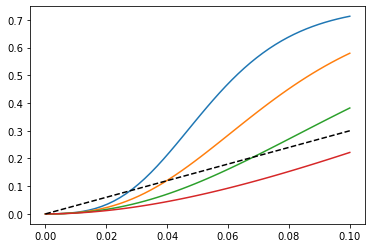

In [3]:
from cascaded import ConcatenatedResult

alien = gen_ring_graph(5)
alien.add_edges_from([(1, 5), (3, 6)])
draw_graph(alien)
bases = ['spc', 'x', 'y', 'z']


dec = CascadeDecoder(alien)
for b in bases:
    dec.build_tree(b, ec=True, cascading=False)

res = ConcatenatedResult([dec.successful_outcomes], [0] * 4, ec=True)
etas = np.linspace(0, 1)
for d in range(4):
    log_etas = []
    for eta in etas:
        # res.calc_params(eta, 0)
        log_eta = res.meff_prob('spc', eta, depth=d, error_p=0.05)[0]
        log_etas.append(log_eta)
    print(log_etas)
    plt.plot(etas, log_etas)
plt.plot(etas, etas, 'k--')
plt.show()

errors = np.linspace(0, 0.1)
for d in range(4):
    log_error = []
    for error in errors:
        log_error.append(1-res.meff_prob('spc', 1., error, depth=d)[1])
    plt.plot(errors, log_error)
plt.plot(errors, [3 * l for l in errors], 'k--')
plt.show()

## Redo concatenation plots for the paper


In [ ]:
## Concatenated Decorated Pentagon (aka Alien)

In [3]:
# 2D decorated pentagon (aka Alien) code

file_name_2Dconc_alien = 'concatenated_alien_spc_2d_data'

data_2Dconc_alien = load_obj(file_name_2Dconc_alien, getcwd() + '/data')
data_2Dconc_alien_loss = np.linspace(0, 0.6, 50)
data_2Dconc_alien_error = np.linspace(0, 0.1, 50)

data_2Dconc_alien_loss_mat, data_2Dconc_alien_error_mat  = np.meshgrid(data_2Dconc_alien_loss, data_2Dconc_alien_error)

def cmap_scaled(x, cmap_call, max_plot):
    if x<1:
        return cmap_call(0.5 * x)
    else:
        return cmap_call(0.5 + 0.4999*(x-1)/(max_plot-1))

# 1D alien code cascaded
file_name_casc_alien = 'AlienCascadedAmeasDataLoss'
file_name_casc_alien_errors = 'AlienCascadedErrors_spc'


data_1Dcasc_alien_raw = load_obj(file_name_casc_alien, getcwd() + '/data')
valid_ixs = np.where(data_1Dcasc_alien_raw[0]<=0.6)
data_1Dcasc_alien=[]
data_1Dcasc_alien.append(data_1Dcasc_alien_raw[0][valid_ixs])
data_1Dcasc_alien.append([np.array(data)[valid_ixs] for data in data_1Dcasc_alien_raw[1]])

data_1Dcasc_alien_errors = []
data_1Dcasc_alien_errors_raw = load_obj(file_name_casc_alien_errors, getcwd() + '/data/cascaded')

data_1Dcasc_alien_errors.append(data_1Dcasc_alien_errors_raw[0][:30])
data_1Dcasc_alien_errors.append([np.array(data)[valid_ixs] for data in data_1Dcasc_alien_errors_raw[1]])


### 1D plots

C:\Users\ip19160\AppData\Local\Temp/ipykernel_9004/2515832671.py:62: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


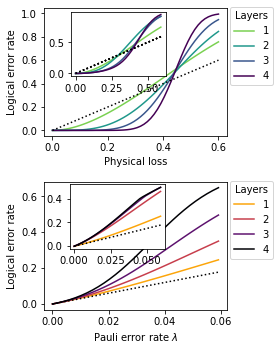

In [6]:
fig,axs = plt.subplots(2,1, figsize=(4, 5))
plt.rcParams.update({'font.size': 10})


########### Loss plot
ax = axs[0]

max_points_toplot = 50

colors = plt.cm.viridis(np.linspace(0.8,0,4))

for i in range(4):
    data = data_2Dconc_alien[3-i][0][:max_points_toplot]
    ax.plot(data_2Dconc_alien_loss[:max_points_toplot], data[:max_points_toplot], label=str(i+1), color=colors[i])

ax.plot(data_2Dconc_alien_loss[:max_points_toplot], data_2Dconc_alien_loss[:max_points_toplot], 'k:', label='')


ax.set_xlabel(r"Physical loss")
ax.set_ylabel('Logical error rate')
ax.legend(title='Layers', loc = [1.02, 0.4])


# add subplot with cascaded
left, bottom, width, height = [0.26, 0.77, 0.33, 0.18]
ax2 = fig.add_axes([left, bottom, width, height])

for i in range(4):
    ax2.plot(data_1Dcasc_alien[0], data_1Dcasc_alien[1][i], color=colors[i])
    ax2.plot(data_2Dconc_alien_loss[:max_points_toplot], data_2Dconc_alien_loss[:max_points_toplot], 'k:', label='')


########### Error plot
ax = axs[1]

max_points_toplot = 30

colors = plt.cm.inferno(np.linspace(0.8,0,4))

for i in range(4):
    data = data_2Dconc_alien[3-i][:, 0][:max_points_toplot]
    ax.plot(data_2Dconc_alien_error[:max_points_toplot], data[:max_points_toplot], label=str(i+1), color=colors[i])

ax.plot(data_2Dconc_alien_error[:max_points_toplot], [3 * d for d in data_2Dconc_alien_error[:max_points_toplot]], 'k:', label='')


ax.set_xlabel(r"Pauli error rate $\lambda$")
ax.set_ylabel('Logical error rate')
ax.legend(title='Layers', loc = [1.02, 0.4])


# add subplot with cascaded
left, bottom, width, height = [0.255, 0.29, 0.33, 0.18]
ax2 = fig.add_axes([left, bottom, width, height])

for i in range(4):
    ax2.plot(data_1Dcasc_alien_errors[0], data_1Dcasc_alien_errors[1][i], color=colors[i])
ax2.plot(data_2Dconc_alien_error[:max_points_toplot], 3*data_2Dconc_alien_error[:max_points_toplot], 'k:', label='')

#####################

plt.tight_layout()

plt.savefig('ConcAlien_1D_plots_new', dpi=200)

plt.show()

### 2D plots

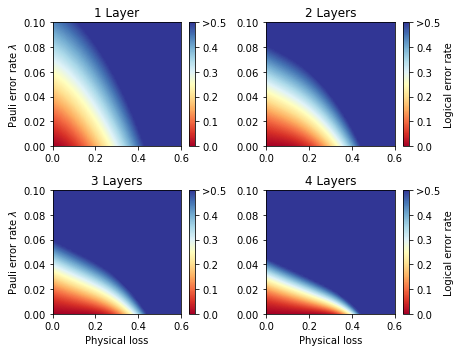

In [12]:
fig,axs = plt.subplots(2,2, figsize=(6.5, 5))

# cmap = 'seismic_r'
# cmap = 'Spectral'
cmap = 'RdYlBu'
# cmap = 'RdBu'

num_levels = 400

max_top = 0.5

levels = np.linspace(0, max_top, num_levels)

num_contours = 6

cbar_ticks = np.around(np.linspace(0,max_top,num_contours), decimals=2)
cbar_ticks_labels = [str(i) for i in cbar_ticks[:-1]] + ['>'+str(max_top)]

########## layer 1
ax = axs[0,0]

data_2D = data_2Dconc_alien[3]

cp = ax.contourf(data_2Dconc_alien_loss_mat, data_2Dconc_alien_error_mat,
                 np.minimum(data_2D, max_top*np.ones(data_2D.shape)),
                 levels=levels, cmap=cmap)

cbar = fig.colorbar(cp, ax = ax, ticks=cbar_ticks)
cbar.ax.set_yticklabels(cbar_ticks_labels)

# ax.set_xlabel('Physical loss')
ax.set_ylabel(r'Pauli error rate $\lambda$')

ax.set_title('1 Layer')

########## layer 2
ax = axs[0,1]

data_2D = data_2Dconc_alien[2]

cp = ax.contourf(data_2Dconc_alien_loss_mat, data_2Dconc_alien_error_mat,
                 np.minimum(data_2D, max_top*np.ones(data_2D.shape)),
                 levels=levels, cmap=cmap)

cbar = fig.colorbar(cp, ax = ax, ticks=cbar_ticks)
cbar.ax.set_yticklabels(cbar_ticks_labels)
cbar.ax.set_ylabel('Logical error rate', rotation=90)

# ax.set_xlabel('Physical loss')
# ax.set_ylabel(r'Pauli error rate $\lambda$')

ax.set_title('2 Layers')

########## layer 3
ax = axs[1,0]

data_2D = data_2Dconc_alien[1]

cp = ax.contourf(data_2Dconc_alien_loss_mat, data_2Dconc_alien_error_mat,
                 np.minimum(data_2D, max_top*np.ones(data_2D.shape)),
                 levels=levels, cmap=cmap)

cbar = fig.colorbar(cp, ax = ax, ticks=cbar_ticks)
cbar.ax.set_yticklabels(cbar_ticks_labels)

ax.set_xlabel('Physical loss')
ax.set_ylabel(r'Pauli error rate $\lambda$')

ax.set_title('3 Layers')

########## layer 4
ax = axs[1,1]

data_2D = data_2Dconc_alien[0]

cp = ax.contourf(data_2Dconc_alien_loss_mat, data_2Dconc_alien_error_mat,
                 np.minimum(data_2D, 0.5*np.ones(data_2D.shape)),
                 levels=levels, cmap=cmap)

cbar = fig.colorbar(cp, ax = ax, ticks=cbar_ticks)
cbar.ax.set_yticklabels(cbar_ticks_labels)
cbar.ax.set_ylabel('Logical error rate', rotation=90)

ax.set_xlabel('Physical loss')
# ax.set_ylabel(r'Pauli error rate $\lambda$')

ax.set_title('4 Layers')

############ Full plot

plt.tight_layout()

plt.savefig('ConcAlien_2D_new', dpi=200)

plt.show()

# Steane



In [8]:

# 2D stean code

file_name_2Dconc_steane = 'concatenated_steane_x_2d_data'

data_2Dconc_steane = load_obj(file_name_2Dconc_steane, getcwd() + '/data')
data_2Dconc_steane_loss = np.linspace(0, 0.6, 50)
data_2Dconc_steane_error = np.linspace(0, 0.1, 50)
#
# data_2Dconc_steane_loss_mat, data_2Dconc_steane_error_mat  = np.meshgrid(data_2Dconc_steane_loss, data_2Dconc_steane_error)
#
# def cmap_scaled(x, cmap_call, max_plot):
#     if x<1:
#         return cmap_call(0.5 * x)
#     else:
#         return cmap_call(0.5 + 0.4999*(x-1)/(max_plot-1))

# 1D stean code cascaded
file_name_casc_steane = 'SteaneCascadedXmeasDataLoss'
file_name_casc_steane_errors = 'SteaneCascadedErrors_z'


data_1Dcasc_steane_raw = load_obj(file_name_casc_steane, getcwd() + '/data/cascaded')
data_1Dcasc_steane_errors_raw = load_obj(file_name_casc_steane_errors, getcwd() + '/data')
valid_ixs = np.where(data_1Dcasc_steane_raw[0]<=0.6)
data_1Dcasc_steane=[]
data_1Dcasc_steane.append(data_1Dcasc_steane_raw[0][valid_ixs])
data_1Dcasc_steane.append([np.array(data)[valid_ixs] for data in data_1Dcasc_steane_raw[1]])
data_1Dcasc_steane_errors=[]
data_1Dcasc_steane_errors.append(data_1Dcasc_steane_errors_raw[0][valid_ixs])
data_1Dcasc_steane_errors.append([np.array(data)[valid_ixs] for data in data_1Dcasc_steane_errors_raw[1]])

#     data_1Dcasc_steane_loss = np.linspace(0, 0.6, 50)
#     data_1Dconc_steane_error = np.linspace(0, 0.1, 50)



### 1D plots

C:\Users\ip19160\AppData\Local\Temp/ipykernel_9004/2438765265.py:61: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


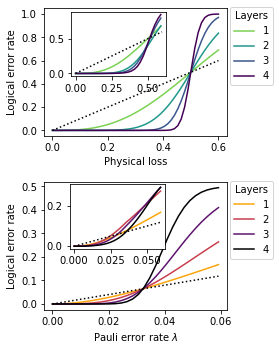

In [9]:
fig,axs = plt.subplots(2,1, figsize=(4, 5))
plt.rcParams.update({'font.size': 10})


########### Loss plot
ax = axs[0]

max_points_toplot = 50

colors = plt.cm.viridis(np.linspace(0.8,0,4))

for i in range(4):
    data = data_2Dconc_steane[3-i][0][:max_points_toplot]
    ax.plot(data_2Dconc_steane_loss[:max_points_toplot], data[:max_points_toplot], label=str(i+1), color=colors[i])

ax.plot(data_2Dconc_steane_loss[:max_points_toplot], data_2Dconc_steane_loss[:max_points_toplot], 'k:', label='')

ax.set_xlabel(r"Physical loss")
ax.set_ylabel('Logical error rate')
ax.legend(title='Layers', loc = [1.02, 0.4])

# add subplot with cascaded
left, bottom, width, height = [0.26, 0.77, 0.33, 0.18]
ax2 = fig.add_axes([left, bottom, width, height])

for i in range(4):
    ax2.plot(data_1Dcasc_steane[0], data_1Dcasc_steane[1][i], color=colors[i])
ax2.plot(data_2Dconc_steane_loss[:max_points_toplot], data_2Dconc_steane_loss[:max_points_toplot], 'k:', label='')




########### Error plot
ax = axs[1]

max_points_toplot = 30

colors = plt.cm.inferno(np.linspace(0.8,0,4))

for i in range(4):
    data = data_2Dconc_steane[3-i][:, 0][:max_points_toplot]
    ax.plot(data_2Dconc_steane_error[:max_points_toplot], data[:max_points_toplot], label=str(i+1), color=colors[i])

ax.plot(data_2Dconc_steane_error[:max_points_toplot], 2*data_2Dconc_steane_error[:max_points_toplot], 'k:', label='')


ax.set_xlabel(r"Pauli error rate $\lambda$")
ax.set_ylabel('Logical error rate')
ax.legend(title='Layers', loc = [1.02, 0.4])

# add subplot with cascaded
left, bottom, width, height = [0.255, 0.29, 0.33, 0.18]
ax2 = fig.add_axes([left, bottom, width, height])

for i in range(4):
    ax2.plot(data_1Dcasc_steane_errors[0], data_1Dcasc_steane_errors[1][i], color=colors[i])
ax2.plot(data_2Dconc_steane_error[:max_points_toplot], 2*data_2Dconc_steane_error[:max_points_toplot], 'k:', label='')

#####################

plt.tight_layout()

plt.savefig('ConcSteane_1D_plots_new', dpi=200)

plt.show()